In [28]:
# importとconstの設定
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt #to draw graphs

# const
ele_size = 1/2*0.02*0.02
poi = 0.2
e = 9.8*1000000000*37
th = 0.98
row = 2400
nmode = 10
delta_t = 0.0004
pow_delta_t = delta_t*delta_t
total_time = 1.0
total_step = int(total_time/delta_t)
hc = 0.02 #減衰定数
load = 100*9.8 #外力最大値
load_time = 0.01
load_step = int(load_time/delta_t)
load_diff = load/load_step
fixed_node_count = 50
alpha = 0.58332

In [29]:
print(total_step)

2500


In [18]:
# ファイル読み込み:nodeとeleの設定
node_path = "./one_hole_1_1.1.node"
ele_path = "./one_hole_1_1.1.ele"
# node_path = "~/src/github.com/shirafuji/graduation_thesis/vibration_simulation/one_hole_1_1.1.node"
# ele_path = '~/src/github.com/shirafuji/graduation_thesis/vibration_simulation/one_hole_1_1.1.ele'
with open(node_path) as f_node:
    s_line = f_node.readline()
    number_list = s_line.split()
    nnode_str = number_list[0]
    nnode = int(nnode_str)
    position = np.zeros((nnode, 2), dtype=np.float)
    for i in range(nnode):
        s_line = f_node.readline()
        number_list = s_line.split()
        x_str = number_list[1]
        y_str = number_list[2]
        x = float(x_str)
        y = float(y_str)
        position[i][0] = x*0.02
        position[i][1] = y*0.02
with open(ele_path) as f_ele:
    s_line = f_ele.readline()
    number_list = s_line.split()
    nele_str = number_list[0]
    nele = int(nele_str)
    eles = np.zeros((nele, 3), dtype=np.int64)
    for h in range(nele):
        s_line = f_ele.readline()
        number_list = s_line.split()
        i_str = number_list[1]
        j_str = number_list[2]
        k_str = number_list[3]
        i = int(i_str)
        j = int(j_str)
        k = k_str
        eles[h][0] = i
        eles[h][1] = j
        eles[h][2] = k

In [19]:
# 全体剛性行列と全体質量行列・全体集中質量行列の宣言(固定したものを抜いたものも)
kt = np.zeros((2*nnode, 2*nnode))
mt = np.zeros((2*nnode, 2*nnode))
imt = np.zeros((2*nnode, 2*nnode))
unfixed_kt = np.zeros((2*(nnode-fixed_node_count), 2*(nnode-fixed_node_count)))
unfixed_mt = np.zeros((2*(nnode-fixed_node_count), 2*(nnode-fixed_node_count)))
unfixed_imt = np.zeros((2*(nnode-fixed_node_count), 2*(nnode-fixed_node_count)))

In [20]:
# 剛性行列と質量行列計算の定義
def calc_ke(ele, position, kt):
    i = ele[0]
    j = ele[1]
    k = ele[2]
    xi = position[i-1][0]
    yi = position[i-1][1]
    xj = position[j-1][0]
    yj = position[j-1][1]
    xk = position[k-1][0]
    yk = position[k-1][1]
    # ひずみ-変位関係
    b = np.zeros((3, 6))
    b[0][0] = yj-yk
    b[0][2] = yk-yi
    b[0][4] = yi-yj
    b[1][1] = xk-xj
    b[1][3] = xi-xk
    b[1][5] = xj-xi
    b[2][0] = xk-xj
    b[2][1] = yj-yk
    b[2][2] = xi-xk
    b[2][3] = yk-yi
    b[2][4] = xj-xi
    b[2][5] = yi-yj
    # 応力-ひずみ関係
    d = np.zeros((3, 3))
    d[0][0] = 1 - poi
    d[0][1] = poi
    d[1][0] = poi
    d[1][1] = 1 - poi
    d[2][2] = (1-2*poi)/2
    d = d*e/(1+poi)/(1-2*poi)
    ke = th*ele_size*np.dot(np.dot(b.T, d), b)
    # 全体剛性行列への組み込み
    kt[2*i-1-1][2*i-1-1] += ke[1-1][1-1]
    kt[2*i-1-1][2*i-1] += ke[1-1][2-1]
    kt[2*i-1][2*i-1-1] += ke[2-1][1-1]
    kt[2*i-1][2*i-1] += ke[2-1][2-1]
    kt[2*i-1-1][2*j-1-1] += ke[1-1][3-1]
    kt[2*i-1-1][2*j-1] += ke[1-1][4-1]
    kt[2*i-1][2*j-1-1] += ke[2-1][3-1]
    kt[2*i-1][2*j-1] += ke[2-1][4-1]
    kt[2*i-1-1][2*k-1-1] += ke[1-1][5-1]
    kt[2*i-1-1][2*k-1] += ke[1-1][6-1]
    kt[2*i-1][2*k-1-1] += ke[2-1][5-1]
    kt[2*i-1][2*k-1] += ke[2-1][6-1]

    kt[2*j-1-1][2*i-1-1] += ke[3-1][1-1]
    kt[2*j-1-1][2*i-1] += ke[3-1][2-1]
    kt[2*j-1][2*i-1-1] += ke[4-1][1-1]
    kt[2*j-1][2*i-1] += ke[4-1][2-1]
    kt[2*j-1-1][2*j-1-1] += ke[3-1][3-1]
    kt[2*j-1-1][2*j-1] += ke[3-1][4-1]
    kt[2*j-1][2*j-1-1] += ke[4-1][3-1]
    kt[2*j-1][2*j-1] += ke[4-1][4-1]
    kt[2*j-1-1][2*k-1-1] += ke[3-1][5-1]
    kt[2*j-1-1][2*k-1] += ke[3-1][6-1]
    kt[2*j-1][2*k-1-1] += ke[4-1][5-1]
    kt[2*j-1][2*k-1] += ke[4-1][6-1]

    kt[2*k-1-1][2*i-1-1] += ke[5-1][1-1]
    kt[2*k-1-1][2*i-1] += ke[5-1][2-1]
    kt[2*k-1][2*i-1-1] += ke[6-1][1-1]
    kt[2*k-1][2*i-1] += ke[6-1][2-1]
    kt[2*k-1-1][2*j-1-1] += ke[5-1][3-1]
    kt[2*k-1-1][2*j-1] += ke[5-1][4-1]
    kt[2*k-1][2*j-1-1] += ke[6-1][3-1]
    kt[2*k-1][2*j-1] += ke[6-1][4-1]
    kt[2*k-1-1][2*k-1-1] += ke[5-1][5-1]
    kt[2*k-1-1][2*k-1] += ke[5-1][6-1]
    kt[2*k-1][2*k-1-1] += ke[6-1][5-1]
    kt[2*k-1][2*k-1] += ke[6-1][6-1]

    return kt

def calc_me(ele, mt):
    i = ele[0]
    j = ele[1]
    k = ele[2]
    me = np.zeros((6, 6))
    me[0][0] = 1/6
    me[0][2] = 1/12
    me[0][4] = 1/12
    me[1][1] = 1/6
    me[1][3] = 1/12
    me[1][5] = 1/12
    me[2][0] = 1/12
    me[2][2] = 1/6
    me[2][4] = 1/12
    me[3][1] = 1/12
    me[3][3] = 1/6
    me[3][5] = 1/12
    me[4][0] = 1/12
    me[4][2] = 1/12
    me[4][4] = 1/6
    me[5][1] = 1/12
    me[5][3] = 1/12
    me[5][5] = 1/6
    me = ele_size*th*row*me
    # 全体質量行列への組み込み
    mt[2*i-1-1][2*i-1-1] += me[1-1][1-1]
    mt[2*i-1-1][2*i-1] += me[1-1][2-1]
    mt[2*i-1][2*i-1-1] += me[2-1][1-1]
    mt[2*i-1][2*i-1] += me[2-1][2-1]
    mt[2*i-1-1][2*j-1-1] += me[1-1][3-1]
    mt[2*i-1-1][2*j-1] += me[1-1][4-1]
    mt[2*i-1][2*j-1-1] += me[2-1][3-1]
    mt[2*i-1][2*j-1] += me[2-1][4-1]
    mt[2*i-1-1][2*k-1-1] += me[1-1][5-1]
    mt[2*i-1-1][2*k-1] += me[1-1][6-1]
    mt[2*i-1][2*k-1-1] += me[2-1][5-1]
    mt[2*i-1][2*k-1] += me[2-1][6-1]

    mt[2*j-1-1][2*i-1-1] += me[3-1][1-1]
    mt[2*j-1-1][2*i-1] += me[3-1][2-1]
    mt[2*j-1][2*i-1-1] += me[4-1][1-1]
    mt[2*j-1][2*i-1] += me[4-1][2-1]
    mt[2*j-1-1][2*j-1-1] += me[3-1][3-1]
    mt[2*j-1-1][2*j-1] += me[3-1][4-1]
    mt[2*j-1][2*j-1-1] += me[4-1][3-1]
    mt[2*j-1][2*j-1] += me[4-1][4-1]
    mt[2*j-1-1][2*k-1-1] += me[3-1][5-1]
    mt[2*j-1-1][2*k-1] += me[3-1][6-1]
    mt[2*j-1][2*k-1-1] += me[4-1][5-1]
    mt[2*j-1][2*k-1] += me[4-1][6-1]

    mt[2*k-1-1][2*i-1-1] += me[5-1][1-1]
    mt[2*k-1-1][2*i-1] += me[5-1][2-1]
    mt[2*k-1][2*i-1-1] += me[6-1][1-1]
    mt[2*k-1][2*i-1] += me[6-1][2-1]
    mt[2*k-1-1][2*j-1-1] += me[5-1][3-1]
    mt[2*k-1-1][2*j-1] += me[5-1][4-1]
    mt[2*k-1][2*j-1-1] += me[6-1][3-1]
    mt[2*k-1][2*j-1] += me[6-1][4-1]
    mt[2*k-1-1][2*k-1-1] += me[5-1][5-1]
    mt[2*k-1-1][2*k-1] += me[5-1][6-1]
    mt[2*k-1][2*k-1-1] += me[6-1][5-1]
    mt[2*k-1][2*k-1] += me[6-1][6-1]

    return mt

def calc_ime(ele, imt):
    i = ele[0]
    j = ele[1]
    k = ele[2]
    ime = np.zeros((6, 6))
    for h in range(6):
        ime[h][h] = 1/3
    ime = ele_size*th*row*ime
    imt[2*i-1-1][2*i-1-1] += ime[1-1][1-1]
    imt[2*i-1][2*i-1] += ime[2-1][2-1]
    imt[2*j-1-1][2*j-1-1] += ime[3-1][3-1]
    imt[2*j-1][2*j-1] += ime[4-1][4-1]
    imt[2*k-1-1][2*k-1-1] += ime[5-1][5-1]
    imt[2*k-1][2*k-1] += ime[6-1][6-1]
    return imt

In [21]:
# 合成行列と質量行列の組み込み繰り返し
for h in range(nele):
    ele = eles[h]
    kt = calc_ke(ele, position, kt)
    mt = calc_me(ele, mt)
    imt = calc_ime(ele, imt)

In [22]:
# 外力生成(線形の増減)(左辺中心4点に荷重がかかるとする)
ft = np.zeros((total_step, 2*(nnode), 1))
for i in range(load_step):
    ft[i+1][2300][0] = ft[i][2300][0] + load_diff
    ft[i+1][2400][0] = ft[i][2400][0] + load_diff
    ft[i+1][2500][0] = ft[i][2500][0] + load_diff
    ft[i+1][2600][0] = ft[i][2600][0] + load_diff
for i in range(load_step):
    ft[load_step+i+1][2300][0] = ft[load_step+i][2300][0] - load_diff
    ft[load_step+i+1][2400][0] = ft[load_step+i][2400][0] - load_diff
    ft[load_step+i+1][2500][0] = ft[load_step+i][2500][0] - load_diff
    ft[load_step+i+1][2600][0] = ft[load_step+i][2600][0] - load_diff

In [23]:
# 固定点を抜いてみたもの
for h in range(2*(nnode-fixed_node_count)):
    for hh in range(2*(nnode-fixed_node_count)):
        unfixed_kt[h][hh] = kt[h+2*fixed_node_count][hh+2*fixed_node_count]
        unfixed_mt[h][hh] = mt[h+2*fixed_node_count][hh+2*fixed_node_count]
        unfixed_imt[h][hh] = imt[h+2*fixed_node_count][hh+2*fixed_node_count]

In [30]:
# タイムステップ毎の変位設定
u = np.zeros((total_step+1, 2*nnode, 1))

In [31]:
# 各タイムステップの計算
import time
ct = imt*alpha
left_matrix = imt+delta_t*ct/2
inv_left_matrix = np.linalg.inv(left_matrix)
for h in range(total_step-1):
    print(h)
    start = time.time()
    step = h+1
    right_matrix = pow_delta_t*ft[step] - pow_delta_t*np.dot(kt, u[step]) + np.dot(imt, (2*u[step]-u[step-1])) + delta_t*np.dot(ct, u[step-1])/2
    print(right_matrix)
    u[step+1] = np.dot(inv_left_matrix, right_matrix)
    elapsed_time = time.time() - start
    print(elapsed_time)
    print(u[step+1])

0
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
0.046051979064941406
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
1
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
0.045998334884643555
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
2
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
0.045918941497802734
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
3
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
0.04656672477722168
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
4
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
0.08285927772521973
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
5
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
0.06925010681152344
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
6
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
0.04662299156188965
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
7
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
0.05767250061035156
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
8
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
0.07439804077148438
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
9
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]

0.04761242866516113
[[-2.22137099e-33]
 [-7.63871428e-33]
 [ 6.37653755e-34]
 ...
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
47
[[-1.03072906e-33]
 [-3.55246261e-33]
 [ 8.84882058e-34]
 ...
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
0.08066892623901367
[[-6.57276036e-33]
 [-2.26533687e-32]
 [ 1.88090739e-33]
 ...
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
48
[[-2.96623793e-33]
 [-1.02470251e-32]
 [ 2.53852789e-33]
 ...
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
0.04634809494018555
[[-1.89151270e-32]
 [-6.53433021e-32]
 [ 5.39590087e-33]
 ...
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
49
[[-8.31415962e-33]
 [-2.87897598e-32]
 [ 7.09265734e-33]
 ...
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
0.04584193229675293
[[-5.30177919e-32]
 [-1.83586744e-31]
 [ 1.50761692e-32]
 ...
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
50
[[-2.27272760e-32]
 [-7.88889259e-32]
 [ 1.93255795e-32]
 ...
 [ 0.0

0.04998636245727539
[[-7.56407494e-22]
 [-2.88984285e-21]
 [ 1.90718295e-22]
 ...
 [ 1.92431006e-93]
 [ 3.40072610e-95]
 [ 2.45415041e-95]]
81
[[-2.08833992e-22]
 [-8.01054913e-22]
 [ 1.57242344e-22]
 ...
 [ 5.41626384e-93]
 [ 3.35066425e-95]
 [ 2.40761161e-95]]
0.05728578567504883
[[-1.33169408e-21]
 [-5.10817264e-21]
 [ 3.34234696e-22]
 ...
 [ 1.15128232e-92]
 [ 2.13665395e-94]
 [ 1.53528748e-94]]
82
[[-3.64604112e-22]
 [-1.40426591e-21]
 [ 2.73261566e-22]
 ...
 [ 3.13346955e-92]
 [ 2.03210860e-94]
 [ 1.45413551e-94]]
0.04610896110534668
[[-2.32501008e-21]
 [-8.95473278e-21]
 [ 5.80845429e-22]
 ...
 [ 6.66051027e-92]
 [ 1.29583645e-93]
 [ 9.27274159e-94]]
83
[[-6.31395129e-22]
 [-2.44185476e-21]
 [ 4.71003909e-22]
 ...
 [ 1.75560096e-91]
 [ 1.19159828e-93]
 [ 8.49299684e-94]]
0.046672821044921875
[[-4.02628493e-21]
 [-1.55712367e-20]
 [ 1.00116702e-21]
 ...
 [ 3.73170953e-91]
 [ 7.59859232e-93]
 [ 5.41582024e-93]]
84
[[-1.08473663e-21]
 [-4.21267506e-21]
 [ 8.05361664e-22]
 ...
 [ 9.

[[-2.97786529e-16]
 [-1.33157986e-15]
 [ 1.88125638e-16]
 ...
 [ 5.13055633e-74]
 [ 8.71389150e-76]
 [ 5.76423429e-76]]
0.07966232299804688
[[-1.89892724e-15]
 [-8.49122789e-15]
 [ 3.99880299e-16]
 ...
 [ 1.09055226e-73]
 [ 5.55668050e-75]
 [ 3.67574100e-75]]
113
[[-4.31068234e-16]
 [-1.93905521e-15]
 [ 2.70390387e-16]
 ...
 [ 1.60882431e-73]
 [ 2.79688177e-75]
 [ 1.84693543e-75]]
0.04597306251525879
[[-2.74883896e-15]
 [-1.23649810e-14]
 [ 5.74742444e-16]
 ...
 [ 3.41972075e-73]
 [ 1.78351755e-74]
 [ 1.17775509e-74]]
114
[[-6.21233898e-16]
 [-2.81132157e-15]
 [ 3.86856694e-16]
 ...
 [ 4.98390957e-73]
 [ 8.86547203e-75]
 [ 5.84443377e-75]]
0.046048879623413086
[[-3.96148872e-15]
 [-1.79272553e-14]
 [ 8.22303501e-16]
 ...
 [ 1.05938099e-72]
 [ 5.65334048e-74]
 [ 3.72688266e-74]]
115
[[-8.91379114e-16]
 [-4.05843458e-15]
 [ 5.51002237e-16]
 ...
 [ 1.52569252e-72]
 [ 2.77599308e-74]
 [ 1.82699013e-74]]
0.04716849327087402
[[-5.68415264e-15]
 [-2.58798544e-14]
 [ 1.17121165e-15]
 ...
 [ 3.

[[-9.97719106e-12]
 [-5.69955061e-11]
 [ 4.54401762e-12]
 ...
 [ 1.49232629e-59]
 [ 4.83707766e-61]
 [ 3.05689674e-61]]
0.048816680908203125
[[-6.36226225e-11]
 [-3.63449346e-10]
 [ 9.65877458e-12]
 ...
 [ 3.17209229e-59]
 [ 3.08451110e-60]
 [ 1.94932408e-60]]
147
[[-1.27878420e-11]
 [-7.36957867e-11]
 [ 5.75014884e-12]
 ...
 [ 3.45291704e-59]
 [ 1.13683945e-60]
 [ 7.17676109e-61]]
0.062181949615478516
[[-8.15456012e-11]
 [-4.69943814e-10]
 [ 1.22225299e-11]
 ...
 [ 7.33952861e-59]
 [ 7.24940588e-60]
 [ 4.57648209e-60]]
148
[[-1.63427931e-11]
 [-9.50239314e-11]
 [ 7.25384418e-12]
 ...
 [ 7.93737652e-59]
 [ 2.65413016e-60]
 [ 1.67373600e-60]]
0.046552419662475586
[[-1.04214839e-10]
 [-6.05949278e-10]
 [ 1.54187883e-11]
 ...
 [ 1.68717062e-58]
 [ 1.69248760e-59]
 [ 1.06730916e-59]]
149
[[-2.08260586e-11]
 [-1.22186838e-10]
 [ 9.12259379e-12]
 ...
 [ 1.81291847e-58]
 [ 6.15595672e-60]
 [ 3.87792375e-60]]
0.04620552062988281
[[-1.32803758e-10]
 [-7.79161896e-10]
 [ 1.93910069e-11]
 ...
 [ 

0.06090283393859863
[[-5.58003165e-08]
 [-4.59994455e-07]
 [ 4.93149979e-09]
 ...
 [ 1.66987154e-48]
 [ 2.55845523e-49]
 [ 1.56477562e-49]]
180
[[-1.02984362e-08]
 [-8.61310295e-08]
 [ 2.67477788e-09]
 ...
 [ 1.52673581e-48]
 [ 7.89256276e-50]
 [ 4.82259185e-50]]
0.06077075004577637
[[-6.56711409e-08]
 [-5.49240959e-07]
 [ 5.68551417e-09]
 ...
 [ 3.24523323e-48]
 [ 5.03293501e-49]
 [ 3.07527379e-49]]
181
[[-1.20914890e-08]
 [-1.02625801e-07]
 [ 3.07560511e-09]
 ...
 [ 2.95446832e-48]
 [ 1.54589743e-49]
 [ 9.43694625e-50]]
0.046010732650756836
[[-7.71050926e-08]
 [-6.54424933e-07]
 [ 6.53751348e-09]
 ...
 [ 6.28002483e-48]
 [ 9.85788968e-49]
 [ 6.01775856e-49]]
182
[[-1.41631951e-08]
 [-1.22024217e-07]
 [ 3.52717486e-09]
 ...
 [ 5.69335004e-48]
 [ 3.01497338e-49]
 [ 1.83875001e-49]]
0.04595589637756348
[[-9.03159627e-08]
 [-7.78124892e-07]
 [ 7.49737120e-09]
 ...
 [ 1.21017983e-47]
 [ 1.92259036e-48]
 [ 1.17253541e-48]]
183
[[-1.65507511e-08]
 [-1.44788432e-07]
 [ 4.03439301e-09]
 ...
 

0.06445455551147461
[[-3.73608638e-06]
 [-6.28960707e-05]
 [ 1.45646108e-07]
 ...
 [ 1.27236077e-39]
 [ 2.84059746e-40]
 [ 1.68118410e-40]]
214
[[-6.34778653e-07]
 [-1.10307119e-05]
 [ 7.26650317e-08]
 ...
 [ 1.02909614e-39]
 [ 7.73605639e-41]
 [ 4.57391192e-41]]
0.06148219108581543
[[-4.04786100e-06]
 [-7.03407217e-05]
 [ 1.54456963e-07]
 ...
 [ 2.18744919e-39]
 [ 4.93313392e-40]
 [ 2.91669539e-40]]
215
[[-6.85848422e-07]
 [-1.23143746e-05]
 [ 7.69518921e-08]
 ...
 [ 1.76385897e-39]
 [ 1.33934591e-40]
 [ 7.91082960e-41]]
0.04622673988342285
[[-4.37352307e-06]
 [-7.85263910e-05]
 [ 1.63569123e-07]
 ...
 [ 3.74926279e-39]
 [ 8.54075047e-40]
 [ 5.04458342e-40]]
216
[[-7.38941359e-07]
 [-1.37230018e-05]
 [ 8.13929424e-08]
 ...
 [ 3.01413994e-39]
 [ 2.31173217e-40]
 [ 1.36403771e-40]]
0.046173810958862305
[[-4.71208649e-06]
 [-8.75089347e-05]
 [ 1.73009030e-07]
 ...
 [ 6.40686297e-39]
 [ 1.47414701e-39]
 [ 8.69820530e-40]]
217
[[-7.93861103e-07]
 [-1.52656804e-05]
 [ 8.60055787e-08]
 ...
 

0.04689764976501465
[[-3.84860715e-06]
 [-1.00592599e-03]
 [ 1.49655961e-06]
 ...
 [ 1.69653974e-32]
 [ 5.17241303e-33]
 [ 2.95474596e-33]]
247
[[-4.16529887e-07]
 [-1.66634919e-04]
 [ 7.63084805e-07]
 ...
 [ 1.25622051e-32]
 [ 1.28798894e-33]
 [ 7.34916159e-34]]
0.07324814796447754
[[-2.65613073e-06]
 [-1.06259873e-03]
 [ 1.62201486e-06]
 ...
 [ 2.67022529e-32]
 [ 8.21325698e-33]
 [ 4.68641856e-33]]
248
[[-2.12277131e-07]
 [-1.75720088e-04]
 [ 8.24854619e-07]
 ...
 [ 1.97256367e-32]
 [ 2.04033915e-33]
 [ 1.16285186e-33]]
0.046042680740356445
[[-1.35365031e-06]
 [-1.12053310e-03]
 [ 1.75331292e-06]
 ...
 [ 4.19288599e-32]
 [ 1.30108491e-32]
 [ 7.41528197e-33]]
249
[[ 8.78688905e-09]
 [-1.84980988e-04]
 [ 8.88942352e-07]
 ...
 [ 3.09018572e-32]
 [ 3.22454092e-33]
 [ 1.83562481e-33]]
0.04624295234680176
[[ 5.60322963e-08]
 [-1.17958808e-03]
 [ 1.88953796e-06]
 ...
 [ 6.56850606e-32]
 [ 2.05622753e-32]
 [ 1.17054253e-32]]
250
[[ 2.46012292e-07]
 [-1.94393137e-04]
 [ 9.54792685e-07]
 ...
 

[[ 3.72296030e-06]
 [-3.55517538e-04]
 [-6.94126528e-06]
 ...
 [ 1.16596633e-26]
 [ 1.57628997e-27]
 [ 8.62949069e-28]]
0.06634712219238281
[[ 2.37405996e-05]
 [-2.26706675e-03]
 [-1.47543698e-05]
 ...
 [ 2.47838078e-26]
 [ 1.00516971e-26]
 [ 5.50285973e-27]]
281
[[ 3.22699566e-06]
 [-3.49894534e-04]
 [-8.19107225e-06]
 ...
 [ 1.70816989e-26]
 [ 2.32781307e-27]
 [ 1.27263916e-27]]
0.06186032295227051
[[ 2.05779288e-05]
 [-2.23120994e-03]
 [-1.74109625e-05]
 ...
 [ 3.63088994e-26]
 [ 1.48440148e-26]
 [ 8.11537442e-27]]
282
[[ 2.66559301e-06]
 [-3.43230508e-04]
 [-9.56453553e-06]
 ...
 [ 2.49778420e-26]
 [ 3.43107427e-27]
 [ 1.87323583e-27]]
0.05714774131774902
[[ 1.69979723e-05]
 [-2.18871473e-03]
 [-2.03303993e-05]
 ...
 [ 5.30929598e-26]
 [ 2.18792987e-26]
 [ 1.19452635e-26]]
283
[[ 2.03785203e-06]
 [-3.35520928e-04]
 [-1.10685369e-05]
 ...
 [ 3.64554290e-26]
 [ 5.04762308e-27]
 [ 2.75201894e-27]]
0.05639243125915527
[[ 1.29949893e-05]
 [-2.13955223e-03]
 [-2.35273080e-05]
 ...
 [ 7.7

0.048308610916137695
[[-2.97750868e-04]
 [ 1.15410185e-03]
 [-3.19382833e-04]
 ...
 [ 2.06597380e-21]
 [ 1.07219294e-21]
 [ 5.59921906e-22]]
313
[[-4.95599251e-05]
 [ 1.98337392e-04]
 [-1.60133517e-04]
 ...
 [ 1.34669379e-21]
 [ 2.34708698e-22]
 [ 1.22373906e-22]]
0.05263876914978027
[[-3.16034081e-04]
 [ 1.26475929e-03]
 [-3.40380181e-04]
 ...
 [ 2.86253550e-21]
 [ 1.49669209e-21]
 [ 7.80354792e-22]]
314
[[-5.25268425e-05]
 [ 2.14843858e-04]
 [-1.70509693e-04]
 ...
 [ 1.86293951e-21]
 [ 3.27104587e-22]
 [ 1.70273841e-22]]
0.053009033203125
[[-3.34953541e-04]
 [ 1.37001783e-03]
 [-3.62435805e-04]
 ...
 [ 3.95986862e-21]
 [ 2.08588284e-21]
 [ 1.08580343e-21]]
315
[[-5.55975361e-05]
 [ 2.30446944e-04]
 [-1.81403845e-04]
 ...
 [ 2.57297578e-21]
 [ 4.55140326e-22]
 [ 2.36540110e-22]]
0.046233177185058594
[[-3.54534761e-04]
 [ 1.46951570e-03]
 [-3.85592441e-04]
 ...
 [ 5.46912338e-21]
 [ 2.90234205e-21]
 [ 1.50837065e-21]]
316
[[-5.87765602e-05]
 [ 2.45097691e-04]
 [-1.92836779e-04]
 ...
 [

0.05858922004699707
[[-1.50177066e-03]
 [ 2.31805956e-03]
 [-1.72261998e-03]
 ...
 [ 2.48464249e-17]
 [ 1.61520807e-17]
 [ 7.99596402e-18]]
344
[[-2.48756077e-04]
 [ 3.68427265e-04]
 [-8.50016333e-04]
 ...
 [ 1.54589400e-17]
 [ 3.37369718e-18]
 [ 1.66701734e-18]]
0.05732417106628418
[[-1.58626951e-03]
 [ 2.34938959e-03]
 [-1.80679672e-03]
 ...
 [ 3.28595594e-17]
 [ 2.15134161e-17]
 [ 1.06302480e-17]]
345
[[-2.62781170e-04]
 [ 3.74309877e-04]
 [-8.91277074e-04]
 ...
 [ 2.04158112e-17]
 [ 4.48716728e-18]
 [ 2.21306463e-18]]
0.04608035087585449
[[-1.67570482e-03]
 [ 2.38690187e-03]
 [-1.89450065e-03]
 ...
 [ 4.33958964e-17]
 [ 2.86138000e-17]
 [ 1.41122862e-17]]
346
[[-2.77602632e-04]
 [ 3.81220519e-04]
 [-9.34245908e-04]
 ...
 [ 2.69243340e-17]
 [ 5.95972257e-18]
 [ 2.93380904e-18]]
0.04662132263183594
[[-1.77021843e-03]
 [ 2.43096970e-03]
 [-1.98583531e-03]
 ...
 [ 5.72304278e-17]
 [ 3.80040010e-17]
 [ 1.87083342e-17]]
347
[[-2.93238775e-04]
 [ 3.89206218e-04]
 [-9.78969285e-04]
 ...
 [

[[-1.07603548e-03]
 [ 1.05557668e-03]
 [-3.24654115e-03]
 ...
 [ 9.26960252e-14]
 [ 2.56379425e-14]
 [ 1.18274102e-14]]
0.04973435401916504
[[-6.86167065e-03]
 [ 6.73120881e-03]
 [-6.90085552e-03]
 ...
 [ 1.97034890e-13]
 [ 1.63488213e-13]
 [ 7.54211128e-14]]
379
[[-1.10499196e-03]
 [ 1.08670791e-03]
 [-3.33984772e-03]
 ...
 [ 1.17029803e-13]
 [ 3.25910861e-14]
 [ 1.50022975e-14]]
0.05759453773498535
[[-7.04632057e-03]
 [ 6.92972671e-03]
 [-7.09918819e-03]
 ...
 [ 2.48758826e-13]
 [ 2.07827069e-13]
 [ 9.56667567e-14]]
380
[[-1.13406844e-03]
 [ 1.11882726e-03]
 [-3.43357836e-03]
 ...
 [ 1.47566637e-13]
 [ 4.13779320e-14]
 [ 1.90053604e-14]]
0.04604625701904297
[[-7.23173567e-03]
 [ 7.13454556e-03]
 [-7.29842227e-03]
 ...
 [ 3.13667992e-13]
 [ 2.63859090e-13]
 [ 1.21193517e-13]]
381
[[-1.16330288e-03]
 [ 1.15203179e-03]
 [-3.52766100e-03]
 ...
 [ 1.85839395e-13]
 [ 5.24680126e-14]
 [ 2.40461899e-14]]
0.04631304740905762
[[-7.41815802e-03]
 [ 7.34628445e-03]
 [-7.49840455e-03]
 ...
 [ 3.9

0.047330617904663086
[[-1.36486458e-02]
 [ 1.75841819e-02]
 [-1.28948155e-02]
 ...
 [ 2.75456703e-10]
 [ 2.88026103e-10]
 [ 1.22732817e-10]]
413
[[-2.15768940e-03]
 [ 2.80815723e-03]
 [-6.10048299e-03]
 ...
 [ 1.57069262e-10]
 [ 5.51166563e-11]
 [ 2.34276360e-11]]
0.057326316833496094
[[-1.37591690e-02]
 [ 1.79070769e-02]
 [-1.29672010e-02]
 ...
 [ 3.33866793e-10]
 [ 3.51468284e-10]
 [ 1.49393515e-10]]
414
[[-2.17219325e-03]
 [ 2.85673603e-03]
 [-6.12779941e-03]
 ...
 [ 1.90156284e-10]
 [ 6.71794014e-11]
 [ 2.84835863e-11]]
0.04887866973876953
[[-1.38516573e-02]
 [ 1.82168545e-02]
 [-1.30252649e-02]
 ...
 [ 4.04196645e-10]
 [ 4.28390082e-10]
 [ 1.81634334e-10]]
415
[[-2.18368505e-03]
 [ 2.90310755e-03]
 [-6.14794408e-03]
 ...
 [ 2.29948585e-10]
 [ 8.17879638e-11]
 [ 3.45905181e-11]]
0.046143293380737305
[[-1.39249383e-02]
 [ 1.85125568e-02]
 [-1.30680844e-02]
 ...
 [ 4.88779254e-10]
 [ 5.21546066e-10]
 [ 2.20577061e-10]]
416
[[-2.19199313e-03]
 [ 2.94713548e-03]
 [-6.16048898e-03]
 ...

[[-6.31627973e-04]
 [ 2.87820024e-03]
 [-1.67193385e-03]
 ...
 [ 5.54134032e-08]
 [ 2.44615405e-08]
 [ 9.50547597e-09]]
0.08173370361328125
[[-4.02776973e-03]
 [ 1.83537276e-02]
 [-3.55386654e-03]
 ...
 [ 1.17786861e-07]
 [ 1.55986524e-07]
 [ 6.06145864e-08]]
448
[[-5.32499738e-04]
 [ 2.82730709e-03]
 [-1.38814306e-03]
 ...
 [ 6.45801761e-08]
 [ 2.87016304e-08]
 [ 1.11222955e-08]]
0.04643702507019043
[[-3.39564810e-03]
 [ 1.80291919e-02]
 [-2.95064016e-03]
 ...
 [ 1.37271775e-07]
 [ 1.83024760e-07]
 [ 7.09247325e-08]]
449
[[-4.31608631e-04]
 [ 2.77333817e-03]
 [-1.10000131e-03]
 ...
 [ 7.51809619e-08]
 [ 3.36398887e-08]
 [ 1.29998223e-08]]
0.04612469673156738
[[-2.75228497e-03]
 [ 1.76850425e-02]
 [-2.33816538e-03]
 ...
 [ 1.59804830e-07]
 [ 2.14515080e-07]
 [ 8.28973587e-08]]
450
[[-3.29118754e-04]
 [ 2.71631964e-03]
 [-8.08105359e-04]
 ...
 [ 8.74261146e-08]
 [ 3.93847595e-08]
 [ 1.51776076e-08]]
0.04608321189880371
[[-2.09872680e-03]
 [ 1.73214463e-02]
 [-1.71771066e-03]
 ...
 [ 1.8

0.04830288887023926
[[1.56771640e-02]
 [4.05245914e-04]
 [1.45018602e-02]
 ...
 [1.16443806e-05]
 [1.94501811e-05]
 [6.85933860e-06]]
482
[[ 2.49831076e-03]
 [-1.85300259e-05]
 [ 6.93584109e-03]
 ...
 [ 6.15238691e-06]
 [ 3.44935361e-06]
 [ 1.21291358e-06]]
0.05920147895812988
[[ 1.59312457e-02]
 [-1.18162400e-04]
 [ 1.47428402e-02]
 ...
 [ 1.30775281e-05]
 [ 2.19958625e-05]
 [ 7.73451593e-06]]
483
[[ 2.53356193e-03]
 [-9.81865543e-05]
 [ 7.03790169e-03]
 ...
 [ 6.90206056e-06]
 [ 3.89658726e-06]
 [ 1.36618456e-06]]
0.05349397659301758
[[ 1.61560356e-02]
 [-6.26116714e-04]
 [ 1.49597804e-02]
 ...
 [ 1.46710362e-05]
 [ 2.48477852e-05]
 [ 8.71189539e-06]]
484
[[ 2.56422449e-03]
 [-1.75264722e-04]
 [ 7.12868287e-03]
 ...
 [ 7.73462674e-06]
 [ 4.39703738e-06]
 [ 1.53715374e-06]]
0.046166419982910156
[[ 1.63515649e-02]
 [-1.11762932e-03]
 [ 1.51527451e-02]
 ...
 [ 1.64407408e-05]
 [ 2.80390591e-05]
 [ 9.80213284e-06]]
485
[[ 2.59032078e-03]
 [-2.49623276e-04]
 [ 7.20825158e-03]
 ...
 [ 8.65

 [ 3.74669113e-05]]
0.05891275405883789
[[ 0.01162613]
 [-0.0076369 ]
 [ 0.01190639]
 ...
 [ 0.00034997]
 [ 0.00074997]
 [ 0.00023892]]
517
[[ 1.78077603e-03]
 [-1.20194779e-03]
 [ 5.48798808e-03]
 ...
 [ 1.77789623e-04]
 [ 1.27941333e-04]
 [ 4.06426641e-05]]
0.05723834037780762
[[ 0.01135567]
 [-0.00766459]
 [ 0.01166528]
 ...
 [ 0.00037791]
 [ 0.00081586]
 [ 0.00025917]]
518
[[ 1.73953096e-03]
 [-1.20588664e-03]
 [ 5.37592505e-03]
 ...
 [ 1.91756726e-04]
 [ 1.39020263e-04]
 [ 4.40370948e-05]]
0.045905113220214844
[[ 0.01109265]
 [-0.00768971]
 [ 0.01142708]
 ...
 [ 0.0004076 ]
 [ 0.00088651]
 [ 0.00028082]]
519
[[ 1.69962237e-03]
 [-1.20945236e-03]
 [ 5.26573133e-03]
 ...
 [ 2.06577360e-04]
 [ 1.50883865e-04]
 [ 4.76601992e-05]]
0.04599928855895996
[[ 0.01083816]
 [-0.00771244]
 [ 0.01119285]
 ...
 [ 0.0004391 ]
 [ 0.00096216]
 [ 0.00030392]]
520
[[ 1.66120481e-03]
 [-1.21266040e-03]
 [ 5.15789780e-03]
 ...
 [ 2.22280198e-04]
 [ 1.63569839e-04]
 [ 5.15219368e-05]]
0.07271671295166016

[[ 0.00138933]
 [-0.00094384]
 [ 0.00418691]
 ...
 [ 0.00137058]
 [ 0.00136082]
 [ 0.00038997]]
0.07701921463012695
[[ 0.00885952]
 [-0.0060187 ]
 [ 0.00889971]
 ...
 [ 0.00291331]
 [ 0.00867767]
 [ 0.00248679]]
558
[[ 0.00139448]
 [-0.00093211]
 [ 0.00419566]
 ...
 [ 0.00140225]
 [ 0.00140483]
 [ 0.00040173]]
0.04624485969543457
[[ 0.00889236]
 [-0.00594392]
 [ 0.0089183 ]
 ...
 [ 0.00298063]
 [ 0.00895835]
 [ 0.00256175]]
559
[[ 0.00139922]
 [-0.00092068]
 [ 0.00420264]
 ...
 [ 0.00143245]
 [ 0.00144813]
 [ 0.00041324]]
0.04608726501464844
[[ 0.00892258]
 [-0.00587098]
 [ 0.00893313]
 ...
 [ 0.00304481]
 [ 0.00923446]
 [ 0.00263515]]
560
[[ 0.00140352]
 [-0.00090951]
 [ 0.00420779]
 ...
 [ 0.00146102]
 [ 0.00149054]
 [ 0.00042446]]
0.04587125778198242
[[ 0.00894995]
 [-0.00579977]
 [ 0.00894408]
 ...
 [ 0.00310554]
 [ 0.00950489]
 [ 0.0027067 ]]
561
[[ 0.00140733]
 [-0.00089859]
 [ 0.00421108]
 ...
 [ 0.00148781]
 [ 0.00153188]
 [ 0.00043535]]
0.06074237823486328
[[ 0.00897426]
 [-0.

[[ 0.00117034]
 [-0.00049124]
 [ 0.00353959]
 ...
 [ 0.00098148]
 [ 0.00141307]
 [ 0.00038548]]
0.07500791549682617
[[ 0.00746302]
 [-0.00313254]
 [ 0.00752376]
 ...
 [ 0.00208623]
 [ 0.0090109 ]
 [ 0.00245814]]
596
[[ 0.00115357]
 [-0.00048268]
 [ 0.00349824]
 ...
 [ 0.00094214]
 [ 0.00136606]
 [ 0.00037249]]
0.046227216720581055
[[ 0.00735608]
 [-0.00307794]
 [ 0.00743587]
 ...
 [ 0.00200261]
 [ 0.00871112]
 [ 0.00237531]]
597
[[ 0.00113665]
 [-0.00047494]
 [ 0.00345599]
 ...
 [ 0.00090378]
 [ 0.00131867]
 [ 0.0003594 ]]
0.04613232612609863
[[ 0.00724817]
 [-0.0030286 ]
 [ 0.00734605]
 ...
 [ 0.00192107]
 [ 0.0084089 ]
 [ 0.00229184]]
598
[[ 0.00111965]
 [-0.00046806]
 [ 0.00341299]
 ...
 [ 0.00086663]
 [ 0.0012712 ]
 [ 0.00034629]]
0.046065330505371094
[[ 0.00713981]
 [-0.0029847 ]
 [ 0.00725467]
 ...
 [ 0.00184212]
 [ 0.00810623]
 [ 0.00220822]]
599
[[ 0.00110267]
 [-0.00046204]
 [ 0.00336946]
 ...
 [ 0.00083093]
 [ 0.00122398]
 [ 0.00033323]]
0.06180691719055176
[[ 0.00703153]
 [-

0.05993151664733887
[[ 0.00583978]
 [-0.00385948]
 [ 0.00582902]
 ...
 [ 0.0018063 ]
 [ 0.00631895]
 [ 0.00160139]]
635
[[ 0.0009187 ]
 [-0.00061162]
 [ 0.00275013]
 ...
 [ 0.00086127]
 [ 0.0010107 ]
 [ 0.00025694]]
0.05572867393493652
[[ 0.00585834]
 [-0.00390018]
 [ 0.00584568]
 ...
 [ 0.00183071]
 [ 0.00644506]
 [ 0.00163846]]
636
[[ 0.00092146]
 [-0.00061779]
 [ 0.00275793]
 ...
 [ 0.00087126]
 [ 0.0010291 ]
 [ 0.00026251]]
0.04638981819152832
[[ 0.00587596]
 [-0.00393955]
 [ 0.00586225]
 ...
 [ 0.00185196]
 [ 0.00656238]
 [ 0.00167399]]
637
[[ 0.00092406]
 [-0.00062373]
 [ 0.00276559]
 ...
 [ 0.00087969]
 [ 0.0010459 ]
 [ 0.00026778]]
0.04598236083984375
[[ 0.00589254]
 [-0.00397743]
 [ 0.00587855]
 ...
 [ 0.00186987]
 [ 0.00666948]
 [ 0.00170758]]
638
[[ 0.00092649]
 [-0.00062941]
 [ 0.00277306]
 ...
 [ 0.00088648]
 [ 0.0010609 ]
 [ 0.00027268]]
0.04615640640258789
[[ 0.00590807]
 [-0.00401364]
 [ 0.00589442]
 ...
 [ 0.0018843 ]
 [ 0.00676513]
 [ 0.00173884]]
639
[[ 0.00092877]
 

0.04798746109008789
[[ 0.00582903]
 [-0.00352543]
 [ 0.0057863 ]
 ...
 [ 0.00113317]
 [ 0.00506668]
 [ 0.00104343]]
675
[[ 0.00090751]
 [-0.00054814]
 [ 0.00270727]
 ...
 [ 0.00052527]
 [ 0.00079655]
 [ 0.00016025]]
0.06847715377807617
[[ 0.00578701]
 [-0.00349541]
 [ 0.00575457]
 ...
 [ 0.00111651]
 [ 0.00507947]
 [ 0.00102191]]
676
[[ 0.00090077]
 [-0.00054379]
 [ 0.00269201]
 ...
 [ 0.00051804]
 [ 0.00079961]
 [ 0.00015732]]
0.04619288444519043
[[ 0.00574406]
 [-0.00346763]
 [ 0.00572214]
 ...
 [ 0.00110115]
 [ 0.00509893]
 [ 0.00100322]]
677
[[ 0.00089398]
 [-0.00053978]
 [ 0.00267658]
 ...
 [ 0.00051144]
 [ 0.00080357]
 [ 0.00015485]]
0.04618716239929199
[[ 0.00570077]
 [-0.00344208]
 [ 0.00568935]
 ...
 [ 0.00108711]
 [ 0.00512421]
 [ 0.00098742]]
678
[[ 0.00088723]
 [-0.00053612]
 [ 0.00266115]
 ...
 [ 0.00050546]
 [ 0.0008083 ]
 [ 0.00015283]]
0.04666733741760254
[[ 0.00565771]
 [-0.00341873]
 [ 0.00565655]
 ...
 [ 0.00107442]
 [ 0.00515436]
 [ 0.00097456]]
679
[[ 0.00088061]
 

0.05169486999511719
[[ 0.0049923 ]
 [-0.00258617]
 [ 0.00497148]
 ...
 [ 0.00163187]
 [ 0.00569128]
 [ 0.00148138]]
716
[[ 0.00077366]
 [-0.00039962]
 [ 0.00231567]
 ...
 [ 0.0007766 ]
 [ 0.00089851]
 [ 0.00023252]]
0.05653238296508789
[[ 0.00493345]
 [-0.0025483 ]
 [ 0.0049222 ]
 ...
 [ 0.00165073]
 [ 0.0057296 ]
 [ 0.00148272]]
717
[[ 0.00076407]
 [-0.0003935 ]
 [ 0.00229183]
 ...
 [ 0.00078442]
 [ 0.00090494]
 [ 0.00023244]]
0.046216487884521484
[[ 0.00487234]
 [-0.00250925]
 [ 0.00487151]
 ...
 [ 0.00166737]
 [ 0.00577065]
 [ 0.00148221]]
718
[[ 0.00075423]
 [-0.00038718]
 [ 0.00226757]
 ...
 [ 0.00079115]
 [ 0.00091172]
 [ 0.00023208]]
0.04611659049987793
[[ 0.00480961]
 [-0.00246894]
 [ 0.00481996]
 ...
 [ 0.00168167]
 [ 0.00581386]
 [ 0.00147992]]
719
[[ 0.00074425]
 [-0.00038065]
 [ 0.00224319]
 ...
 [ 0.00079675]
 [ 0.00091874]
 [ 0.00023145]]
0.0459752082824707
[[ 0.00474594]
 [-0.00242735]
 [ 0.00476814]
 ...
 [ 0.00169357]
 [ 0.00585862]
 [ 0.00147589]]
720
[[ 0.00073423]
 

0.0623018741607666
[[ 0.00542443]
 [-0.00157997]
 [ 0.00527439]
 ...
 [ 0.00125702]
 [ 0.00636219]
 [ 0.00095128]]
757
[[ 0.00085985]
 [-0.00025102]
 [ 0.00249941]
 ...
 [ 0.00058072]
 [ 0.00100297]
 [ 0.00014681]]
0.054323673248291016
[[ 0.00548309]
 [-0.00160069]
 [ 0.00531274]
 ...
 [ 0.00123437]
 [ 0.00639574]
 [ 0.00093619]]
758
[[ 0.00086805]
 [-0.00025427]
 [ 0.00251505]
 ...
 [ 0.00056981]
 [ 0.00100853]
 [ 0.00014449]]
0.04627084732055664
[[ 0.00553536]
 [-0.00162145]
 [ 0.00534599]
 ...
 [ 0.00121118]
 [ 0.00643119]
 [ 0.00092141]]
759
[[ 0.00087513]
 [-0.00025748]
 [ 0.00252803]
 ...
 [ 0.00055872]
 [ 0.00101429]
 [ 0.00014225]]
0.04579901695251465
[[ 0.00558054]
 [-0.00164191]
 [ 0.00537359]
 ...
 [ 0.00118761]
 [ 0.00646795]
 [ 0.0009071 ]]
760
[[ 0.000881  ]
 [-0.00026059]
 [ 0.00253811]
 ...
 [ 0.00054755]
 [ 0.00102017]
 [ 0.00014011]]
0.04585838317871094
[[ 0.00561799]
 [-0.00166172]
 [ 0.00539501]
 ...
 [ 0.00116387]
 [ 0.00650542]
 [ 0.00089345]]
761
[[ 0.00088557]
 

 [ 0.00029544]]
0.04798173904418945
[[ 0.00325399]
 [-0.00151624]
 [ 0.00369229]
 ...
 [ 0.00201549]
 [ 0.00769333]
 [ 0.00188396]]
796
[[ 0.00051025]
 [-0.00024406]
 [ 0.00174233]
 ...
 [ 0.00096724]
 [ 0.00122561]
 [ 0.00029913]]
0.07031464576721191
[[ 0.00325373]
 [-0.00155631]
 [ 0.0037035 ]
 ...
 [ 0.00205596]
 [ 0.00781549]
 [ 0.00190751]]
797
[[ 0.00051224]
 [-0.00025163]
 [ 0.00175057]
 ...
 [ 0.00098353]
 [ 0.00124579]
 [ 0.00030175]]
0.04580068588256836
[[ 0.00326646]
 [-0.0016046 ]
 [ 0.00372102]
 ...
 [ 0.00209059]
 [ 0.00794414]
 [ 0.00192421]]
798
[[ 0.00051623]
 [-0.00026049]
 [ 0.00176147]
 ...
 [ 0.00099684]
 [ 0.00126684]
 [ 0.00030323]]
0.04601573944091797
[[ 0.0032919 ]
 [-0.00166108]
 [ 0.00374419]
 ...
 [ 0.00211888]
 [ 0.00807839]
 [ 0.00193364]]
799
[[ 0.00052214]
 [-0.0002706 ]
 [ 0.00177469]
 ...
 [ 0.00100699]
 [ 0.00128861]
 [ 0.00030352]]
0.0514981746673584
[[ 0.00332959]
 [-0.00172557]
 [ 0.00377228]
 ...
 [ 0.00214046]
 [ 0.00821724]
 [ 0.0019355 ]]
800
[

0.049950599670410156
[[ 0.00384027]
 [-0.00235859]
 [ 0.00406872]
 ...
 [ 0.00082055]
 [ 0.00896079]
 [ 0.00089861]]
836
[[ 0.00059247]
 [-0.00035721]
 [ 0.00190492]
 ...
 [ 0.00038038]
 [ 0.00138069]
 [ 0.00014991]]
0.0654287338256836
[[ 0.00377806]
 [-0.00227783]
 [ 0.0040491 ]
 ...
 [ 0.00080853]
 [ 0.0088044 ]
 [ 0.00095596]]
837
[[ 0.00058384]
 [-0.00034559]
 [ 0.00189583]
 ...
 [ 0.00037499]
 [ 0.00135507]
 [ 0.00015921]]
0.04592537879943848
[[ 0.00372304]
 [-0.00220375]
 [ 0.00402977]
 ...
 [ 0.00079707]
 [ 0.00864105]
 [ 0.00101526]]
838
[[ 0.00057646]
 [-0.00033521]
 [ 0.00188692]
 ...
 [ 0.00036965]
 [ 0.00132842]
 [ 0.00016865]]
0.0460357666015625
[[ 0.00367599]
 [-0.00213756]
 [ 0.00401085]
 ...
 [ 0.00078572]
 [ 0.0084711 ]
 [ 0.00107548]]
839
[[ 0.00057043]
 [-0.00032623]
 [ 0.00187827]
 ...
 [ 0.00036416]
 [ 0.00130079]
 [ 0.00017808]]
0.05525684356689453
[[ 0.0036375 ]
 [-0.00208029]
 [ 0.00399246]
 ...
 [ 0.00077405]
 [ 0.0082949 ]
 [ 0.00113559]]
840
[[ 0.0005658 ]
 [

[[ 0.00070787]
 [-0.00045319]
 [ 0.00214546]
 ...
 [-0.0005336 ]
 [ 0.00024609]
 [ 0.00010525]]
0.07434821128845215
[[ 0.00451393]
 [-0.00288993]
 [ 0.0045604 ]
 ...
 [-0.00113422]
 [ 0.00156929]
 [ 0.00067116]]
877
[[ 7.06453547e-04]
 [-4.50437909e-04]
 [ 2.15255818e-03]
 ...
 [-5.79732939e-04]
 [ 2.26346110e-04]
 [ 9.78434472e-05]]
0.05597686767578125
[[ 0.00450492]
 [-0.00287236]
 [ 0.00457548]
 ...
 [-0.00123228]
 [ 0.00144337]
 [ 0.00062393]]
878
[[ 7.04727955e-04]
 [-4.47868309e-04]
 [ 2.15772497e-03]
 ...
 [-6.27432440e-04]
 [ 2.06969336e-04]
 [ 8.98262669e-05]]
0.055024147033691406
[[ 0.00449391]
 [-0.00285597]
 [ 0.00458647]
 ...
 [-0.00133367]
 [ 0.0013198 ]
 [ 0.0005728 ]]
879
[[ 7.02715576e-04]
 [-4.45584430e-04]
 [ 2.16091063e-03]
 ...
 [-6.76700834e-04]
 [ 1.87984062e-04]
 [ 8.10744622e-05]]
0.06260228157043457
[[ 0.00448108]
 [-0.00284141]
 [ 0.00459324]
 ...
 [-0.0014384 ]
 [ 0.00119874]
 [ 0.000517  ]]
880
[[ 7.00443665e-04]
 [-4.43673200e-04]
 [ 2.16209210e-03]
 ...
 

[[ 0.00067686]
 [-0.00044532]
 [ 0.00192241]
 ...
 [-0.00254973]
 [ 0.00028922]
 [-0.00073805]]
0.07019901275634766
[[ 0.0043162 ]
 [-0.00283972]
 [ 0.00408627]
 ...
 [-0.00541971]
 [ 0.00184429]
 [-0.00470638]]
913
[[ 0.00067644]
 [-0.00043701]
 [ 0.00192582]
 ...
 [-0.00258657]
 [ 0.00031558]
 [-0.00076174]]
0.04945802688598633
[[ 0.00431351]
 [-0.0027867 ]
 [ 0.00409353]
 ...
 [-0.00549803]
 [ 0.00201236]
 [-0.00485749]]
914
[[ 0.00067541]
 [-0.0004281 ]
 [ 0.00192932]
 ...
 [-0.00262043]
 [ 0.0003418 ]
 [-0.00078425]]
0.04631233215332031
[[ 0.00430696]
 [-0.00272991]
 [ 0.00410097]
 ...
 [-0.00556998]
 [ 0.00217962]
 [-0.005001  ]]
915
[[ 0.00067374]
 [-0.00041867]
 [ 0.00193272]
 ...
 [-0.0026511 ]
 [ 0.00036772]
 [-0.00080556]]
0.045897483825683594
[[ 0.0042963 ]
 [-0.0026698 ]
 [ 0.0041082 ]
 ...
 [-0.00563518]
 [ 0.00234485]
 [-0.00513687]]
916
[[ 0.0006714 ]
 [-0.00040881]
 [ 0.00193584]
 ...
 [-0.00267841]
 [ 0.00039314]
 [-0.00082566]]
0.06491851806640625
[[ 0.00428139]
 [-0

0.04918932914733887
[[ 0.00455646]
 [-0.00098121]
 [ 0.00446268]
 ...
 [-0.00341177]
 [ 0.00540337]
 [-0.00512198]]
954
[[ 0.00072567]
 [-0.00014763]
 [ 0.00212573]
 ...
 [-0.00158681]
 [ 0.00084837]
 [-0.00078677]]
0.06722116470336914
[[ 0.00462747]
 [-0.00094144]
 [ 0.00451847]
 ...
 [-0.00337292]
 [ 0.0054099 ]
 [-0.00501707]]
955
[[ 0.00073642]
 [-0.00014109]
 [ 0.00215215]
 ...
 [-0.00157288]
 [ 0.00084794]
 [-0.00077068]]
0.04641151428222656
[[ 0.00469602]
 [-0.00089969]
 [ 0.00457462]
 ...
 [-0.00334331]
 [ 0.00540713]
 [-0.00491445]]
956
[[ 0.0007467 ]
 [-0.00013424]
 [ 0.00217851]
 ...
 [-0.00156328]
 [ 0.00084596]
 [-0.00075511]]
0.045783281326293945
[[ 0.00476157]
 [-0.00085603]
 [ 0.00463064]
 ...
 [-0.00332291]
 [ 0.00539451]
 [-0.00481516]]
957
[[ 0.00075644]
 [-0.0001271 ]
 [ 0.00220459]
 ...
 [-0.00155794]
 [ 0.00084237]
 [-0.00074021]]
0.05353116989135742
[[ 0.00482366]
 [-0.00081051]
 [ 0.00468608]
 ...
 [-0.00331157]
 [ 0.00537161]
 [-0.00472017]]
958
[[ 0.00076558]


0.04777026176452637
[[ 0.00643881]
 [ 0.00131918]
 [ 0.00673047]
 ...
 [-0.00484539]
 [ 0.00231237]
 [-0.004254  ]]
990
[[ 0.00102893]
 [ 0.00021792]
 [ 0.00322818]
 ...
 [-0.00229559]
 [ 0.00036184]
 [-0.00066402]]
0.05335593223571777
[[ 0.00656131]
 [ 0.00138962]
 [ 0.00686182]
 ...
 [-0.00487952]
 [ 0.00230735]
 [-0.00423432]]
991
[[ 0.00104913]
 [ 0.00022847]
 [ 0.00329197]
 ...
 [-0.00231042]
 [ 0.00036274]
 [-0.00066069]]
0.051748037338256836
[[ 0.00669008]
 [ 0.00145691]
 [ 0.00699742]
 ...
 [-0.00491104]
 [ 0.0023131 ]
 [-0.00421307]]
992
[[ 0.00107026]
 [ 0.00023846]
 [ 0.00335752]
 ...
 [-0.00232402]
 [ 0.00036526]
 [-0.00065723]]
0.04580879211425781
[[ 0.00682483]
 [ 0.00152064]
 [ 0.00713674]
 ...
 [-0.00493995]
 [ 0.0023292 ]
 [-0.00419104]]
993
[[ 0.00109227]
 [ 0.00024784]
 [ 0.00342455]
 ...
 [-0.00233639]
 [ 0.00036933]
 [-0.00065378]]
0.04638218879699707
[[ 0.00696521]
 [ 0.00158041]
 [ 0.00727923]
 ...
 [-0.00496624]
 [ 0.00235515]
 [-0.00416906]]
994
[[ 0.00111511]


0.04619431495666504
[[ 0.01226165]
 [ 0.00206123]
 [ 0.01193902]
 ...
 [-0.00450568]
 [ 0.00549234]
 [-0.00555364]]
1032
[[ 0.00193054]
 [ 0.00032304]
 [ 0.0056411 ]
 ...
 [-0.00208636]
 [ 0.00087965]
 [-0.00086331]]
0.08054184913635254
[[ 0.0123107 ]
 [ 0.00205997]
 [ 0.01199074]
 ...
 [-0.00443477]
 [ 0.00560933]
 [-0.00550519]]
1033
[[ 0.00193704]
 [ 0.00032235]
 [ 0.00566127]
 ...
 [-0.00204964]
 [ 0.0008985 ]
 [-0.0008537 ]]
0.04621171951293945
[[ 0.0123521 ]
 [ 0.00205557]
 [ 0.01203361]
 ...
 [-0.00435673]
 [ 0.00572954]
 [-0.00544387]]
1034
[[ 0.00194228]
 [ 0.00032114]
 [ 0.00567702]
 ...
 [-0.00200946]
 [ 0.00091778]
 [-0.00084207]]
0.04658079147338867
[[ 0.01238556]
 [ 0.00204783]
 [ 0.0120671 ]
 ...
 [-0.00427131]
 [ 0.00585253]
 [-0.0053697 ]]
1035
[[ 0.00194623]
 [ 0.00031938]
 [ 0.00568812]
 ...
 [-0.00196573]
 [ 0.00093742]
 [-0.00082844]]
0.048532724380493164
[[ 0.01241074]
 [ 0.00203662]
 [ 0.01209069]
 ...
 [-0.00417836]
 [ 0.00597773]
 [-0.00528281]]
1036
[[ 0.00194

[[0.00110637]
 [0.0001677 ]
 [0.00344499]
 ...
 [0.00020905]
 [0.0011036 ]
 [0.00022233]]
0.04758405685424805
[[0.00705511]
 [0.0010694 ]
 [0.00732267]
 ...
 [0.00044437]
 [0.00703745]
 [0.00141773]]
1071
[[0.00107322]
 [0.00016872]
 [0.00337005]
 ...
 [0.00024726]
 [0.00110016]
 [0.00024071]]
0.05777478218078613
[[0.00684369]
 [0.0010759 ]
 [0.00716339]
 ...
 [0.00052557]
 [0.00701553]
 [0.00153495]]
1072
[[0.00104183]
 [0.00017013]
 [0.00330002]
 ...
 [0.00028432]
 [0.00109815]
 [0.00025687]]
0.04653024673461914
[[0.00664356]
 [0.0010849 ]
 [0.00701454]
 ...
 [0.00060436]
 [0.00700271]
 [0.00163804]]
1073
[[0.00101241]
 [0.0001719 ]
 [0.00323534]
 ...
 [0.00032037]
 [0.00109768]
 [0.00027076]]
0.04591655731201172
[[0.00645593]
 [0.00109618]
 [0.00687704]
 ...
 [0.00068097]
 [0.00699969]
 [0.00172659]]
1074
[[0.00098512]
 [0.00017398]
 [0.00317639]
 ...
 [0.00035548]
 [0.00109883]
 [0.00028233]]
0.05373644828796387
[[0.00628194]
 [0.00110942]
 [0.00675174]
 ...
 [0.00075561]
 [0.00700

[[ 1.55043909e-03]
 [ 3.97012543e-05]
 [ 4.40738965e-03]
 ...
 [ 3.51020991e-04]
 [ 1.39922214e-03]
 [-5.85043554e-05]]
0.06811714172363281
[[ 0.00988685]
 [ 0.00025317]
 [ 0.00936836]
 ...
 [ 0.00074613]
 [ 0.00892257]
 [-0.00037307]]
1110
[[ 1.57856583e-03]
 [ 3.35272743e-05]
 [ 4.46050272e-03]
 ...
 [ 3.13729057e-04]
 [ 1.39355706e-03]
 [-6.16609199e-05]]
0.0748598575592041
[[ 0.01006621]
 [ 0.0002138 ]
 [ 0.00948126]
 ...
 [ 0.00066686]
 [ 0.00888644]
 [-0.0003932 ]]
1111
[[ 1.60446029e-03]
 [ 2.83368978e-05]
 [ 4.51041108e-03]
 ...
 [ 2.76761050e-04]
 [ 1.38746252e-03]
 [-6.39156869e-05]]
0.07739615440368652
[[ 0.01023133]
 [ 0.0001807 ]
 [ 0.00958734]
 ...
 [ 0.00058828]
 [ 0.00884758]
 [-0.00040758]]
1112
[[ 1.62796461e-03]
 [ 2.41955090e-05]
 [ 4.55702387e-03]
 ...
 [ 2.40378687e-04]
 [ 1.38106385e-03]
 [-6.53611585e-05]]
0.0681619644165039
[[ 0.01038122]
 [ 0.00015429]
 [ 0.00968642]
 ...
 [ 0.00051095]
 [ 0.00880678]
 [-0.0004168 ]]
1113
[[ 1.64895159e-03]
 [ 2.11487826e-05]


0.051344871520996094
[[ 9.66284066e-03]
 [-3.80610060e-04]
 [ 1.00829885e-02]
 ...
 [-7.16947908e-05]
 [ 7.46809979e-03]
 [-4.54809883e-04]]
1145
[[ 1.51281337e-03]
 [-8.32449220e-05]
 [ 4.73473765e-03]
 ...
 [-1.06085158e-05]
 [ 1.15905816e-03]
 [-6.85042566e-05]]
0.07154035568237305
[[ 9.64691899e-03]
 [-5.30836808e-04]
 [ 1.00641695e-02]
 ...
 [-2.25494861e-05]
 [ 7.39109027e-03]
 [-4.36838428e-04]]
1146
[[ 1.51137297e-03]
 [-1.08224199e-04]
 [ 4.72639281e-03]
 ...
 [ 1.40775578e-05]
 [ 1.14654716e-03]
 [-6.49778935e-05]]
0.048737287521362305
[[ 9.63773385e-03]
 [-6.90124837e-04]
 [ 1.00464317e-02]
 ...
 [ 2.99232901e-05]
 [ 7.31131003e-03]
 [-4.14351491e-04]]
1147
[[ 1.51094562e-03]
 [-1.34448396e-04]
 [ 4.71859041e-03]
 ...
 [ 4.01703406e-05]
 [ 1.13364671e-03]
 [-6.07389182e-05]]
0.04606223106384277
[[ 9.63500872e-03]
 [-8.57351485e-04]
 [ 1.00298469e-02]
 ...
 [ 8.53861707e-05]
 [ 7.22904635e-03]
 [-3.87320364e-04]]
1148
[[ 1.51147606e-03]
 [-1.61724144e-04]
 [ 4.71134957e-03]
 

[[ 0.00153808]
 [-0.00056587]
 [ 0.00452118]
 ...
 [ 0.00024803]
 [ 0.00060196]
 [ 0.00019751]]
0.061322689056396484
[[ 0.00980803]
 [-0.00360843]
 [ 0.00961023]
 ...
 [ 0.00052722]
 [ 0.00383855]
 [ 0.00125947]]
1182
[[ 0.00153066]
 [-0.00055776]
 [ 0.00450943]
 ...
 [ 0.00022528]
 [ 0.00058368]
 [ 0.00020211]]
0.06000995635986328
[[ 0.00976073]
 [-0.00355674]
 [ 0.00958526]
 ...
 [ 0.00047886]
 [ 0.00372199]
 [ 0.00128883]]
1183
[[ 0.00152301]
 [-0.0005497 ]
 [ 0.00449712]
 ...
 [ 0.00020372]
 [ 0.00056547]
 [ 0.0002068 ]]
0.04626345634460449
[[ 0.00971197]
 [-0.00350535]
 [ 0.0095591 ]
 ...
 [ 0.00043302]
 [ 0.00360589]
 [ 0.00131871]]
1184
[[ 0.0015152 ]
 [-0.00054183]
 [ 0.00448422]
 ...
 [ 0.00018373]
 [ 0.00054738]
 [ 0.00021164]]
0.04640674591064453
[[ 0.00966214]
 [-0.00345514]
 [ 0.00953167]
 ...
 [ 0.00039055]
 [ 0.00349056]
 [ 0.00134959]]
1185
[[ 0.00150727]
 [-0.00053426]
 [ 0.00447068]
 ...
 [ 0.00016573]
 [ 0.00052947]
 [ 0.00021672]]
0.06012368202209473
[[ 0.00961155]


[[ 0.00091696]
 [-0.00041138]
 [ 0.00264451]
 ...
 [ 0.00081196]
 [ 0.00015465]
 [ 0.00064242]]
0.05514407157897949
[[ 0.00584729]
 [-0.0026233 ]
 [ 0.00562118]
 ...
 [ 0.00172591]
 [ 0.00098619]
 [ 0.00409657]]
1224
[[ 0.00088653]
 [-0.00039165]
 [ 0.00256167]
 ...
 [ 0.00078419]
 [ 0.00016063]
 [ 0.00063875]]
0.054877281188964844
[[ 0.00565325]
 [-0.0024975 ]
 [ 0.0054451 ]
 ...
 [ 0.00166688]
 [ 0.00102431]
 [ 0.0040732 ]]
1225
[[ 0.00085569]
 [-0.00037033]
 [ 0.00247913]
 ...
 [ 0.00075089]
 [ 0.0001679 ]
 [ 0.0006333 ]]
0.046100616455078125
[[ 0.00545657]
 [-0.00236155]
 [ 0.00526964]
 ...
 [ 0.0015961 ]
 [ 0.00107065]
 [ 0.00403842]]
1226
[[ 0.00082452]
 [-0.00034751]
 [ 0.00239707]
 ...
 [ 0.00071222]
 [ 0.00017641]
 [ 0.00062611]]
0.04604387283325195
[[ 0.00525779]
 [-0.00221599]
 [ 0.00509521]
 ...
 [ 0.0015139 ]
 [ 0.00112496]
 [ 0.00399256]]
1227
[[ 0.00079311]
 [-0.00032328]
 [ 0.00231565]
 ...
 [ 0.00066839]
 [ 0.00018612]
 [ 0.00061724]]
0.052736759185791016
[[ 0.00505749

 [-0.00114382]]
1259
[[ 4.68331228e-05]
 [ 4.90458901e-04]
 [ 1.53481362e-04]
 ...
 [-1.61567048e-03]
 [ 7.41257062e-04]
 [-2.25491778e-04]]
0.07388973236083984
[[ 0.00029865]
 [ 0.00312756]
 [ 0.00032624]
 ...
 [-0.00343427]
 [ 0.00472685]
 [-0.00143792]]
1260
[[ 3.44306110e-05]
 [ 5.16465897e-04]
 [ 1.07040307e-04]
 ...
 [-1.67694641e-03]
 [ 7.70363229e-04]
 [-2.73360000e-04]]
0.046889543533325195
[[ 0.00021956]
 [ 0.0032934 ]
 [ 0.00022753]
 ...
 [-0.00356452]
 [ 0.00491246]
 [-0.00174316]]
1261
[[ 2.23474072e-05]
 [ 5.43795518e-04]
 [ 6.33458365e-05]
 ...
 [-1.73710325e-03]
 [ 8.01220632e-04]
 [-3.22900318e-04]]
0.045916080474853516
[[ 0.00014251]
 [ 0.00346768]
 [ 0.00013465]
 ...
 [-0.00369239]
 [ 0.00510923]
 [-0.00205907]]
1262
[[ 1.05541919e-05]
 [ 5.72542132e-04]
 [ 2.25054200e-05]
 ...
 [-1.79618349e-03]
 [ 8.33865020e-04]
 [-3.74008971e-04]]
0.04928874969482422
[[ 6.73020453e-05]
 [ 3.65099072e-03]
 [ 4.78375739e-05]
 ...
 [-3.81797186e-03]
 [ 5.31739636e-03]
 [-2.38498305e

[[ 3.07618188e-05]
 [ 1.72299874e-03]
 [ 2.58099056e-04]
 ...
 [-3.08214405e-03]
 [ 2.24469400e-03]
 [-1.61489819e-03]]
0.05045056343078613
[[ 0.00019616]
 [ 0.01098723]
 [ 0.00054862]
 ...
 [-0.00655141]
 [ 0.01431398]
 [-0.01029789]]
1297
[[ 5.39958259e-05]
 [ 1.72816755e-03]
 [ 3.16787532e-04]
 ...
 [-3.07156638e-03]
 [ 2.27111447e-03]
 [-1.60785937e-03]]
0.05404019355773926
[[ 0.00034432]
 [ 0.01102019]
 [ 0.00067336]
 ...
 [-0.00652893]
 [ 0.01448246]
 [-0.01025301]]
1298
[[ 7.86609044e-05]
 [ 1.73054024e-03]
 [ 3.78935672e-04]
 ...
 [-3.05521723e-03]
 [ 2.29621219e-03]
 [-1.59804049e-03]]
0.04703044891357422
[[ 0.00050161]
 [ 0.01103532]
 [ 0.00080547]
 ...
 [-0.00649418]
 [ 0.0146425 ]
 [-0.0101904 ]]
1299
[[ 0.0001047 ]
 [ 0.00173016]
 [ 0.00044442]
 ...
 [-0.00303288]
 [ 0.00232   ]
 [-0.00158548]]
0.046144962310791016
[[ 0.00066763]
 [ 0.0110329 ]
 [ 0.00094465]
 ...
 [-0.00644669]
 [ 0.0147942 ]
 [-0.0101103 ]]
1300
[[ 0.00013203]
 [ 0.00172708]
 [ 0.00051306]
 ...
 [-0.0030

0.046370744705200195
[[ 0.00543925]
 [ 0.00516997]
 [ 0.00519062]
 ...
 [ 0.00083907]
 [ 0.01590434]
 [-0.00015822]]
1335
[[8.49803782e-04]
 [7.80359815e-04]
 [2.45034947e-03]
 ...
 [4.96374478e-04]
 [2.48957147e-03]
 [2.12183464e-05]]
0.0558323860168457
[[0.00541903]
 [0.0049762 ]
 [0.00520847]
 ...
 [0.00105509]
 [0.01587552]
 [0.00013531]]
1336
[[8.46055216e-04]
 [7.50392902e-04]
 [2.45744715e-03]
 ...
 [5.94919941e-04]
 [2.48473021e-03]
 [6.54202056e-05]]
0.049246788024902344
[[0.00539513]
 [0.00478511]
 [0.00522356]
 ...
 [0.00126456]
 [0.01584465]
 [0.00041717]]
1337
[[0.00084193]
 [0.00072084]
 [0.00246356]
 ...
 [0.00069027]
 [0.0024795 ]
 [0.00010772]]
0.04622244834899902
[[0.00536882]
 [0.00459669]
 [0.00523654]
 ...
 [0.00146725]
 [0.01581127]
 [0.00068689]]
1338
[[0.00083762]
 [0.00069171]
 [0.00246898]
 ...
 [0.00078234]
 [0.00247379]
 [0.00014805]]
0.04592323303222656
[[0.00534135]
 [0.00441089]
 [0.00524806]
 ...
 [0.00166294]
 [0.01577487]
 [0.0009441 ]]
1339
[[0.000833

0.0653066635131836
[[ 0.00604031]
 [-0.00126481]
 [ 0.00622183]
 ...
 [ 0.00384874]
 [ 0.01120093]
 [ 0.00410146]]
1375
[[ 0.00095542]
 [-0.00021689]
 [ 0.0029528 ]
 ...
 [ 0.00179813]
 [ 0.0017394 ]
 [ 0.000639  ]]
0.06030011177062988
[[ 0.00609251]
 [-0.00138308]
 [ 0.00627647]
 ...
 [ 0.00382211]
 [ 0.01109181]
 [ 0.00407475]]
1376
[[ 0.00096439]
 [-0.00023499]
 [ 0.00298048]
 ...
 [ 0.00178528]
 [ 0.00172374]
 [ 0.00063365]]
0.04620671272277832
[[ 0.00614975]
 [-0.00149846]
 [ 0.00633531]
 ...
 [ 0.0037948 ]
 [ 0.01099194]
 [ 0.00404068]]
1377
[[ 0.00097423]
 [-0.00025266]
 [ 0.00301026]
 ...
 [ 0.00177218]
 [ 0.00170955]
 [ 0.00062713]]
0.04645991325378418
[[ 0.0062125 ]
 [-0.00161115]
 [ 0.00639861]
 ...
 [ 0.00376695]
 [ 0.01090147]
 [ 0.00399907]]
1378
[[ 0.00098501]
 [-0.00026995]
 [ 0.00304227]
 ...
 [ 0.00175887]
 [ 0.00169685]
 [ 0.0006194 ]]
0.06039142608642578
[[ 0.0062812 ]
 [-0.0017214 ]
 [ 0.00646665]
 ...
 [ 0.00373865]
 [ 0.01082046]
 [ 0.0039498 ]]
1379
[[ 0.0009967

0.0523834228515625
[[ 0.0114938 ]
 [-0.00405169]
 [ 0.01143427]
 ...
 [ 0.00254211]
 [ 0.01087217]
 [ 0.00111257]]
1414
[[ 0.00182744]
 [-0.00063337]
 [ 0.00545196]
 ...
 [ 0.0011919 ]
 [ 0.0017033 ]
 [ 0.00018036]]
0.057298898696899414
[[ 0.01165324]
 [-0.00403888]
 [ 0.0115887 ]
 ...
 [ 0.0025335 ]
 [ 0.01086161]
 [ 0.00115012]]
1415
[[ 0.00185197]
 [-0.00063063]
 [ 0.00552212]
 ...
 [ 0.00118943]
 [ 0.0017012 ]
 [ 0.00018763]]
0.04646754264831543
[[ 0.01180965]
 [-0.00402142]
 [ 0.01173783]
 ...
 [ 0.00252826]
 [ 0.01084821]
 [ 0.00119648]]
1416
[[ 0.00187597]
 [-0.00062718]
 [ 0.00558952]
 ...
 [ 0.00118849]
 [ 0.00169869]
 [ 0.00019615]]
0.05133819580078125
[[ 0.01196267]
 [-0.0039994 ]
 [ 0.01188109]
 ...
 [ 0.00252625]
 [ 0.0108322 ]
 [ 0.00125079]]
1417
[[ 0.00189937]
 [-0.00062301]
 [ 0.00565389]
 ...
 [ 0.00118898]
 [ 0.00169581]
 [ 0.00020576]]
0.04626154899597168
[[ 0.01211191]
 [-0.00397283]
 [ 0.01201793]
 ...
 [ 0.00252729]
 [ 0.01081385]
 [ 0.00131209]]
1418
[[ 0.001922

0.05498814582824707
[[0.01241837]
 [0.00033013]
 [0.01227796]
 ...
 [0.00229581]
 [0.0099731 ]
 [0.00190155]]
1452
[[1.92691302e-03]
 [7.58278893e-05]
 [5.73037884e-03]
 ...
 [1.06589732e-03]
 [1.55435493e-03]
 [2.95940298e-04]]
0.07871317863464355
[[0.01228755]
 [0.00048354]
 [0.01218051]
 ...
 [0.00226567]
 [0.00991182]
 [0.00188715]]
1453
[[1.90586486e-03]
 [9.86147322e-05]
 [5.68197090e-03]
 ...
 [1.05268155e-03]
 [1.54426766e-03]
 [2.95041453e-04]]
0.0561068058013916
[[0.01215333]
 [0.00062885]
 [0.01207761]
 ...
 [0.00223758]
 [0.0098475 ]
 [0.00188142]]
1454
[[0.00188435]
 [0.00012005]
 [0.00563105]
 ...
 [0.00104067]
 [0.00153381]
 [0.00029563]]
0.05905556678771973
[[0.01201614]
 [0.00076552]
 [0.01196938]
 ...
 [0.00221206]
 [0.00978078]
 [0.0018852 ]]
1455
[[0.00186243]
 [0.00014006]
 [0.0055777 ]
 ...
 [0.00103011]
 [0.00152309]
 [0.00029783]]
0.05502605438232422
[[0.01187637]
 [0.00089316]
 [0.01185596]
 ...
 [0.00218961]
 [0.00971243]
 [0.00189919]]
1456
[[0.00184016]
 [0.

[[0.00786653]
 [0.00040832]
 [0.00823835]
 ...
 [0.00317434]
 [0.01091416]
 [0.00301581]]
1492
[[1.23698274e-03]
 [4.67178154e-05]
 [3.87795067e-03]
 ...
 [1.48367365e-03]
 [1.72238322e-03]
 [4.50215869e-04]]
0.07366323471069336
[[0.007888  ]
 [0.00029791]
 [0.00824298]
 ...
 [0.0031537 ]
 [0.01098331]
 [0.00287094]]
1493
[[1.24206401e-03]
 [2.92869880e-05]
 [3.88381260e-03]
 ...
 [1.47099080e-03]
 [1.73192747e-03]
 [4.26943057e-04]]
0.04584622383117676
[[0.0079204 ]
 [0.00018676]
 [0.00825544]
 ...
 [0.00312674]
 [0.01104417]
 [0.00272253]]
1494
[[1.24880210e-03]
 [1.18533482e-05]
 [3.89333885e-03]
 ...
 [1.45547023e-03]
 [1.74009671e-03]
 [4.03417742e-04]]
0.04597830772399902
[[7.96337005e-03]
 [7.55865147e-05]
 [8.27569023e-03]
 ...
 [3.09375096e-03]
 [1.10962610e-02]
 [2.57251711e-03]]
1495
[[ 1.25712636e-03]
 [-5.46839042e-06]
 [ 3.90649313e-03]
 ...
 [ 1.43727135e-03]
 [ 1.74682870e-03]
 [ 3.79940599e-04]]
0.0584721565246582
[[ 8.01645226e-03]
 [-3.48708707e-05]
 [ 8.30365102e-03

0.047158241271972656
[[ 0.01083649]
 [-0.00053704]
 [ 0.01057788]
 ...
 [ 0.00063786]
 [ 0.00646777]
 [ 0.00203374]]
1531
[[ 1.69856525e-03]
 [-7.21690700e-05]
 [ 4.97233251e-03]
 ...
 [ 2.65631271e-04]
 [ 9.75008222e-04]
 [ 3.21777073e-04]]
0.053537607192993164
[[ 0.01083142]
 [-0.00046021]
 [ 0.0105692 ]
 ...
 [ 0.00056463]
 [ 0.00621744]
 [ 0.00205191]]
1532
[[ 1.69670844e-03]
 [-5.98892564e-05]
 [ 4.96547319e-03]
 ...
 [ 2.31758215e-04]
 [ 9.36495469e-04]
 [ 3.23843203e-04]]
0.0488133430480957
[[ 0.01081958]
 [-0.0003819 ]
 [ 0.01055462]
 ...
 [ 0.00049263]
 [ 0.00597185]
 [ 0.00206509]]
1533
[[ 1.69381071e-03]
 [-4.74498626e-05]
 [ 4.95598011e-03]
 ...
 [ 1.98672596e-04]
 [ 8.98971973e-04]
 [ 3.25165696e-04]]
0.05693221092224121
[[ 0.0108011 ]
 [-0.00030258]
 [ 0.01053444]
 ...
 [ 0.0004223 ]
 [ 0.00573257]
 [ 0.00207352]]
1534
[[ 1.68989551e-03]
 [-3.49238518e-05]
 [ 4.94400576e-03]
 ...
 [ 1.66600669e-04]
 [ 8.62678931e-04]
 [ 3.25795082e-04]]
0.046854496002197266
[[ 0.01077614]

0.048593759536743164
[[ 8.55174184e-03]
 [-2.12417981e-05]
 [ 8.82421674e-03]
 ...
 [ 9.37208091e-04]
 [ 5.06810966e-03]
 [ 1.27295418e-03]]
1567
[[ 1.33600372e-03]
 [-2.24484370e-05]
 [ 4.13150229e-03]
 ...
 [ 4.72638505e-04]
 [ 8.15131376e-04]
 [ 1.94104539e-04]]
0.05997657775878906
[[ 0.00851944]
 [-0.00014315]
 [ 0.00878193]
 ...
 [ 0.00100464]
 [ 0.00519794]
 [ 0.00123777]]
1568
[[ 1.33169802e-03]
 [-4.25933817e-05]
 [ 4.11193686e-03]
 ...
 [ 5.02989031e-04]
 [ 8.35966906e-04]
 [ 1.88952318e-04]]
0.04586148262023926
[[ 0.00849198]
 [-0.00027161]
 [ 0.00874034]
 ...
 [ 0.00106915]
 [ 0.0053308 ]
 [ 0.00120491]]
1569
[[ 1.32808803e-03]
 [-6.36317696e-05]
 [ 4.09261835e-03]
 ...
 [ 5.31790006e-04]
 [ 8.57276393e-04]
 [ 1.84245684e-04]]
0.0458834171295166
[[ 0.00846896]
 [-0.00040577]
 [ 0.00869928]
 ...
 [ 0.00113037]
 [ 0.00546669]
 [ 0.0011749 ]]
1570
[[ 1.32509493e-03]
 [-8.54129636e-05]
 [ 4.07346556e-03]
 ...
 [ 5.58902048e-04]
 [ 8.79062552e-04]
 [ 1.80060959e-04]]
0.0480964183

0.04626893997192383
[[ 0.00776497]
 [-0.00099076]
 [ 0.00810716]
 ...
 [ 0.00251493]
 [ 0.00931892]
 [ 0.00160788]]
1608
[[ 0.00122928]
 [-0.00013703]
 [ 0.0038525 ]
 ...
 [ 0.0011965 ]
 [ 0.00144564]
 [ 0.00025101]]
0.05286884307861328
[[ 0.00783889]
 [-0.0008738 ]
 [ 0.00818889]
 ...
 [ 0.00254329]
 [ 0.00921857]
 [ 0.00160061]]
1609
[[ 0.00124257]
 [-0.0001191 ]
 [ 0.0038945 ]
 ...
 [ 0.00120728]
 [ 0.00142779]
 [ 0.0002503 ]]
0.05383419990539551
[[ 0.00792361]
 [-0.00075946]
 [ 0.00827816]
 ...
 [ 0.0025662 ]
 [ 0.00910477]
 [ 0.00159614]]
1610
[[ 0.00125748]
 [-0.00010168]
 [ 0.0039399 ]
 ...
 [ 0.0012153 ]
 [ 0.00140796]
 [ 0.00025019]]
0.04588890075683594
[[ 0.00801868]
 [-0.00064839]
 [ 0.00837467]
 ...
 [ 0.00258325]
 [ 0.0089783 ]
 [ 0.00159539]]
1611
[[ 1.27392521e-03]
 [-8.48664162e-05]
 [ 3.98851628e-03]
 ...
 [ 1.22040967e-03]
 [ 1.38628523e-03]
 [ 2.50793596e-04]]
0.04822349548339844
[[ 0.00812358]
 [-0.00054118]
 [ 0.008478  ]
 ...
 [ 0.00259411]
 [ 0.00884007]
 [ 0.001

0.0519251823425293
[[0.01269884]
 [0.00193145]
 [0.01236006]
 ...
 [0.0027409 ]
 [0.00538329]
 [0.00333094]]
1648
[[0.00199771]
 [0.0003237 ]
 [0.00583888]
 ...
 [0.00132839]
 [0.0008591 ]
 [0.00051453]]
0.06637811660766602
[[0.012739  ]
 [0.0020642 ]
 [0.01241113]
 ...
 [0.00282364]
 [0.00547831]
 [0.00328103]]
1649
[[0.00200284]
 [0.000345  ]
 [0.00586004]
 ...
 [0.00136633]
 [0.00087487]
 [0.000506  ]]
0.04644632339477539
[[0.01277171]
 [0.00220002]
 [0.01245611]
 ...
 [0.00290427]
 [0.00557888]
 [0.00322666]]
1650
[[0.00200679]
 [0.00036661]
 [0.00587798]
 ...
 [0.00140263]
 [0.00089128]
 [0.00049692]]
0.04586219787597656
[[0.01279694]
 [0.0023378 ]
 [0.01249425]
 ...
 [0.00298143]
 [0.0056835 ]
 [0.00316878]]
1651
[[0.00200958]
 [0.00038834]
 [0.00589232]
 ...
 [0.00143664]
 [0.00090807]
 [0.00048744]]
0.05841684341430664
[[0.01281472]
 [0.00247639]
 [0.01252472]
 ...
 [0.00305373]
 [0.00579062]
 [0.00310829]]
1652
[[0.0020112 ]
 [0.00041002]
 [0.00590265]
 ...
 [0.00146775]
 [0.0

0.05765509605407715
[[0.00569249]
 [0.00563559]
 [0.00589001]
 ...
 [0.00070149]
 [0.0044634 ]
 [0.00047438]]
1690
[[8.36665496e-04]
 [8.99115478e-04]
 [2.65235993e-03]
 ...
 [3.38551676e-04]
 [6.80875811e-04]
 [7.60273771e-05]]
0.0615077018737793
[[0.00533525]
 [0.00573349]
 [0.00563786]
 ...
 [0.00071963]
 [0.00434181]
 [0.00048481]]
1691
[[7.81733602e-04]
 [9.13815686e-04]
 [2.53539162e-03]
 ...
 [3.53045110e-04]
 [6.62250242e-04]
 [8.01330270e-05]]
0.04585433006286621
[[0.00498496]
 [0.00582723]
 [0.00538923]
 ...
 [0.00075043]
 [0.00422304]
 [0.00051099]]
1692
[[7.28175329e-04]
 [9.27683547e-04]
 [2.42024525e-03]
 ...
 [3.73213458e-04]
 [6.44128840e-04]
 [8.67489672e-05]]
0.04642438888549805
[[0.00464343]
 [0.00591566]
 [0.00514448]
 ...
 [0.0007933 ]
 [0.00410749]
 [0.00055318]]
1693
[[6.76259530e-04]
 [9.40553753e-04]
 [2.30711059e-03]
 ...
 [3.98715174e-04]
 [6.26573356e-04]
 [9.58791456e-05]]
0.04793906211853027
[[0.00431238]
 [0.00599773]
 [0.004904  ]
 ...
 [0.00084751]
 [0.

0.046077728271484375
[[0.00411586]
 [0.00521693]
 [0.00421484]
 ...
 [0.00330607]
 [0.00342047]
 [0.00459975]]
1730
[[0.00068653]
 [0.00080554]
 [0.00207812]
 ...
 [0.00155707]
 [0.00053617]
 [0.00072643]]
0.07333111763000488
[[0.00437785]
 [0.00513677]
 [0.00441725]
 ...
 [0.00330971]
 [0.00341903]
 [0.00463233]]
1731
[[0.00072794]
 [0.00079212]
 [0.00217388]
 ...
 [0.00155866]
 [0.00053527]
 [0.00073159]]
0.04598546028137207
[[0.00464191]
 [0.00505123]
 [0.00462081]
 ...
 [0.00331309]
 [0.00341328]
 [0.00466519]]
1732
[[0.00076941]
 [0.00077787]
 [0.00226972]
 ...
 [0.00156039]
 [0.00053376]
 [0.00073684]]
0.04661917686462402
[[0.00490636]
 [0.00496031]
 [0.00482452]
 ...
 [0.00331677]
 [0.00340371]
 [0.00469867]]
1733
[[0.00081068]
 [0.00076278]
 [0.00236518]
 ...
 [0.00156252]
 [0.00053176]
 [0.00074221]]
0.05659008026123047
[[0.00516953]
 [0.00486413]
 [0.00502744]
 ...
 [0.00332129]
 [0.00339095]
 [0.00473295]]
1734
[[0.00085149]
 [0.0007469 ]
 [0.00245989]
 ...
 [0.00156528]
 [0

0.0475459098815918
[[ 0.00852805]
 [-0.00103843]
 [ 0.0085753 ]
 ...
 [ 0.00352794]
 [ 0.00537348]
 [ 0.00410665]]
1769
[[ 0.00133477]
 [-0.00019979]
 [ 0.00403071]
 ...
 [ 0.00161916]
 [ 0.00084899]
 [ 0.00063551]]
0.07257652282714844
[[ 0.00851154]
 [-0.001274  ]
 [ 0.00856768]
 ...
 [ 0.00344169]
 [ 0.00541385]
 [ 0.0040525 ]]
1770
[[ 0.00133221]
 [-0.00023625]
 [ 0.00402671]
 ...
 [ 0.00157602]
 [ 0.00085368]
 [ 0.00062774]]
0.04611563682556152
[[ 0.00849526]
 [-0.00150653]
 [ 0.00855918]
 ...
 [ 0.00335   ]
 [ 0.00544373]
 [ 0.004003  ]]
1771
[[ 0.00132977]
 [-0.00027205]
 [ 0.00402265]
 ...
 [ 0.00153082]
 [ 0.00085679]
 [ 0.00062075]]
0.04613018035888672
[[ 0.00847966]
 [-0.00173483]
 [ 0.00855055]
 ...
 [ 0.00325391]
 [ 0.0054636 ]
 [ 0.00395838]]
1772
[[ 0.0013275 ]
 [-0.00030701]
 [ 0.00401887]
 ...
 [ 0.00148408]
 [ 0.00085846]
 [ 0.00061453]]
0.05864214897155762
[[ 0.00846523]
 [-0.00195773]
 [ 0.00854252]
 ...
 [ 0.00315456]
 [ 0.00547424]
 [ 0.00391876]]
1773
[[ 0.0013254

0.060513973236083984
[[ 0.00923485]
 [-0.00463722]
 [ 0.00898298]
 ...
 [ 0.00158538]
 [ 0.00923627]
 [ 0.0010293 ]]
1808
[[ 0.00144486]
 [-0.00072028]
 [ 0.00422309]
 ...
 [ 0.00070634]
 [ 0.00147434]
 [ 0.00013543]]
0.053487300872802734
[[ 0.00921358]
 [-0.00459307]
 [ 0.0089766 ]
 ...
 [ 0.0015014 ]
 [ 0.00940158]
 [ 0.00086359]]
1809
[[ 0.00144084]
 [-0.00071253]
 [ 0.00421999]
 ...
 [ 0.00066276]
 [ 0.00149784]
 [ 0.00011037]]
0.04617118835449219
[[ 0.00918797]
 [-0.00454369]
 [ 0.00897003]
 ...
 [ 0.00140877]
 [ 0.00955146]
 [ 0.00070384]]
1810
[[ 1.43626311e-03]
 [-7.04057175e-04]
 [ 4.21690524e-03]
 ...
 [ 6.15301787e-04]
 [ 1.51875651e-03]
 [ 8.64528558e-05]]
0.04621076583862305
[[ 0.00915877]
 [-0.00448964]
 [ 0.00896346]
 ...
 [ 0.00130789]
 [ 0.00968482]
 [ 0.00055129]]
1811
[[ 1.43125044e-03]
 [-6.94950624e-04]
 [ 4.21389213e-03]
 ...
 [ 5.64219704e-04]
 [ 1.53695210e-03]
 [ 6.38348571e-05]]
0.045855045318603516
[[ 0.00912681]
 [-0.00443157]
 [ 0.00895706]
 ...
 [ 0.001199

0.048198699951171875
[[ 0.00775372]
 [-0.00335131]
 [ 0.00768635]
 ...
 [-0.00279343]
 [ 0.00885359]
 [-0.00159279]]
1846
[[ 0.00119662]
 [-0.00052526]
 [ 0.00357753]
 ...
 [-0.00134973]
 [ 0.00139642]
 [-0.00026884]]
0.07353997230529785
[[ 0.00763058]
 [-0.00334947]
 [ 0.0076044 ]
 ...
 [-0.002869  ]
 [ 0.00890468]
 [-0.00171432]]
1847
[[ 0.00117693]
 [-0.00052549]
 [ 0.00353924]
 ...
 [-0.0013842 ]
 [ 0.00140631]
 [-0.00028877]]
0.0464632511138916
[[ 0.00750507]
 [-0.00335096]
 [ 0.00752302]
 ...
 [-0.00294225]
 [ 0.00896776]
 [-0.00184144]]
1848
[[ 0.00115712]
 [-0.00052636]
 [ 0.00350147]
 ...
 [-0.00141757]
 [ 0.0014181 ]
 [-0.00030948]]
0.04590010643005371
[[ 0.00737874]
 [-0.00335648]
 [ 0.00744273]
 ...
 [-0.00301319]
 [ 0.00904293]
 [-0.00197349]]
1849
[[ 0.00113743]
 [-0.00052797]
 [ 0.00346444]
 ...
 [-0.00144984]
 [ 0.00143179]
 [-0.00033086]]
0.0471959114074707
[[ 0.00725318]
 [-0.00336674]
 [ 0.00736403]
 ...
 [-0.00308178]
 [ 0.00913025]
 [-0.00210982]]
1850
[[ 0.0011181

0.04962277412414551
[[ 0.00752289]
 [-0.00588579]
 [ 0.00742615]
 ...
 [-0.00407298]
 [ 0.01487217]
 [-0.00518973]]
1884
[[ 0.00118735]
 [-0.00092172]
 [ 0.00352319]
 ...
 [-0.0019165 ]
 [ 0.00234427]
 [-0.00081467]]
0.06693911552429199
[[ 0.00757147]
 [-0.00587762]
 [ 0.00748889]
 ...
 [-0.00407371]
 [ 0.01494894]
 [-0.00519498]]
1885
[[ 0.00119456]
 [-0.00091851]
 [ 0.00355295]
 ...
 [-0.00191635]
 [ 0.00235525]
 [-0.00081514]]
0.04585862159729004
[[ 0.00761748]
 [-0.00585713]
 [ 0.00755216]
 ...
 [-0.00407339]
 [ 0.015019  ]
 [-0.005198  ]]
1886
[[ 0.00120144]
 [-0.00091337]
 [ 0.00358298]
 ...
 [-0.00191571]
 [ 0.00236536]
 [-0.00081532]]
0.04591202735900879
[[ 0.00766136]
 [-0.00582437]
 [ 0.00761598]
 ...
 [-0.00407205]
 [ 0.01508343]
 [-0.00519914]]
1887
[[ 0.00120807]
 [-0.00090633]
 [ 0.00361331]
 ...
 [-0.00191461]
 [ 0.00237475]
 [-0.00081525]]
0.04735231399536133
[[ 0.00770364]
 [-0.00577951]
 [ 0.00768047]
 ...
 [-0.00406971]
 [ 0.01514334]
 [-0.00519869]]
1888
[[ 0.001214

1922
[[ 0.00196939]
 [-0.00040714]
 [ 0.00593355]
 ...
 [-0.00167285]
 [ 0.00262617]
 [-0.00065824]]
0.0688161849975586
[[ 0.01255845]
 [-0.00259624]
 [ 0.01261237]
 ...
 [-0.00355582]
 [ 0.01674655]
 [-0.00419749]]
1923
[[ 0.002013  ]
 [-0.00040391]
 [ 0.00603864]
 ...
 [-0.00165629]
 [ 0.00261785]
 [-0.00064725]]
0.046004533767700195
[[ 0.01283653]
 [-0.00257568]
 [ 0.01283576]
 ...
 [-0.00352062]
 [ 0.01669352]
 [-0.00412737]]
1924
[[ 0.00205668]
 [-0.00040055]
 [ 0.00614361]
 ...
 [-0.00163906]
 [ 0.00260834]
 [-0.00063591]]
0.04594588279724121
[[ 0.01311508]
 [-0.00255425]
 [ 0.01305888]
 ...
 [-0.00348399]
 [ 0.01663286]
 [-0.00405504]]
1925
[[ 0.0021002 ]
 [-0.00039688]
 [ 0.00624813]
 ...
 [-0.00162125]
 [ 0.00259773]
 [-0.00062423]]
0.060765981674194336
[[ 0.01339259]
 [-0.00253081]
 [ 0.01328104]
 ...
 [-0.00344613]
 [ 0.01656522]
 [-0.0039806 ]]
1926
[[ 0.00214332]
 [-0.00039272]
 [ 0.00635185]
 ...
 [-0.00160294]
 [ 0.00258614]
 [-0.00061224]]
0.06415748596191406
[[ 0.01366

0.04797983169555664
[[ 0.01695584]
 [ 0.00231286]
 [ 0.01695213]
 ...
 [-0.0025623 ]
 [ 0.01612794]
 [-0.00308269]]
1963
[[ 0.00265659]
 [ 0.00038183]
 [ 0.00797453]
 ...
 [-0.00120003]
 [ 0.00254697]
 [-0.00050177]]
0.060555219650268555
[[ 0.01694053]
 [ 0.00243483]
 [ 0.01695068]
 ...
 [-0.00255078]
 [ 0.01624153]
 [-0.00319967]]
1964
[[ 0.0026543 ]
 [ 0.00039911]
 [ 0.00797334]
 ...
 [-0.00119453]
 [ 0.00256441]
 [-0.00052047]]
0.04671168327331543
[[ 0.01692599]
 [ 0.00254507]
 [ 0.01694816]
 ...
 [-0.0025391 ]
 [ 0.01635273]
 [-0.00331895]]
1965
[[ 0.00265216]
 [ 0.00041443]
 [ 0.00797163]
 ...
 [-0.00118898]
 [ 0.00258123]
 [-0.00053928]]
0.046173095703125
[[ 0.01691232]
 [ 0.00264275]
 [ 0.01694453]
 ...
 [-0.00252729]
 [ 0.01646001]
 [-0.0034389 ]]
1966
[[ 0.00265016]
 [ 0.00042767]
 [ 0.00796935]
 ...
 [-0.00118337]
 [ 0.0025972 ]
 [-0.00055794]]
0.04808545112609863
[[ 0.01689958]
 [ 0.00272715]
 [ 0.01693966]
 ...
 [-0.00251537]
 [ 0.01656184]
 [-0.00355786]]
1967
[[ 0.0026483

0.045983314514160156
[[ 0.01485714]
 [-0.00091031]
 [ 0.0148099 ]
 ...
 [-0.00229808]
 [ 0.01387642]
 [-0.00289161]]
2003
[[ 0.0023083 ]
 [-0.00016132]
 [ 0.00692216]
 ...
 [-0.00107775]
 [ 0.00215224]
 [-0.00044371]]
0.06743788719177246
[[ 0.01471957]
 [-0.00102868]
 [ 0.01471377]
 ...
 [-0.00229086]
 [ 0.0137244 ]
 [-0.00282946]]
2004
[[ 0.0022868 ]
 [-0.0001791 ]
 [ 0.0068773 ]
 ...
 [-0.0010738 ]
 [ 0.00212841]
 [-0.00043402]]
0.0474245548248291
[[ 0.01458246]
 [-0.00114209]
 [ 0.0146184 ]
 ...
 [-0.00228247]
 [ 0.01357244]
 [-0.00276764]]
2005
[[ 0.00226551]
 [-0.00019612]
 [ 0.00683297]
 ...
 [-0.00106928]
 [ 0.00210459]
 [-0.00042432]]
0.046150922775268555
[[ 0.01444674]
 [-0.00125059]
 [ 0.01452418]
 ...
 [-0.00227287]
 [ 0.01342056]
 [-0.00270578]]
2006
[[ 0.0022446 ]
 [-0.00021237]
 [ 0.00678939]
 ...
 [-0.00106418]
 [ 0.00208079]
 [-0.00041456]]
0.059937238693237305
[[ 0.01431335]
 [-0.00135427]
 [ 0.01443154]
 ...
 [-0.00226202]
 [ 0.01326882]
 [-0.00264358]]
2007
[[ 0.0022

[[ 0.00236531]
 [-0.0006338 ]
 [ 0.00712426]
 ...
 [-0.00026604]
 [ 0.00170976]
 [-0.0003756 ]]
0.06697916984558105
[[ 0.01508314]
 [-0.0040416 ]
 [ 0.01514334]
 ...
 [-0.00056549]
 [ 0.01090282]
 [-0.00239512]]
2045
[[ 0.00238936]
 [-0.00064477]
 [ 0.00718092]
 ...
 [-0.00022414]
 [ 0.00170759]
 [-0.00037334]]
0.05617976188659668
[[ 0.0152365 ]
 [-0.00411158]
 [ 0.01526379]
 ...
 [-0.00047643]
 [ 0.01088896]
 [-0.0023807 ]]
2046
[[ 0.00241377]
 [-0.00065502]
 [ 0.00723919]
 ...
 [-0.00018187]
 [ 0.00170395]
 [-0.00036854]]
0.05446457862854004
[[ 0.01539216]
 [-0.00417695]
 [ 0.01538765]
 ...
 [-0.00038659]
 [ 0.01086573]
 [-0.00235012]]
2047
[[ 0.00243849]
 [-0.00066444]
 [ 0.00729908]
 ...
 [-0.0001394 ]
 [ 0.00169871]
 [-0.00036104]]
0.09133148193359375
[[ 0.01554979]
 [-0.00423702]
 [ 0.01551494]
 ...
 [-0.0002963 ]
 [ 0.01083233]
 [-0.00230228]]
2048
[[ 2.46347256e-03]
 [-6.72929065e-04]
 [ 7.36057616e-03]
 ...
 [-9.68752853e-05]
 [ 1.69176759e-03]
 [-3.50682371e-04]]
0.0552506446

[[ 0.00304004]
 [-0.00040868]
 [ 0.00897483]
 ...
 [ 0.00081683]
 [ 0.0007309 ]
 [ 0.00083951]]
0.06022024154663086
[[ 0.01938573]
 [-0.0026061 ]
 [ 0.01907691]
 ...
 [ 0.00173625]
 [ 0.00466079]
 [ 0.00535339]]
2082
[[ 0.00303511]
 [-0.00039282]
 [ 0.008962  ]
 ...
 [ 0.0008347 ]
 [ 0.00070078]
 [ 0.00086243]]
0.055594682693481445
[[ 0.01935431]
 [-0.00250494]
 [ 0.01904964]
 ...
 [ 0.00177423]
 [ 0.00446875]
 [ 0.00549956]]
2083
[[ 0.00302847]
 [-0.000377  ]
 [ 0.00894452]
 ...
 [ 0.00085292]
 [ 0.00067209]
 [ 0.00088353]]
0.04583549499511719
[[ 0.01931196]
 [-0.00240408]
 [ 0.0190125 ]
 ...
 [ 0.00181297]
 [ 0.00428577]
 [ 0.00563412]]
2084
[[ 0.00302018]
 [-0.00036127]
 [ 0.00892255]
 ...
 [ 0.00087154]
 [ 0.00064492]
 [ 0.0009029 ]]
0.04648256301879883
[[ 0.01925914]
 [-0.00230378]
 [ 0.01896579]
 ...
 [ 0.00185254]
 [ 0.00411252]
 [ 0.00575762]]
2085
[[ 0.00301034]
 [-0.00034567]
 [ 0.00889624]
 ...
 [ 0.00089055]
 [ 0.00061936]
 [ 0.00092064]]
0.05674886703491211
[[ 0.01919637]


0.046148061752319336
[[1.34734329e-02]
 [2.40937146e-05]
 [1.34174790e-02]
 ...
 [1.88648704e-03]
 [6.14930862e-03]
 [5.16088870e-03]]
2122
[[2.08040454e-03]
 [1.52364475e-05]
 [6.21919194e-03]
 ...
 [8.48717642e-04]
 [1.00530771e-03]
 [7.72940641e-04]]
0.061087846755981445
[[1.32663384e-02]
 [9.71598865e-05]
 [1.32195291e-02]
 ...
 [1.80403622e-03]
 [6.41065334e-03]
 [4.92889335e-03]]
2123
[[2.04814946e-03]
 [2.78116144e-05]
 [6.12612316e-03]
 ...
 [8.08658157e-04]
 [1.04727968e-03]
 [7.34290029e-04]]
0.04593801498413086
[[0.01306065]
 [0.00017735]
 [0.0130217 ]
 ...
 [0.00171889]
 [0.0066783 ]
 [0.00468243]]
2124
[[2.01615770e-03]
 [4.15921362e-05]
 [6.03324896e-03]
 ...
 [7.67525824e-04]
 [1.09010984e-03]
 [6.93522394e-04]]
0.04592633247375488
[[0.01285665]
 [0.00026523]
 [0.01282429]
 ...
 [0.00163145]
 [0.00695142]
 [0.00442246]]
2125
[[1.98445952e-03]
 [5.66569440e-05]
 [5.94070724e-03]
 ...
 [7.25512379e-04]
 [1.13366013e-03]
 [6.50817453e-04]]
0.05924224853515625
[[0.01265452]


0.06041860580444336
[[ 0.00725612]
 [ 0.00609001]
 [ 0.00781581]
 ...
 [-0.00166768]
 [ 0.01452237]
 [-0.00384702]]
2159
[[ 0.00113163]
 [ 0.00096974]
 [ 0.00365358]
 ...
 [-0.00083612]
 [ 0.00230023]
 [-0.00062704]]
0.05585169792175293
[[ 0.00721622]
 [ 0.00618385]
 [ 0.00776605]
 ...
 [-0.00177726]
 [ 0.01466814]
 [-0.00399852]]
2160
[[ 0.00112766]
 [ 0.00098241]
 [ 0.00363487]
 ...
 [-0.00088771]
 [ 0.00232308]
 [-0.00065071]]
0.045983314514160156
[[ 0.00719087]
 [ 0.00626462]
 [ 0.00772629]
 ...
 [-0.00188691]
 [ 0.01481381]
 [-0.00414946]]
2161
[[ 0.00112595]
 [ 0.00099297]
 [ 0.00362099]
 ...
 [-0.00093925]
 [ 0.00234595]
 [-0.00067431]]
0.04574990272521973
[[ 0.00717998]
 [ 0.00633198]
 [ 0.00769678]
 ...
 [-0.00199647]
 [ 0.01495968]
 [-0.00429993]]
2162
[[ 0.00112647]
 [ 0.00100138]
 [ 0.00361199]
 ...
 [-0.00099069]
 [ 0.00236889]
 [-0.00069783]]
0.04584980010986328
[[ 0.00718329]
 [ 0.00638563]
 [ 0.00767765]
 ...
 [-0.0021058 ]
 [ 0.01510598]
 [-0.0044499 ]]
2163
[[ 0.00112

0.0488436222076416
[[ 0.00941137]
 [ 0.00200933]
 [ 0.00926768]
 ...
 [-0.00542316]
 [ 0.01891398]
 [-0.00666801]]
2201
[[ 0.00147197]
 [ 0.00030852]
 [ 0.0043727 ]
 ...
 [-0.00257112]
 [ 0.00296025]
 [-0.00104749]]
0.06876301765441895
[[ 0.00938645]
 [ 0.00196735]
 [ 0.00929463]
 ...
 [-0.00546519]
 [ 0.01887692]
 [-0.00667961]]
2202
[[ 0.00146791]
 [ 0.00030345]
 [ 0.00438679]
 ...
 [-0.00258981]
 [ 0.00295276]
 [-0.00104966]]
0.046065330505371094
[[ 0.00936057]
 [ 0.00193502]
 [ 0.00932457]
 ...
 [-0.0055049 ]
 [ 0.01882919]
 [-0.00669348]]
2203
[[ 0.00146388]
 [ 0.00029972]
 [ 0.00440237]
 ...
 [-0.0026075 ]
 [ 0.00294362]
 [-0.00105212]]
0.047400474548339844
[[ 0.00933489]
 [ 0.00191123]
 [ 0.00935769]
 ...
 [-0.00554251]
 [ 0.01877088]
 [-0.00670916]]
2204
[[ 0.00146008]
 [ 0.00029714]
 [ 0.00441948]
 ...
 [-0.0026243 ]
 [ 0.00293284]
 [-0.00105477]]
0.04696536064147949
[[ 0.00931062]
 [ 0.00189479]
 [ 0.00939406]
 ...
 [-0.00557822]
 [ 0.01870217]
 [-0.00672606]]
2205
[[ 0.00145

0.0489192008972168
[[ 0.01179584]
 [ 0.00191408]
 [ 0.01161844]
 ...
 [-0.00476588]
 [ 0.01365293]
 [-0.00472661]]
2241
[[ 0.00185666]
 [ 0.00031074]
 [ 0.00550707]
 ...
 [-0.00219121]
 [ 0.00212495]
 [-0.00072769]]
0.07580089569091797
[[ 0.01183958]
 [ 0.0019815 ]
 [ 0.01170584]
 ...
 [-0.00465764]
 [ 0.01355039]
 [-0.00464037]]
2242
[[ 0.0018633 ]
 [ 0.00032169]
 [ 0.00554917]
 ...
 [-0.00213989]
 [ 0.00211006]
 [-0.00071445]]
0.055191993713378906
[[ 0.01188193]
 [ 0.00205135]
 [ 0.01179533]
 ...
 [-0.00454855]
 [ 0.01345544]
 [-0.00455592]]
2243
[[ 0.00186995]
 [ 0.00033284]
 [ 0.00559223]
 ...
 [-0.00208854]
 [ 0.00209647]
 [-0.00070147]]
0.07546615600585938
[[ 0.01192429]
 [ 0.00212246]
 [ 0.01188685]
 ...
 [-0.0044394 ]
 [ 0.01336876]
 [-0.00447315]]
2244
[[ 0.00187681]
 [ 0.000344  ]
 [ 0.0056362 ]
 ...
 [-0.00203752]
 [ 0.00208428]
 [-0.00068874]]
0.07095599174499512
[[ 0.01196808]
 [ 0.00219364]
 [ 0.01198032]
 ...
 [-0.00433095]
 [ 0.01329104]
 [-0.00439194]]
2245
[[ 0.001884

0.05238199234008789
[[ 0.01538557]
 [ 0.00072642]
 [ 0.01489498]
 ...
 [-0.00180944]
 [ 0.01739745]
 [-0.00295522]]
2283
[[ 0.00240268]
 [ 0.0001058 ]
 [ 0.00698395]
 ...
 [-0.00082548]
 [ 0.00274061]
 [-0.00045994]]
0.055649518966674805
[[ 0.0153214 ]
 [ 0.00067466]
 [ 0.01484509]
 ...
 [-0.00175465]
 [ 0.01747636]
 [-0.00293296]]
2284
[[ 2.39067935e-03]
 [ 9.83560460e-05]
 [ 6.95543130e-03]
 ...
 [-8.01346530e-04]
 [ 2.75052093e-03]
 [-4.55688803e-04]]
0.046027183532714844
[[ 0.0152449 ]
 [ 0.0006272 ]
 [ 0.01478448]
 ...
 [-0.00170334]
 [ 0.01753954]
 [-0.00290584]]
2285
[[ 2.37685529e-03]
 [ 9.15543088e-05]
 [ 6.92205133e-03]
 ...
 [-7.79025651e-04]
 [ 2.75793944e-03]
 [-4.50614739e-04]]
0.04627823829650879
[[ 0.01515675]
 [ 0.00058382]
 [ 0.01471353]
 ...
 [-0.0016559 ]
 [ 0.01758685]
 [-0.00287348]]
2286
[[ 2.36131249e-03]
 [ 8.53559632e-05]
 [ 6.88403240e-03]
 ...
 [-7.58651451e-04]
 [ 2.76287357e-03]
 [-4.44673394e-04]]
0.045778751373291016
[[ 0.01505763]
 [ 0.0005443 ]
 [ 0.01

0.05316472053527832
[[ 0.01035786]
 [ 0.00147119]
 [ 0.01083505]
 ...
 [-0.00045471]
 [ 0.01510847]
 [-0.00025629]]
2321
[[ 1.61443538e-03]
 [ 2.41993644e-04]
 [ 5.06263434e-03]
 ...
 [-1.74871184e-04]
 [ 2.36522523e-03]
 [-3.36248256e-05]]
0.05993509292602539
[[ 0.01029494]
 [ 0.00154315]
 [ 0.01076115]
 ...
 [-0.00037171]
 [ 0.01508258]
 [-0.00021442]]
2322
[[ 1.60557388e-03]
 [ 2.52755994e-04]
 [ 5.02882450e-03]
 ...
 [-1.34751309e-04]
 [ 2.36198665e-03]
 [-2.71469373e-05]]
0.04629182815551758
[[ 0.01023843]
 [ 0.00161178]
 [ 0.01068928]
 ...
 [-0.00028643]
 [ 0.01506193]
 [-0.00017311]]
2323
[[ 1.59768431e-03]
 [ 2.62925452e-04]
 [ 4.99605895e-03]
 ...
 [-9.36355659e-05]
 [ 2.35951515e-03]
 [-2.06581731e-05]]
0.04593801498413086
[[ 0.01018812]
 [ 0.00167662]
 [ 0.01061963]
 ...
 [-0.00019903]
 [ 0.01504617]
 [-0.00013173]]
2324
[[ 1.59073225e-03]
 [ 2.72446900e-04]
 [ 4.96446018e-03]
 ...
 [-5.15879583e-05]
 [ 2.35774845e-03]
 [-1.40611473e-05]]
0.05689430236816406
[[ 1.01437927e-0

0.04602980613708496
[[0.01208917]
 [0.00069292]
 [0.01193464]
 ...
 [0.00287017]
 [0.01323177]
 [0.00292759]]
2361
[[1.91408378e-03]
 [8.42220866e-05]
 [5.65732097e-03]
 ...
 [1.35036041e-03]
 [2.05901627e-03]
 [4.70016895e-04]]
0.05932354927062988
[[0.01220574]
 [0.00053707]
 [0.01202521]
 ...
 [0.00287033]
 [0.01312995]
 [0.00299721]]
2362
[[1.93178985e-03]
 [5.92665113e-05]
 [5.69886136e-03]
 ...
 [1.34684826e-03]
 [2.04373241e-03]
 [4.80070847e-04]]
0.046218156814575195
[[0.01231865]
 [0.00037793]
 [0.01211351]
 ...
 [0.00286286]
 [0.01303249]
 [0.00306132]]
2363
[[1.94879941e-03]
 [3.39914900e-05]
 [5.73934302e-03]
 ...
 [1.33981899e-03]
 [2.02922731e-03]
 [4.89196828e-04]]
0.0461122989654541
[[0.01242712]
 [0.00021676]
 [0.01219956]
 ...
 [0.00284792]
 [0.01293999]
 [0.00311951]]
2364
[[1.96500109e-03]
 [8.59104212e-06]
 [5.77879324e-03]
 ...
 [1.32937060e-03]
 [2.01558394e-03]
 [4.97332528e-04]]
0.0796806812286377
[[1.25304328e-02]
 [5.47834182e-05]
 [1.22834165e-02]
 ...
 [2.82

0.054346561431884766
[[ 0.01265053]
 [-0.00436961]
 [ 0.01233643]
 ...
 [ 0.00123695]
 [ 0.01376929]
 [ 0.00131162]]
2399
[[ 0.00197169]
 [-0.0007015 ]
 [ 0.00575445]
 ...
 [ 0.00059264]
 [ 0.00217957]
 [ 0.00019474]]
0.06452298164367676
[[ 0.01257311]
 [-0.00447333]
 [ 0.01223168]
 ...
 [ 0.00125971]
 [ 0.01389867]
 [ 0.00124179]]
2400
[[ 0.00195857]
 [-0.00071642]
 [ 0.0057055 ]
 ...
 [ 0.00060566]
 [ 0.00220024]
 [ 0.00018468]]
0.045961618423461914
[[ 0.0124894 ]
 [-0.00456846]
 [ 0.01212762]
 ...
 [ 0.00128739]
 [ 0.01403052]
 [ 0.00117766]]
2401
[[ 0.00194446]
 [-0.0007299 ]
 [ 0.00565736]
 ...
 [ 0.00062075]
 [ 0.00222117]
 [ 0.00017555]]
0.04647088050842285
[[ 0.01239946]
 [-0.00465442]
 [ 0.01202529]
 ...
 [ 0.00131946]
 [ 0.014164  ]
 [ 0.00111944]]
2402
[[ 0.00192941]
 [-0.00074188]
 [ 0.00561049]
 ...
 [ 0.00063762]
 [ 0.00224222]
 [ 0.00016737]]
0.05782604217529297
[[ 0.01230348]
 [-0.00473085]
 [ 0.01192566]
 ...
 [ 0.00135532]
 [ 0.01429821]
 [ 0.00106728]]
2403
[[ 0.0019

0.052808284759521484
[[ 0.01086632]
 [-0.00534252]
 [ 0.01093988]
 ...
 [ 0.00074973]
 [ 0.01519774]
 [ 0.00058098]]
2437
[[ 1.71271211e-03]
 [-8.30696141e-04]
 [ 5.15796098e-03]
 ...
 [ 3.14525817e-04]
 [ 2.37782113e-03]
 [ 8.19508435e-05]]
0.06317925453186035
[[ 0.01092163]
 [-0.00529719]
 [ 0.01096377]
 ...
 [ 0.00066856]
 [ 0.01516291]
 [ 0.00052258]]
2438
[[ 1.72118887e-03]
 [-8.21941501e-04]
 [ 5.17108053e-03]
 ...
 [ 2.77297762e-04]
 [ 2.37290885e-03]
 [ 7.22869747e-05]]
0.04589581489562988
[[ 0.01097569]
 [-0.00524136]
 [ 0.01099166]
 ...
 [ 0.00058942]
 [ 0.01513158]
 [ 0.00046096]]
2439
[[ 1.72941505e-03]
 [-8.11579289e-04]
 [ 5.18605336e-03]
 ...
 [ 2.41248708e-04]
 [ 2.36853216e-03]
 [ 6.21838606e-05]]
0.04587841033935547
[[ 0.01102815]
 [-0.00517528]
 [ 0.01102349]
 ...
 [ 0.0005128 ]
 [ 0.01510367]
 [ 0.00039653]]
2440
[[ 1.73736224e-03]
 [-7.99678482e-04]
 [ 5.20282448e-03]
 ...
 [ 2.06563611e-04]
 [ 2.36465334e-03]
 [ 5.17140206e-05]]
0.06501007080078125
[[ 0.01107882]


 [-0.00018718]]
0.054186105728149414
[[ 0.01346772]
 [-0.00202997]
 [ 0.01338896]
 ...
 [-0.0005599 ]
 [ 0.01304574]
 [-0.00119361]]
2474
[[ 0.00212482]
 [-0.00031135]
 [ 0.00634474]
 ...
 [-0.00026474]
 [ 0.00203481]
 [-0.00018922]]
0.06766414642333984
[[ 0.01354957]
 [-0.0019854 ]
 [ 0.01348638]
 ...
 [-0.00056274]
 [ 0.01297561]
 [-0.00120663]]
2475
[[ 0.00213726]
 [-0.00030498]
 [ 0.00639006]
 ...
 [-0.00026488]
 [ 0.00202477]
 [-0.00019071]]
0.046227216720581055
[[ 0.01362887]
 [-0.00194477]
 [ 0.01358272]
 ...
 [-0.00056304]
 [ 0.01291155]
 [-0.00121612]]
2476
[[ 0.0021493 ]
 [-0.00029926]
 [ 0.00643455]
 ...
 [-0.00026373]
 [ 0.00201567]
 [-0.00019156]]
0.0459742546081543
[[ 0.0137057 ]
 [-0.00190832]
 [ 0.0136773 ]
 ...
 [-0.00056059]
 [ 0.01285356]
 [-0.00122152]]
2477
[[ 0.00216098]
 [-0.00029423]
 [ 0.0064779 ]
 ...
 [-0.00026121]
 [ 0.0020075 ]
 [-0.00019166]]
0.05563068389892578
[[ 0.01378016]
 [-0.00187627]
 [ 0.01376943]
 ...
 [-0.00055523]
 [ 0.01280143]
 [-0.0012222 ]]

In [34]:
output2400 = []
for h in range(total_step+1):
    output2400.append(u[h][2400][0])

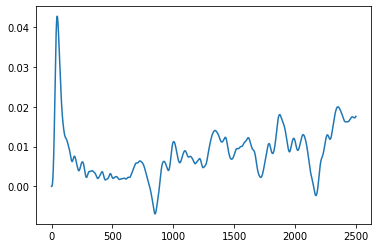

In [41]:
from matplotlib import pyplot as plt
time_list = list(range(total_step+1))
# time_list *= delta_t
plt.plot(time_list, output2400)
plt.show()

In [42]:
# importとconstの設定
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt #to draw graphs

# const
ele_size = 1/2*0.02*0.02
poi = 0.2
e = 9.8*1000000000*37
th = 0.98
row = 2400
nmode = 10
delta_t = 0.00004
pow_delta_t = delta_t*delta_t
total_time = 0.1
total_step = int(total_time/delta_t)
hc = 0.02 #減衰定数
load = 100*9.8 #外力最大値
load_time = 0.001
load_step = int(load_time/delta_t)
load_diff = load/load_step
fixed_node_count = 50
alpha = 0.58332

In [43]:
print(total_step)

2500


In [44]:
# ファイル読み込み:nodeとeleの設定
node_path = "./one_hole_1_1.1.node"
ele_path = "./one_hole_1_1.1.ele"
# node_path = "~/src/github.com/shirafuji/graduation_thesis/vibration_simulation/one_hole_1_1.1.node"
# ele_path = '~/src/github.com/shirafuji/graduation_thesis/vibration_simulation/one_hole_1_1.1.ele'
with open(node_path) as f_node:
    s_line = f_node.readline()
    number_list = s_line.split()
    nnode_str = number_list[0]
    nnode = int(nnode_str)
    position = np.zeros((nnode, 2), dtype=np.float)
    for i in range(nnode):
        s_line = f_node.readline()
        number_list = s_line.split()
        x_str = number_list[1]
        y_str = number_list[2]
        x = float(x_str)
        y = float(y_str)
        position[i][0] = x*0.02
        position[i][1] = y*0.02
with open(ele_path) as f_ele:
    s_line = f_ele.readline()
    number_list = s_line.split()
    nele_str = number_list[0]
    nele = int(nele_str)
    eles = np.zeros((nele, 3), dtype=np.int64)
    for h in range(nele):
        s_line = f_ele.readline()
        number_list = s_line.split()
        i_str = number_list[1]
        j_str = number_list[2]
        k_str = number_list[3]
        i = int(i_str)
        j = int(j_str)
        k = k_str
        eles[h][0] = i
        eles[h][1] = j
        eles[h][2] = k

In [45]:
# 全体剛性行列と全体質量行列・全体集中質量行列の宣言(固定したものを抜いたものも)
kt = np.zeros((2*nnode, 2*nnode))
mt = np.zeros((2*nnode, 2*nnode))
imt = np.zeros((2*nnode, 2*nnode))
unfixed_kt = np.zeros((2*(nnode-fixed_node_count), 2*(nnode-fixed_node_count)))
unfixed_mt = np.zeros((2*(nnode-fixed_node_count), 2*(nnode-fixed_node_count)))
unfixed_imt = np.zeros((2*(nnode-fixed_node_count), 2*(nnode-fixed_node_count)))

In [46]:
# 剛性行列と質量行列計算の定義
def calc_ke(ele, position, kt):
    i = ele[0]
    j = ele[1]
    k = ele[2]
    xi = position[i-1][0]
    yi = position[i-1][1]
    xj = position[j-1][0]
    yj = position[j-1][1]
    xk = position[k-1][0]
    yk = position[k-1][1]
    # ひずみ-変位関係
    b = np.zeros((3, 6))
    b[0][0] = yj-yk
    b[0][2] = yk-yi
    b[0][4] = yi-yj
    b[1][1] = xk-xj
    b[1][3] = xi-xk
    b[1][5] = xj-xi
    b[2][0] = xk-xj
    b[2][1] = yj-yk
    b[2][2] = xi-xk
    b[2][3] = yk-yi
    b[2][4] = xj-xi
    b[2][5] = yi-yj
    # 応力-ひずみ関係
    d = np.zeros((3, 3))
    d[0][0] = 1 - poi
    d[0][1] = poi
    d[1][0] = poi
    d[1][1] = 1 - poi
    d[2][2] = (1-2*poi)/2
    d = d*e/(1+poi)/(1-2*poi)
    ke = th*ele_size*np.dot(np.dot(b.T, d), b)
    # 全体剛性行列への組み込み
    kt[2*i-1-1][2*i-1-1] += ke[1-1][1-1]
    kt[2*i-1-1][2*i-1] += ke[1-1][2-1]
    kt[2*i-1][2*i-1-1] += ke[2-1][1-1]
    kt[2*i-1][2*i-1] += ke[2-1][2-1]
    kt[2*i-1-1][2*j-1-1] += ke[1-1][3-1]
    kt[2*i-1-1][2*j-1] += ke[1-1][4-1]
    kt[2*i-1][2*j-1-1] += ke[2-1][3-1]
    kt[2*i-1][2*j-1] += ke[2-1][4-1]
    kt[2*i-1-1][2*k-1-1] += ke[1-1][5-1]
    kt[2*i-1-1][2*k-1] += ke[1-1][6-1]
    kt[2*i-1][2*k-1-1] += ke[2-1][5-1]
    kt[2*i-1][2*k-1] += ke[2-1][6-1]

    kt[2*j-1-1][2*i-1-1] += ke[3-1][1-1]
    kt[2*j-1-1][2*i-1] += ke[3-1][2-1]
    kt[2*j-1][2*i-1-1] += ke[4-1][1-1]
    kt[2*j-1][2*i-1] += ke[4-1][2-1]
    kt[2*j-1-1][2*j-1-1] += ke[3-1][3-1]
    kt[2*j-1-1][2*j-1] += ke[3-1][4-1]
    kt[2*j-1][2*j-1-1] += ke[4-1][3-1]
    kt[2*j-1][2*j-1] += ke[4-1][4-1]
    kt[2*j-1-1][2*k-1-1] += ke[3-1][5-1]
    kt[2*j-1-1][2*k-1] += ke[3-1][6-1]
    kt[2*j-1][2*k-1-1] += ke[4-1][5-1]
    kt[2*j-1][2*k-1] += ke[4-1][6-1]

    kt[2*k-1-1][2*i-1-1] += ke[5-1][1-1]
    kt[2*k-1-1][2*i-1] += ke[5-1][2-1]
    kt[2*k-1][2*i-1-1] += ke[6-1][1-1]
    kt[2*k-1][2*i-1] += ke[6-1][2-1]
    kt[2*k-1-1][2*j-1-1] += ke[5-1][3-1]
    kt[2*k-1-1][2*j-1] += ke[5-1][4-1]
    kt[2*k-1][2*j-1-1] += ke[6-1][3-1]
    kt[2*k-1][2*j-1] += ke[6-1][4-1]
    kt[2*k-1-1][2*k-1-1] += ke[5-1][5-1]
    kt[2*k-1-1][2*k-1] += ke[5-1][6-1]
    kt[2*k-1][2*k-1-1] += ke[6-1][5-1]
    kt[2*k-1][2*k-1] += ke[6-1][6-1]

    return kt

def calc_me(ele, mt):
    i = ele[0]
    j = ele[1]
    k = ele[2]
    me = np.zeros((6, 6))
    me[0][0] = 1/6
    me[0][2] = 1/12
    me[0][4] = 1/12
    me[1][1] = 1/6
    me[1][3] = 1/12
    me[1][5] = 1/12
    me[2][0] = 1/12
    me[2][2] = 1/6
    me[2][4] = 1/12
    me[3][1] = 1/12
    me[3][3] = 1/6
    me[3][5] = 1/12
    me[4][0] = 1/12
    me[4][2] = 1/12
    me[4][4] = 1/6
    me[5][1] = 1/12
    me[5][3] = 1/12
    me[5][5] = 1/6
    me = ele_size*th*row*me
    # 全体質量行列への組み込み
    mt[2*i-1-1][2*i-1-1] += me[1-1][1-1]
    mt[2*i-1-1][2*i-1] += me[1-1][2-1]
    mt[2*i-1][2*i-1-1] += me[2-1][1-1]
    mt[2*i-1][2*i-1] += me[2-1][2-1]
    mt[2*i-1-1][2*j-1-1] += me[1-1][3-1]
    mt[2*i-1-1][2*j-1] += me[1-1][4-1]
    mt[2*i-1][2*j-1-1] += me[2-1][3-1]
    mt[2*i-1][2*j-1] += me[2-1][4-1]
    mt[2*i-1-1][2*k-1-1] += me[1-1][5-1]
    mt[2*i-1-1][2*k-1] += me[1-1][6-1]
    mt[2*i-1][2*k-1-1] += me[2-1][5-1]
    mt[2*i-1][2*k-1] += me[2-1][6-1]

    mt[2*j-1-1][2*i-1-1] += me[3-1][1-1]
    mt[2*j-1-1][2*i-1] += me[3-1][2-1]
    mt[2*j-1][2*i-1-1] += me[4-1][1-1]
    mt[2*j-1][2*i-1] += me[4-1][2-1]
    mt[2*j-1-1][2*j-1-1] += me[3-1][3-1]
    mt[2*j-1-1][2*j-1] += me[3-1][4-1]
    mt[2*j-1][2*j-1-1] += me[4-1][3-1]
    mt[2*j-1][2*j-1] += me[4-1][4-1]
    mt[2*j-1-1][2*k-1-1] += me[3-1][5-1]
    mt[2*j-1-1][2*k-1] += me[3-1][6-1]
    mt[2*j-1][2*k-1-1] += me[4-1][5-1]
    mt[2*j-1][2*k-1] += me[4-1][6-1]

    mt[2*k-1-1][2*i-1-1] += me[5-1][1-1]
    mt[2*k-1-1][2*i-1] += me[5-1][2-1]
    mt[2*k-1][2*i-1-1] += me[6-1][1-1]
    mt[2*k-1][2*i-1] += me[6-1][2-1]
    mt[2*k-1-1][2*j-1-1] += me[5-1][3-1]
    mt[2*k-1-1][2*j-1] += me[5-1][4-1]
    mt[2*k-1][2*j-1-1] += me[6-1][3-1]
    mt[2*k-1][2*j-1] += me[6-1][4-1]
    mt[2*k-1-1][2*k-1-1] += me[5-1][5-1]
    mt[2*k-1-1][2*k-1] += me[5-1][6-1]
    mt[2*k-1][2*k-1-1] += me[6-1][5-1]
    mt[2*k-1][2*k-1] += me[6-1][6-1]

    return mt

def calc_ime(ele, imt):
    i = ele[0]
    j = ele[1]
    k = ele[2]
    ime = np.zeros((6, 6))
    for h in range(6):
        ime[h][h] = 1/3
    ime = ele_size*th*row*ime
    imt[2*i-1-1][2*i-1-1] += ime[1-1][1-1]
    imt[2*i-1][2*i-1] += ime[2-1][2-1]
    imt[2*j-1-1][2*j-1-1] += ime[3-1][3-1]
    imt[2*j-1][2*j-1] += ime[4-1][4-1]
    imt[2*k-1-1][2*k-1-1] += ime[5-1][5-1]
    imt[2*k-1][2*k-1] += ime[6-1][6-1]
    return imt

In [47]:
# 合成行列と質量行列の組み込み繰り返し
for h in range(nele):
    ele = eles[h]
    kt = calc_ke(ele, position, kt)
    mt = calc_me(ele, mt)
    imt = calc_ime(ele, imt)

In [48]:
# 外力生成(線形の増減)(左辺中心4点に荷重がかかるとする)
ft = np.zeros((total_step, 2*(nnode), 1))
for i in range(load_step):
    ft[i+1][2300][0] = ft[i][2300][0] + load_diff
    ft[i+1][2400][0] = ft[i][2400][0] + load_diff
    ft[i+1][2500][0] = ft[i][2500][0] + load_diff
    ft[i+1][2600][0] = ft[i][2600][0] + load_diff
for i in range(load_step):
    ft[load_step+i+1][2300][0] = ft[load_step+i][2300][0] - load_diff
    ft[load_step+i+1][2400][0] = ft[load_step+i][2400][0] - load_diff
    ft[load_step+i+1][2500][0] = ft[load_step+i][2500][0] - load_diff
    ft[load_step+i+1][2600][0] = ft[load_step+i][2600][0] - load_diff

In [49]:
# タイムステップ毎の変位設定
u = np.zeros((total_step+1, 2*nnode, 1))

In [50]:
# 各タイムステップの計算
import time
ct = imt*alpha
left_matrix = imt+delta_t*ct/2
inv_left_matrix = np.linalg.inv(left_matrix)
for h in range(total_step-1):
    print(h)
    start = time.time()
    step = h+1
    right_matrix = pow_delta_t*ft[step] - pow_delta_t*np.dot(kt, u[step]) + np.dot(imt, (2*u[step]-u[step-1])) + delta_t*np.dot(ct, u[step-1])/2
    print(right_matrix)
    u[step+1] = np.dot(inv_left_matrix, right_matrix)
    elapsed_time = time.time() - start
    print(elapsed_time)
    print(u[step+1])

0
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
0.0840294361114502
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
1
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
0.09105682373046875
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
2
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
0.07458114624023438
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
3
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
0.08577489852905273
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
4
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
0.08286547660827637
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
5
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
0.1046290397644043
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
6
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
0.06100130081176758
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
7
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
0.05159187316894531
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
8
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
0.06627488136291504
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
9
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
0.08

[[-5.04561584e-81]
 [-1.66926095e-80]
 [ 4.59403902e-81]
 ...
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
0.0805060863494873
[[-3.21782970e-80]
 [-1.06456727e-79]
 [ 9.76612548e-81]
 ...
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
49
[[-1.45503579e-80]
 [-4.81386340e-80]
 [ 1.32476537e-80]
 ...
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
0.07393908500671387
[[-9.27945673e-80]
 [-3.07003013e-79]
 [ 2.81622006e-80]
 ...
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
50
[[-4.09442233e-80]
 [-1.35463706e-79]
 [ 3.72771260e-80]
 ...
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
0.04667258262634277
[[-2.61120826e-79]
 [-8.63916621e-79]
 [ 7.92446666e-80]
 ...
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
51
[[-1.12562056e-79]
 [-3.72419801e-79]
 [ 1.02476904e-79]
 ...
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
0.04914259910583496
[[-7.17861879e-79]
 [-2.37509858e-78]
 [ 2.17848019e-79]
 ...
 [ 0.00000

0.05292105674743652
[[-2.26806725e-069]
 [-7.51050959e-069]
 [ 6.87392033e-070]
 ...
 [ 2.05178616e-209]
 [ 3.57808838e-213]
 [ 3.64186049e-213]]
80
[[-6.61049224e-070]
 [-2.18908926e-069]
 [ 6.01006462e-070]
 ...
 [ 5.61466141e-209]
 [ 3.43063418e-213]
 [ 3.48769812e-213]]
0.05321359634399414
[[-4.21582597e-069]
 [-1.39608656e-068]
 [ 1.27763489e-069]
 ...
 [ 1.19357906e-208]
 [ 2.18787893e-212]
 [ 2.22427132e-212]]
81
[[-1.21894153e-069]
 [-4.03672290e-069]
 [ 1.10816247e-069]
 ...
 [ 3.15822714e-208]
 [ 2.02474673e-212]
 [ 2.05600787e-212]]
0.04913330078125
[[-7.77377111e-069]
 [-2.57441059e-068]
 [ 2.35576008e-069]
 ...
 [ 6.71383991e-208]
 [ 1.29127749e-211]
 [ 1.31121421e-211]]
82
[[-2.23020847e-069]
 [-7.38597982e-069]
 [ 2.02740704e-069]
 ...
 [ 1.72042960e-207]
 [ 1.15537681e-211]
 [ 1.17183038e-211]]
0.04616379737854004
[[-1.42231024e-068]
 [-4.71039136e-068]
 [ 4.30991367e-069]
 ...
 [ 3.65733318e-207]
 [ 7.36838861e-211]
 [ 7.47332087e-211]]
83
[[-4.04957181e-069]
 [-1.3411

[[-9.61897270e-063]
 [-3.18993310e-062]
 [ 8.72637642e-063]
 ...
 [ 7.40827982e-190]
 [ 1.30312394e-193]
 [ 1.27340118e-193]]
0.05030345916748047
[[-6.13447735e-062]
 [-2.03437237e-061]
 [ 1.85507539e-062]
 ...
 [ 1.57487105e-189]
 [ 8.31064247e-193]
 [ 8.12108627e-193]]
113
[[-1.48462065e-062]
 [-4.92369494e-062]
 [ 1.34674847e-062]
 ...
 [ 2.24758734e-189]
 [ 4.04805216e-193]
 [ 3.95069632e-193]]
0.0724942684173584
[[-9.46813348e-062]
 [-3.14007494e-061]
 [ 2.86295229e-062]
 ...
 [ 4.77797857e-189]
 [ 2.58163580e-192]
 [ 2.51954734e-192]]
114
[[-2.28251769e-062]
 [-7.57029407e-062]
 [ 2.07038254e-062]
 ...
 [ 6.74046927e-189]
 [ 1.24260325e-192]
 [ 1.21117784e-192]]
0.0513613224029541
[[-1.45567032e-061]
 [-4.82793735e-061]
 [ 4.40127207e-062]
 ...
 [ 1.43290617e-188]
 [ 7.92467318e-192]
 [ 7.72425838e-192]]
115
[[-3.49586735e-062]
 [-1.15951587e-061]
 [ 3.17071014e-062]
 ...
 [ 1.99872241e-188]
 [ 3.77019705e-192]
 [ 3.67017931e-192]]
0.05256462097167969
[[-2.22948123e-061]
 [-7.394

[[-1.01720759e-057]
 [-3.37933994e-057]
 [ 9.20363786e-058]
 ...
 [ 3.29292090e-177]
 [ 1.04856868e-180]
 [ 9.86652087e-181]]
0.05412888526916504
[[-6.48721764e-057]
 [-2.15516615e-056]
 [ 1.95653284e-057]
 ...
 [ 7.00017536e-177]
 [ 6.68722223e-180]
 [ 6.29235061e-180]]
143
[[-1.43136832e-057]
 [-4.75556835e-057]
 [ 1.29496577e-057]
 ...
 [ 7.69104664e-177]
 [ 2.49009806e-180]
 [ 2.34017617e-180]]
0.09828758239746094
[[-9.12851801e-057]
 [-3.03285260e-056]
 [ 2.75287131e-057]
 ...
 [ 1.63498234e-176]
 [ 1.58805422e-179]
 [ 1.49244188e-179]]
144
[[-2.00931740e-057]
 [-6.67618726e-057]
 [ 1.81765770e-057]
 ...
 [ 1.78474504e-176]
 [ 5.87427677e-180]
 [ 5.51382038e-180]]
0.0682077407836914
[[-1.28143747e-056]
 [-4.25772281e-056]
 [ 3.86402316e-057]
 ...
 [ 3.79405659e-176]
 [ 3.74630627e-179]
 [ 3.51642606e-179]]
145
[[-2.81394526e-057]
 [-9.35028285e-057]
 [ 2.54528008e-057]
 ...
 [ 4.11527570e-176]
 [ 1.37675785e-179]
 [ 1.29069334e-179]]
0.06877565383911133
[[-1.79458701e-056]
 [-5.96

[[-1.99123182e-053]
 [-6.63075637e-053]
 [ 1.79535623e-053]
 ...
 [ 1.26403675e-166]
 [ 6.41902529e-170]
 [ 5.81576127e-170]]
0.05144071578979492
[[-1.26990344e-052]
 [-4.22874937e-052]
 [ 3.81661412e-053]
 ...
 [ 2.68712161e-166]
 [ 4.09371837e-169]
 [ 3.70898815e-169]]
175
[[-2.63036173e-053]
 [-8.75975340e-053]
 [ 2.37132994e-053]
 ...
 [ 2.50101875e-166]
 [ 1.28642111e-169]
 [ 1.16421550e-169]]
0.058361053466796875
[[-1.67750704e-052]
 [-5.58651225e-052]
 [ 5.04103375e-053]
 ...
 [ 5.31672953e-166]
 [ 8.20412056e-169]
 [ 7.42475714e-169]]
176
[[-3.46907253e-053]
 [-1.15538078e-052]
 [ 3.12706781e-053]
 ...
 [ 4.92826417e-166]
 [ 2.56730906e-169]
 [ 2.32082736e-169]]
0.059218645095825195
[[-2.21239290e-052]
 [-7.36841394e-052]
 [ 6.64760061e-053]
 ...
 [ 1.04766298e-165]
 [ 1.63729535e-168]
 [ 1.48010222e-168]]
177
[[-4.56797193e-053]
 [-1.52149576e-052]
 [ 4.11712894e-053]
 ...
 [ 9.67192706e-166]
 [ 5.10242771e-169]
 [ 4.60741937e-169]]
0.05016040802001953
[[-2.91321342e-052]
 [-9

0.06512284278869629
[[-3.62776234e-049]
 [-1.21133401e-048]
 [ 1.08590479e-049]
 ...
 [ 7.52679075e-158]
 [ 1.64383565e-160]
 [ 1.44117521e-160]]
206
[[-7.20213853e-050]
 [-2.40507148e-049]
 [ 6.46657732e-050]
 ...
 [ 6.29443881e-158]
 [ 4.63078772e-161]
 [ 4.05584574e-161]]
0.05557060241699219
[[-4.59314701e-049]
 [-1.53382872e-048]
 [ 1.37468152e-049]
 ...
 [ 1.33808788e-157]
 [ 2.95327404e-160]
 [ 2.58660614e-160]]
207
[[-9.10815767e-050]
 [-3.04185633e-049]
 [ 8.17677577e-050]
 ...
 [ 1.11578874e-157]
 [ 8.29515754e-161]
 [ 7.25807003e-161]]
0.05686140060424805
[[-5.80870625e-049]
 [-1.93993676e-048]
 [ 1.73823988e-049]
 ...
 [ 2.37197220e-157]
 [ 5.29021733e-160]
 [ 4.62881719e-160]]
208
[[-1.15054067e-049]
 [-3.84283712e-049]
 [ 1.03274187e-049]
 ...
 [ 1.97228630e-157]
 [ 1.48160344e-160]
 [ 1.29509088e-160]]
0.054822444915771484
[[-7.33754624e-049]
 [-2.45076039e-048]
 [ 2.19542904e-049]
 ...
 [ 4.19273658e-157]
 [ 9.44889130e-160]
 [ 8.25941182e-160]]
209
[[-1.45171220e-049]
 

0.05428957939147949
[[-5.00739133e-046]
 [-1.67769136e-045]
 [ 1.49140736e-046]
 ...
 [ 3.35230800e-150]
 [ 1.00756426e-152]
 [ 8.56655813e-153]]
239
[[-9.61752956e-047]
 [-3.22264355e-046]
 [ 8.59209440e-047]
 ...
 [ 2.58394475e-150]
 [ 2.61183387e-153]
 [ 2.21872879e-153]]
0.08019566535949707
[[-6.13355699e-046]
 [-2.05523339e-045]
 [ 1.82652937e-046]
 ...
 [ 5.49301575e-150]
 [ 1.66569095e-152]
 [ 1.41498910e-152]]
240
[[-1.17703730e-046]
 [-3.94445842e-046]
 [ 1.05136850e-046]
 ...
 [ 4.22510226e-150]
 [ 4.30860017e-153]
 [ 3.65697120e-153]]
0.058049678802490234
[[-7.50652788e-046]
 [-2.51556913e-045]
 [ 2.23502602e-046]
 ...
 [ 8.98183028e-150]
 [ 2.74779968e-152]
 [ 2.33222483e-152]]
241
[[-1.43928178e-046]
 [-4.82382567e-046]
 [ 1.28540359e-046]
 ...
 [ 6.89423746e-150]
 [ 7.09257485e-153]
 [ 6.01474985e-153]]
0.05056643486022949
[[-9.17898592e-046]
 [-3.07638354e-045]
 [ 2.73254379e-046]
 ...
 [ 1.46559461e-149]
 [ 4.52327303e-152]
 [ 3.83589265e-152]]
242
[[-1.75846357e-046]
 

[[-3.48826376e-044]
 [-1.17315506e-043]
 [ 3.09971075e-044]
 ...
 [ 4.40452873e-144]
 [ 5.75258666e-147]
 [ 4.76614969e-147]]
0.08709478378295898
[[-2.22463206e-043]
 [-7.48176896e-043]
 [ 6.58944429e-044]
 ...
 [ 9.36325967e-144]
 [ 3.66869869e-146]
 [ 3.03960082e-146]]
271
[[-4.16959650e-044]
 [-1.40247457e-043]
 [ 3.70447348e-044]
 ...
 [ 6.80189687e-144]
 [ 8.95250631e-147]
 [ 7.41177945e-147]]
0.07492589950561523
[[-2.65915042e-043]
 [-8.94424877e-043]
 [ 7.87506434e-044]
 ...
 [ 1.44596461e-143]
 [ 5.70943997e-146]
 [ 4.72684502e-146]]
272
[[-4.98065909e-044]
 [-1.67549392e-043]
 [ 4.42424950e-044]
 ...
 [ 1.04871543e-143]
 [ 1.39094364e-146]
 [ 1.15070000e-146]]
0.07087826728820801
[[-3.17640369e-043]
 [-1.06854233e-042]
 [ 9.40518257e-044]
 ...
 [ 2.22938603e-143]
 [ 8.87071055e-146]
 [ 7.33856234e-146]]
273
[[-5.94551928e-044]
 [-2.00032754e-043]
 [ 5.28034918e-044]
 ...
 [ 1.61431253e-143]
 [ 2.15756211e-146]
 [ 1.78357751e-146]]
0.052461862564086914
[[-3.79174102e-043]
 [-1.

[[-7.70967136e-042]
 [-2.60400580e-041]
 [ 6.80881313e-042]
 ...
 [ 2.28564473e-138]
 [ 3.76678527e-141]
 [ 3.05119628e-141]]
0.06518006324768066
[[-4.91682488e-041]
 [-1.66069861e-040]
 [ 1.44743488e-041]
 ...
 [ 4.85888194e-138]
 [ 2.40225850e-140]
 [ 1.94589330e-140]]
303
[[-9.03905905e-042]
 [-3.05345071e-041]
 [ 7.98124523e-042]
 ...
 [ 3.36987873e-138]
 [ 5.59167408e-141]
 [ 4.52642101e-141]]
0.07526326179504395
[[-5.76463877e-041]
 [-1.94733105e-040]
 [ 1.69667350e-041]
 ...
 [ 7.16377428e-138]
 [ 3.56607707e-140]
 [ 2.88671442e-140]]
304
[[-1.05919586e-041]
 [-3.57853925e-041]
 [ 9.35051040e-042]
 ...
 [ 4.96204955e-138]
 [ 8.28978970e-141]
 [ 6.70612380e-141]]
0.06906342506408691
[[-6.75499680e-041]
 [-2.28220504e-040]
 [ 1.98775538e-041]
 ...
 [ 1.05484517e-137]
 [ 5.28679400e-140]
 [ 4.27681477e-140]]
305
[[-1.24049931e-041]
 [-4.19167956e-041]
 [ 1.09488099e-041]
 ...
 [ 7.29714468e-138]
 [ 1.22738183e-140]
 [ 9.92256234e-141]]
0.06711769104003906
[[-7.91125536e-041]
 [-2.6

[[-7.30297581e-040]
 [-2.47768943e-039]
 [ 6.40878206e-040]
 ...
 [ 1.54316508e-133]
 [ 3.09041216e-136]
 [ 2.45696865e-136]]
0.06651616096496582
[[-4.65745575e-039]
 [-1.58014064e-038]
 [ 1.36239526e-039]
 ...
 [ 3.28049975e-133]
 [ 1.97090313e-135]
 [ 1.56692601e-135]]
333
[[-8.43648213e-040]
 [-2.86270375e-039]
 [ 7.40186092e-040]
 ...
 [ 2.19659033e-133]
 [ 4.42619702e-136]
 [ 3.51689280e-136]]
0.06159257888793945
[[-5.38034675e-039]
 [-1.82568262e-038]
 [ 1.57350650e-039]
 ...
 [ 4.66956782e-133]
 [ 2.82279680e-135]
 [ 2.24289016e-135]]
334
[[-9.74155534e-040]
 [-3.30606618e-039]
 [ 8.54498802e-040]
 ...
 [ 3.12338148e-133]
 [ 6.33250790e-136]
 [ 5.02863661e-136]]
0.06941771507263184
[[-6.21265414e-039]
 [-2.10843598e-038]
 [ 1.81651538e-039]
 ...
 [ 6.63976413e-133]
 [ 4.03854211e-135]
 [ 3.20700124e-135]]
335
[[-1.12435056e-039]
 [-3.81639589e-039]
 [ 9.86025754e-040]
 ...
 [ 4.43652656e-133]
 [ 9.05011842e-136]
 [ 7.18250337e-136]]
0.06878781318664551
[[-7.17051938e-039]
 [-2.4

0.0540618896484375
[[-3.34962370e-037]
 [-1.14222458e-036]
 [ 9.72858561e-038]
 ...
 [ 1.16678712e-128]
 [ 8.41297508e-131]
 [ 6.57427489e-131]]
364
[[-5.99052437e-038]
 [-2.04312539e-037]
 [ 5.21837904e-038]
 ...
 [ 7.58081720e-129]
 [ 1.83225881e-131]
 [ 1.43105720e-131]]
0.0759425163269043
[[-3.82044291e-037]
 [-1.30299844e-036]
 [ 1.10933634e-037]
 ...
 [ 1.61154948e-128]
 [ 1.16851877e-130]
 [ 9.12653384e-131]]
365
[[-6.82997498e-038]
 [-2.32982988e-037]
 [ 5.94819890e-038]
 ...
 [ 1.04612496e-128]
 [ 2.54261915e-131]
 [ 1.98483397e-131]]
0.053908586502075195
[[-4.35580057e-037]
 [-1.48584356e-036]
 [ 1.26448331e-037]
 ...
 [ 2.22387915e-128]
 [ 1.62154942e-130]
 [ 1.26582323e-130]]
366
[[-7.78414367e-038]
 [-2.65577375e-037]
 [ 6.77754712e-038]
 ...
 [ 1.44234368e-128]
 [ 3.52522132e-131]
 [ 2.75044350e-131]]
0.04664111137390137
[[-4.96431942e-037]
 [-1.69371350e-036]
 [ 1.44078828e-037]
 ...
 [ 3.06617103e-128]
 [ 2.24820165e-130]
 [ 1.75408891e-130]]
367
[[-8.86831070e-038]
 [-

[[-2.95913674e-036]
 [-1.01488993e-035]
 [ 2.55788709e-036]
 ...
 [ 1.11377861e-124]
 [ 3.17827111e-127]
 [ 2.44429855e-127]]
0.057858943939208984
[[-1.88718254e-035]
 [-6.47243677e-035]
 [ 5.43762170e-036]
 ...
 [ 2.36769902e-124]
 [ 2.02693497e-126]
 [ 1.55884569e-126]]
396
[[-3.33776289e-036]
 [-1.14496200e-035]
 [ 2.88442732e-036]
 ...
 [ 1.49872949e-124]
 [ 4.29873526e-127]
 [ 3.30444578e-127]]
0.05274510383605957
[[-2.12865048e-035]
 [-7.30196835e-035]
 [ 6.13178927e-036]
 ...
 [ 3.18603743e-124]
 [ 2.74150836e-126]
 [ 2.10740257e-126]]
397
[[-3.76363400e-036]
 [-1.29129324e-035]
 [ 3.25161441e-036]
 ...
 [ 2.01522445e-124]
 [ 5.80978829e-127]
 [ 4.46389018e-127]]
0.051978349685668945
[[-2.40024879e-035]
 [-8.23519242e-035]
 [ 6.91236496e-036]
 ...
 [ 4.28401561e-124]
 [ 3.70517890e-126]
 [ 2.84683552e-126]]
398
[[-4.24249582e-036]
 [-1.45586478e-035]
 [ 3.66437886e-036]
 ...
 [ 2.70770306e-124]
 [ 7.84605670e-127]
 [ 6.02560331e-127]]
0.04740333557128906
[[-2.70564179e-035]
 [-9

[[-1.19936859e-034]
 [-4.13932662e-034]
 [ 1.02791335e-034]
 ...
 [ 1.04547079e-120]
 [ 3.49234547e-123]
 [ 2.64733395e-123]]
0.057646751403808594
[[-7.64894516e-034]
 [-2.63984588e-033]
 [ 2.18516444e-034]
 ...
 [ 2.22248851e-120]
 [ 2.22723516e-122]
 [ 1.68833104e-122]]
428
[[-1.34006115e-034]
 [-4.62583766e-034]
 [ 1.14817592e-034]
 ...
 [ 1.37600576e-120]
 [ 4.61822756e-123]
 [ 3.49929265e-123]]
0.05739283561706543
[[-8.54620865e-034]
 [-2.95011715e-033]
 [ 2.44082169e-034]
 ...
 [ 2.92514818e-120]
 [ 2.94526383e-122]
 [ 2.23166571e-122]]
429
[[-1.49684750e-034]
 [-5.16811651e-034]
 [ 1.28215673e-034]
 ...
 [ 1.80988680e-120]
 [ 6.10311052e-123]
 [ 4.62242751e-123]]
0.04638957977294922
[[-9.54610995e-034]
 [-3.29595422e-033]
 [ 2.72564153e-034]
 ...
 [ 3.84750359e-120]
 [ 3.89224447e-122]
 [ 2.94794234e-122]]
430
[[-1.67152176e-034]
 [-5.77239396e-034]
 [ 1.43138051e-034]
 ...
 [ 2.37906710e-120]
 [ 8.06020783e-123]
 [ 6.10210371e-123]]
0.04599285125732422
[[-1.06600909e-033]
 [-3.

[[-3.66426535e-033]
 [-1.27325186e-032]
 [ 3.11195009e-033]
 ...
 [ 5.07955447e-117]
 [ 1.96263998e-119]
 [ 1.46829110e-119]]
0.07781577110290527
[[-2.33687666e-032]
 [-8.12013399e-032]
 [ 6.61546299e-033]
 ...
 [ 1.07982466e-116]
 [ 1.25166906e-118]
 [ 9.36399218e-119]]
460
[[-4.06070953e-033]
 [-1.41131910e-032]
 [ 3.44762541e-033]
 ...
 [ 6.55942514e-117]
 [ 2.54554476e-119]
 [ 1.90362502e-119]]
0.05501723289489746
[[-2.58970801e-032]
 [-9.00065457e-032]
 [ 7.32905014e-033]
 ...
 [ 1.39441935e-116]
 [ 1.62341522e-118]
 [ 1.21403241e-118]]
461
[[-4.49897478e-033]
 [-1.56398638e-032]
 [ 3.81859777e-033]
 ...
 [ 8.46576407e-117]
 [ 3.29971725e-119]
 [ 2.46664691e-119]]
0.04599308967590332
[[-2.86921065e-032]
 [-9.97428659e-032]
 [ 8.11767265e-033]
 ...
 [ 1.79967375e-116]
 [ 2.10438696e-118]
 [ 1.57309830e-118]]
462
[[-4.98335991e-033]
 [-1.73275836e-032]
 [ 4.22848297e-033]
 ...
 [ 1.09201300e-116]
 [ 4.27493653e-119]
 [ 3.19440496e-119]]
0.04600787162780762
[[-3.17812613e-032]
 [-1.1

[[-8.75918159e-032]
 [-3.06599355e-031]
 [ 7.36738777e-032]
 ...
 [ 1.39675451e-113]
 [ 6.17843787e-116]
 [ 4.56662758e-116]]
0.06351613998413086
[[-5.58614758e-031]
 [-1.95533022e-030]
 [ 1.56617811e-031]
 ...
 [ 2.96925640e-113]
 [ 3.94028431e-115]
 [ 2.91235606e-115]]
492
[[-9.63771514e-032]
 [-3.37430948e-031]
 [ 8.10380951e-032]
 ...
 [ 1.77407827e-113]
 [ 7.87955905e-116]
 [ 5.82185445e-116]]
0.07046866416931152
[[-6.14643030e-031]
 [-2.15195798e-030]
 [ 1.72272852e-031]
 ...
 [ 3.77138090e-113]
 [ 5.02517036e-115]
 [ 3.71287406e-115]]
493
[[-1.06021504e-031]
 [-3.71285625e-031]
 [ 8.91197612e-032]
 ...
 [ 2.25224665e-113]
 [ 1.00441193e-115]
 [ 7.41846742e-116]]
0.04961061477661133
[[-6.76149664e-031]
 [-2.36786539e-030]
 [ 1.89453064e-031]
 ...
 [ 4.78788344e-113]
 [ 6.40561357e-115]
 [ 4.73111025e-115]]
494
[[-1.16606702e-031]
 [-4.08452221e-031]
 [ 9.79869539e-032]
 ...
 [ 2.85792250e-113]
 [ 1.27970359e-115]
 [ 9.44832907e-116]]
0.05041050910949707
[[-7.43656518e-031]
 [-2.6

[[-1.54406762e-030]
 [-5.44599003e-030]
 [ 1.28597398e-030]
 ...
 [ 1.86547861e-110]
 [ 9.32729056e-113]
 [ 6.81965578e-113]]
0.05013394355773926
[[-9.84725516e-030]
 [-3.47316741e-029]
 [ 2.73375633e-030]
 ...
 [ 3.96568208e-110]
 [ 5.94845775e-112]
 [ 4.34921953e-112]]
523
[[-1.68858466e-030]
 [-5.95721911e-030]
 [ 1.40587588e-030]
 ...
 [ 2.33625889e-110]
 [ 1.17259259e-112]
 [ 8.57053268e-113]]
0.07038211822509766
[[-1.07689092e-029]
 [-3.79920256e-029]
 [ 2.98864685e-030]
 ...
 [ 4.96647881e-110]
 [ 7.47818182e-112]
 [ 5.46583717e-112]]
524
[[-1.84628540e-030]
 [-6.51523385e-030]
 [ 1.53667149e-030]
 ...
 [ 2.92459847e-110]
 [ 1.47349974e-112]
 [ 1.07662582e-112]]
0.046207427978515625
[[-1.17746420e-029]
 [-4.15507516e-029]
 [ 3.26669549e-030]
 ...
 [ 6.21718612e-110]
 [ 9.39721015e-112]
 [ 6.86615601e-112]]
525
[[-2.01834127e-030]
 [-7.12420557e-030]
 [ 1.67932455e-030]
 ...
 [ 3.65954276e-110]
 [ 1.85082340e-112]
 [ 1.35186743e-112]]
0.045972585678100586
[[-1.28719242e-029]
 [-4

 [ 3.44058602e-109]]
553
[[-2.27541575e-029]
 [-8.09086988e-029]
 [ 1.87556618e-029]
 ...
 [ 1.64921976e-107]
 [ 9.25232368e-110]
 [ 6.69690081e-110]]
0.08528804779052734
[[-1.45114107e-028]
 [-5.15993335e-028]
 [ 3.98712648e-029]
 ...
 [ 3.50595348e-107]
 [ 5.90064779e-109]
 [ 4.27093283e-109]]
554
[[-2.47486891e-029]
 [-8.80245971e-029]
 [ 2.03927322e-029]
 ...
 [ 2.03972983e-107]
 [ 1.14844198e-109]
 [ 8.30989760e-110]]
0.05518794059753418
[[-1.57834186e-028]
 [-5.61374810e-028]
 [ 4.33513910e-029]
 ...
 [ 4.33610977e-107]
 [ 7.32416190e-109]
 [ 5.29961777e-109]]
555
[[-2.69135888e-029]
 [-9.57505068e-029]
 [ 2.21690049e-029]
 ...
 [ 2.52174689e-107]
 [ 1.42494827e-109]
 [ 1.03074104e-109]]
0.05563974380493164
[[-1.71640783e-028]
 [-6.10646619e-028]
 [ 4.71274369e-029]
 ...
 [ 5.36079395e-107]
 [ 9.08757425e-109]
 [ 6.57352689e-109]]
556
[[-2.92630272e-029]
 [-1.04137362e-028]
 [ 2.40960022e-029]
 ...
 [ 3.11648947e-107]
 [ 1.76734579e-109]
 [ 1.27801561e-109]]
0.09543681144714355
[

[[-3.34628882e-028]
 [-1.20086832e-027]
 [ 2.72662399e-028]
 ...
 [ 1.50949761e-104]
 [ 9.50447588e-107]
 [ 6.81083438e-107]]
0.07820391654968262
[[-2.13408787e-027]
 [-7.65850963e-027]
 [ 5.79632691e-028]
 ...
 [ 3.20892857e-104]
 [ 6.06145727e-106]
 [ 4.34359370e-106]]
587
[[-3.62079063e-028]
 [-1.29975207e-027]
 [ 2.94923813e-028]
 ...
 [ 1.84488478e-104]
 [ 1.16556825e-106]
 [ 8.34992742e-107]]
0.055830955505371094
[[-2.30915076e-027]
 [-8.28913841e-027]
 [ 6.26956575e-028]
 ...
 [ 3.92190318e-104]
 [ 7.43338427e-106]
 [ 5.32514669e-106]]
588
[[-3.91722926e-028]
 [-1.40657038e-027]
 [ 3.18955288e-028]
 ...
 [ 2.25402534e-104]
 [ 1.42888531e-106]
 [ 1.02332945e-106]]
0.04592704772949219
[[-2.49820380e-027]
 [-8.97036973e-027]
 [ 6.78043298e-028]
 ...
 [ 4.79166463e-104]
 [ 9.11268263e-106]
 [ 6.52625961e-106]]
589
[[-4.23731124e-028]
 [-1.52194324e-027]
 [ 3.44893779e-028]
 ...
 [ 2.75297055e-104]
 [ 1.75108676e-106]
 [ 1.25371591e-106]]
0.04631686210632324
[[-2.70233533e-027]
 [-9.

[[-3.88421455e-027]
 [-1.40720547e-026]
 [ 3.12815537e-027]
 ...
 [ 7.88036660e-102]
 [ 5.51469532e-104]
 [ 3.91608143e-104]]
0.05015277862548828
[[-2.47714875e-026]
 [-8.97441999e-026]
 [ 6.64991257e-027]
 ...
 [ 1.67522846e-101]
 [ 3.51698405e-103]
 [ 2.49747177e-103]]
619
[[-4.18390226e-027]
 [-1.51624227e-026]
 [ 3.36825170e-027]
 ...
 [ 9.53247287e-102]
 [ 6.69228455e-104]
 [ 4.75100496e-104]]
0.06441497802734375
[[-2.66827388e-026]
 [-9.66979962e-026]
 [ 7.16031548e-027]
 ...
 [ 2.02643743e-101]
 [ 4.26798883e-103]
 [ 3.02994230e-103]]
620
[[-4.50610895e-027]
 [-1.63350987e-026]
 [ 3.62628881e-027]
 ...
 [ 1.15274227e-101]
 [ 8.11881090e-104]
 [ 5.76215111e-104]]
0.045946359634399414
[[-2.87376045e-026]
 [-1.04176710e-025]
 [ 7.70885736e-027]
 ...
 [ 2.45052896e-101]
 [ 5.17775267e-103]
 [ 3.67479840e-103]]
621
[[-4.85248124e-027]
 [-1.75961310e-026]
 [ 3.90357072e-027]
 ...
 [ 1.39356352e-101]
 [ 9.84636742e-104]
 [ 6.98633852e-104]]
0.0641634464263916
[[-3.09465856e-026]
 [-1.1

[[-4.21430463e-026]
 [-1.54272661e-025]
 [ 3.35159451e-026]
 ...
 [ 3.60217356e-099]
 [ 2.79474163e-101]
 [ 1.96726713e-101]]
0.06658506393432617
[[-2.68766292e-025]
 [-9.83870291e-025]
 [ 7.12490520e-026]
 ...
 [ 7.65759255e-099]
 [ 1.78233994e-100]
 [ 1.25462001e-100]]
652
[[-4.52038470e-026]
 [-1.65530947e-025]
 [ 3.59361825e-026]
 ...
 [ 4.31582802e-099]
 [ 3.35862721e-101]
 [ 2.36358847e-101]]
0.054511308670043945
[[-2.88286477e-025]
 [-1.05566974e-024]
 [ 7.63940544e-026]
 ...
 [ 9.17469742e-099]
 [ 2.14195665e-100]
 [ 1.50737302e-100]]
653
[[-4.84810719e-026]
 [-1.77589390e-025]
 [ 3.85264990e-026]
 ...
 [ 5.16944709e-099]
 [ 4.03515585e-101]
 [ 2.83895808e-101]]
0.04731392860412598
[[-3.09186902e-025]
 [-1.13257218e-024]
 [ 8.19006155e-026]
 ...
 [ 1.09893426e-098]
 [ 2.57341121e-100]
 [ 1.81053888e-100]]
654
[[-5.19896065e-026]
 [-1.90503332e-025]
 [ 4.12985154e-026]
 ...
 [ 6.19020299e-099]
 [ 4.84660435e-101]
 [ 3.40898472e-101]]
0.04622650146484375
[[-3.31562500e-025]
 [-1.

0.059895992279052734
[[-2.09199560e-24]
 [-7.73487365e-24]
 [ 5.48028568e-25]
 ...
 [ 1.54351065e-96]
 [ 3.92773138e-98]
 [ 2.74414176e-98]]
682
[[-3.50627489e-25]
 [-1.29684047e-24]
 [ 2.75444621e-25]
 ...
 [ 8.63071686e-97]
 [ 7.34206632e-99]
 [ 5.12835015e-99]]
0.06846952438354492
[[-2.23611861e-24]
 [-8.27056979e-24]
 [ 5.85547209e-25]
 ...
 [ 1.83473983e-96]
 [ 4.68238563e-98]
 [ 3.27059332e-98]]
683
[[-3.74741426e-25]
 [-1.38650259e-24]
 [ 2.94268972e-25]
 ...
 [ 1.02565758e-96]
 [ 8.75049172e-99]
 [ 6.11063899e-99]]
0.04618024826049805
[[-2.38990468e-24]
 [-8.84238784e-24]
 [ 6.25564497e-25]
 ...
 [ 2.18036907e-96]
 [ 5.58060563e-98]
 [ 3.89704573e-98]]
684
[[-4.00469327e-25]
 [-1.48220021e-24]
 [ 3.14344774e-25]
 ...
 [ 1.21856555e-96]
 [ 1.04264314e-98]
 [ 7.27922022e-99]]
0.04600858688354492
[[-2.55398377e-24]
 [-9.45269719e-24]
 [ 6.68242149e-25]
 ...
 [ 2.59045777e-96]
 [ 6.64943226e-98]
 [ 4.64230568e-98]]
685
[[-4.27916225e-25]
 [-1.58432855e-24]
 [ 3.35752879e-25]
 ...
 

0.06527185440063477
[[-1.67158296e-23]
 [-6.25006423e-23]
 [ 4.32167452e-24]
 ...
 [ 3.45046283e-94]
 [ 9.61451566e-96]
 [ 6.66676563e-96]]
714
[[-2.79209767e-24]
 [-1.04434332e-23]
 [ 2.16467989e-24]
 ...
 [ 1.91454834e-94]
 [ 1.78318874e-96]
 [ 1.23619157e-96]]
0.0646977424621582
[[-1.78065376e-23]
 [-6.66027509e-23]
 [ 4.60173181e-24]
 ...
 [ 4.06999576e-94]
 [ 1.13722445e-95]
 [ 7.88378285e-96]]
715
[[-2.97397869e-24]
 [-1.11277390e-23]
 [ 2.30472129e-24]
 ...
 [ 2.25778762e-94]
 [ 2.10869856e-96]
 [ 1.46151688e-96]]
0.04596662521362305
[[-1.89664795e-23]
 [-7.09668955e-23]
 [ 4.89943537e-24]
 ...
 [ 4.79966259e-94]
 [ 1.34481758e-95]
 [ 9.32078974e-96]]
716
[[-3.16738544e-24]
 [-1.18556848e-23]
 [ 2.45357162e-24]
 ...
 [ 2.66195226e-94]
 [ 2.49304651e-96]
 [ 1.72751078e-96]]
0.045989990234375
[[-2.01999266e-23]
 [-7.56093524e-23]
 [ 5.21586521e-24]
 ...
 [ 5.65884610e-94]
 [ 1.58993458e-95]
 [ 1.10171596e-95]]
717
[[-3.37302776e-24]
 [-1.26299765e-23]
 [ 2.61176911e-24]
 ...
 [ 3.

[[-2.12646965e-23]
 [-8.05131888e-23]
 [ 1.62547705e-23]
 ...
 [ 3.92912360e-92]
 [ 4.00085521e-94]
 [ 2.75336178e-94]]
0.053403615951538086
[[-1.35615105e-22]
 [-5.13470979e-22]
 [ 3.45548064e-23]
 ...
 [ 8.35263130e-92]
 [ 2.55153606e-93]
 [ 1.75595004e-93]]
748
[[-2.25770657e-23]
 [-8.55145748e-23]
 [ 1.72504002e-23]
 ...
 [ 4.60008031e-92]
 [ 4.69643540e-94]
 [ 3.23136050e-94]]
0.056912899017333984
[[-1.43984709e-22]
 [-5.45367201e-22]
 [ 3.66713413e-23]
 ...
 [ 9.77896820e-92]
 [ 2.99514070e-93]
 [ 2.06079261e-93]]
749
[[-2.39681895e-23]
 [-9.08182096e-23]
 [ 1.83052936e-23]
 ...
 [ 5.38448349e-92]
 [ 5.51177151e-94]
 [ 3.79153480e-94]]
0.04607868194580078
[[-1.52856568e-22]
 [-5.79191008e-22]
 [ 3.89138607e-23]
 ...
 [ 1.14464725e-91]
 [ 3.51511940e-93]
 [ 2.41804245e-93]]
750
[[-2.54426585e-23]
 [-9.64418462e-23]
 [ 1.94228751e-23]
 ...
 [ 6.30132440e-92]
 [ 6.46727960e-94]
 [ 4.44787348e-94]]
0.04593658447265625
[[-1.62259960e-22]
 [-6.15055619e-22]
 [ 4.12896440e-23]
 ...
 [ 1

0.06773185729980469
[[-9.32605897e-22]
 [-3.57668995e-21]
 [ 2.34155641e-22]
 ...
 [ 1.36301374e-89]
 [ 4.53397920e-91]
 [ 3.09880285e-91]]
781
[[-1.54799750e-22]
 [-5.93918388e-22]
 [ 1.16546738e-22]
 ...
 [ 7.45689486e-90]
 [ 8.28918757e-92]
 [ 5.66419614e-92]]
0.061490774154663086
[[-9.87231785e-22]
 [-3.78770063e-21]
 [ 2.47758033e-22]
 ...
 [ 1.58520575e-89]
 [ 5.28640999e-91]
 [ 3.61232785e-91]]
782
[[-1.63852778e-22]
 [-6.28903435e-22]
 [ 1.23306388e-22]
 ...
 [ 8.67081202e-90]
 [ 9.66291559e-92]
 [ 6.60155963e-92]]
0.04602980613708496
[[-1.04496726e-21]
 [-4.01081695e-21]
 [ 2.62127869e-22]
 ...
 [ 1.84326336e-89]
 [ 6.16250183e-91]
 [ 4.21012922e-91]]
783
[[-1.73420340e-22]
 [-6.65892460e-22]
 [ 1.30446808e-22]
 ...
 [ 1.00804072e-89]
 [ 1.12621036e-91]
 [ 7.69254570e-92]]
0.045830488204956055
[[-1.10598417e-21]
 [-4.24671359e-21]
 [ 2.77307155e-22]
 ...
 [ 2.14291871e-89]
 [ 7.18238027e-91]
 [ 4.90590303e-91]]
784
[[-1.83530826e-22]
 [-7.04996970e-22]
 [ 1.37988803e-22]
 ...


[[-9.15290423e-22]
 [-3.55797625e-21]
 [ 6.78928986e-22]
 ...
 [ 8.47691035e-88]
 [ 1.01980824e-89]
 [ 6.92475338e-90]]
0.07896924018859863
[[-5.83724327e-21]
 [-2.26909103e-20]
 [ 1.44328458e-21]
 ...
 [ 1.80204325e-87]
 [ 6.50380318e-89]
 [ 4.41624528e-89]]
814
[[-9.66252228e-22]
 [-3.75765376e-21]
 [ 7.16390242e-22]
 ...
 [ 9.79871869e-88]
 [ 1.18168143e-89]
 [ 8.02237501e-90]]
0.05049633979797363
[[-6.16225099e-21]
 [-2.39643490e-20]
 [ 1.52292067e-21]
 ...
 [ 2.08303664e-87]
 [ 7.53614567e-89]
 [ 5.11625091e-89]]
815
[[-1.01997014e-21]
 [-3.96822333e-21]
 [ 7.55857745e-22]
 ...
 [ 1.13246262e-87]
 [ 1.36900132e-89]
 [ 9.29230190e-90]]
0.04616570472717285
[[-6.50483573e-21]
 [-2.53072515e-20]
 [ 1.60682170e-21]
 ...
 [ 2.40741796e-87]
 [ 8.73077389e-89]
 [ 5.92614381e-89]]
816
[[-1.07658878e-21]
 [-4.19026181e-21]
 [ 7.97435651e-22]
 ...
 [ 1.30858379e-87]
 [ 1.58572938e-89]
 [ 1.07613202e-89]]
0.045866966247558594
[[-6.86591977e-21]
 [-2.67232967e-20]
 [ 1.69520907e-21]
 ...
 [ 2.

[[-5.82178234e-21]
 [-2.29739163e-20]
 [ 4.24560381e-21]
 ...
 [ 1.21940202e-85]
 [ 1.59373901e-87]
 [ 1.07515500e-87]]
0.07436943054199219
[[-3.71282807e-20]
 [-1.46515614e-19]
 [ 9.02541300e-21]
 ...
 [ 2.59223596e-85]
 [ 1.01640333e-86]
 [ 6.85677585e-87]]
849
[[-6.12943304e-21]
 [-2.41986412e-20]
 [ 4.46773948e-21]
 ...
 [ 1.40115429e-85]
 [ 1.83553203e-87]
 [ 1.23804756e-87]]
0.055872440338134766
[[-3.90903159e-20]
 [-1.54326268e-19]
 [ 9.49763469e-21]
 ...
 [ 2.97860957e-85]
 [ 1.17060626e-86]
 [ 7.89561938e-87]]
850
[[-6.45286537e-21]
 [-2.54867910e-20]
 [ 4.70114760e-21]
 ...
 [ 1.60973363e-85]
 [ 2.11365705e-87]
 [ 1.42538276e-87]]
0.05551648139953613
[[-4.11529980e-20]
 [-1.62541414e-19]
 [ 9.99381963e-21]
 ...
 [ 3.42201287e-85]
 [ 1.34797984e-86]
 [ 9.09034523e-87]]
851
[[-6.79286419e-21]
 [-2.68415529e-20]
 [ 4.94638220e-21]
 ...
 [ 1.84906103e-85]
 [ 2.43352065e-87]
 [ 1.64079288e-87]]
0.055143117904663086
[[-4.33213325e-20]
 [-1.71181376e-19]
 [ 1.05151456e-20]
 ...
 [ 3

0.06006598472595215
[[-1.77176022e-19]
 [-7.09009370e-19]
 [ 4.23968978e-20]
 ...
 [ 1.78604262e-83]
 [ 7.51464211e-85]
 [ 5.04181598e-85]]
880
[[-2.91849107e-20]
 [-1.16843775e-19]
 [ 2.09403262e-20]
 ...
 [ 9.60674159e-84]
 [ 1.35033244e-85]
 [ 9.05825910e-86]]
0.06790852546691895
[[-1.86126086e-19]
 [-7.45168444e-19]
 [ 4.45154803e-20]
 ...
 [ 2.04222566e-83]
 [ 8.61171359e-85]
 [ 5.77688356e-85]]
881
[[-3.06570718e-20]
 [-1.22794338e-19]
 [ 2.19851845e-20]
 ...
 [ 1.09830218e-83]
 [ 1.54722928e-85]
 [ 1.03772954e-85]]
0.05251121520996094
[[-1.95514758e-19]
 [-7.83118022e-19]
 [ 4.67366667e-20]
 ...
 [ 2.33479883e-83]
 [ 9.86741858e-85]
 [ 6.61809590e-85]]
882
[[-3.22012728e-20]
 [-1.29039138e-19]
 [ 2.30805703e-20]
 ...
 [ 1.25545618e-83]
 [ 1.77256226e-85]
 [ 1.18865711e-85]]
0.09329533576965332
[[-2.05362864e-19]
 [-8.22944084e-19]
 [ 4.90652658e-20]
 ...
 [ 2.66888080e-83]
 [ 1.13044744e-84]
 [ 7.58063289e-85]]
883
[[-3.38209289e-20]
 [-1.35592282e-19]
 [ 2.42288481e-20]
 ...
 [

0.048052072525024414
[[-9.11209580e-19]
 [-3.70535279e-18]
 [ 2.14143287e-19]
 ...
 [ 1.56614137e-81]
 [ 7.09885365e-83]
 [ 4.73580771e-83]]
914
[[-1.49756453e-19]
 [-6.09265566e-19]
 [ 1.05525262e-19]
 ...
 [ 8.38194795e-82]
 [ 1.26915130e-83]
 [ 8.46541948e-84]]
0.07856416702270508
[[-9.55068280e-19]
 [-3.88557690e-18]
 [ 2.24328298e-19]
 ...
 [ 1.78185590e-81]
 [ 8.09398271e-83]
 [ 5.39880148e-83]]
915
[[-1.56954474e-19]
 [-6.38858788e-19]
 [ 1.10537007e-19]
 ...
 [ 9.53509747e-82]
 [ 1.44685484e-83]
 [ 9.64915772e-84]]
0.046036720275878906
[[-1.00097349e-18]
 [-4.07430698e-18]
 [ 2.34982392e-19]
 ...
 [ 2.02699537e-81]
 [ 9.22728292e-83]
 [ 6.15372777e-83]]
916
[[-1.64487885e-19]
 [-6.69846762e-19]
 [ 1.15779234e-19]
 ...
 [ 1.08453608e-81]
 [ 1.64920322e-83]
 [ 1.09968445e-83]]
0.04626917839050293
[[-1.04901764e-18]
 [-4.27193206e-18]
 [ 2.46126453e-19]
 ...
 [ 2.30553449e-81]
 [ 1.05177550e-82]
 [ 7.01321188e-83]]
917
[[-1.72371813e-19]
 [-7.02293192e-19]
 [ 1.21262193e-19]
 ...


[[-6.81928984e-19]
 [-2.81997672e-18]
 [ 4.71740270e-19]
 ...
 [ 5.48296062e-80]
 [ 8.89984107e-82]
 [ 5.90530573e-82]]
0.08521699905395508
[[-4.34898615e-18]
 [-1.79843356e-17]
 [ 1.00283751e-18]
 ...
 [ 1.16558177e-79]
 [ 5.67585283e-81]
 [ 3.76609492e-81]]
948
[[-7.13236700e-19]
 [-2.95093544e-18]
 [ 4.93115372e-19]
 ...
 [ 6.20924550e-80]
 [ 1.00996005e-81]
 [ 6.70034479e-82]]
0.0486750602722168
[[-4.54865038e-18]
 [-1.88195218e-17]
 [ 1.04827725e-18]
 ...
 [ 1.31997727e-79]
 [ 6.44099659e-81]
 [ 4.27312922e-81]]
949
[[-7.45936767e-19]
 [-3.08779164e-18]
 [ 5.15427452e-19]
 ...
 [ 7.03080940e-80]
 [ 1.14595604e-81]
 [ 7.60140440e-82]]
0.04630231857299805
[[-4.75719429e-18]
 [-1.96923190e-17]
 [ 1.09570884e-18]
 ...
 [ 1.49462742e-79]
 [ 7.30830785e-81]
 [ 4.84777788e-81]]
950
[[-7.80089071e-19]
 [-3.23080247e-18]
 [ 5.38716173e-19]
 ...
 [ 7.96003034e-80]
 [ 1.30009073e-81]
 [ 8.62248733e-82]]
0.046187400817871094
[[-4.97499981e-18]
 [-2.06043672e-17]
 [ 1.14521660e-18]
 ...
 [ 1.6

[[-2.90729668e-18]
 [-1.22292674e-17]
 [ 1.97255494e-18]
 ...
 [ 3.10610413e-78]
 [ 5.39169844e-80]
 [ 3.55975784e-80]]
0.07270288467407227
[[-1.85412166e-17]
 [-7.79918671e-17]
 [ 4.19330766e-18]
 ...
 [ 6.60303549e-78]
 [ 3.43854307e-79]
 [ 2.27022724e-79]]
981
[[-3.03490185e-18]
 [-1.27727731e-17]
 [ 2.05789012e-18]
 ...
 [ 3.50277164e-78]
 [ 6.09240560e-80]
 [ 4.02179259e-80]]
0.05298280715942383
[[-1.93550156e-17]
 [-8.14580616e-17]
 [ 4.37471538e-18]
 ...
 [ 7.44628140e-78]
 [ 3.88541743e-79]
 [ 2.56488882e-79]]
982
[[-3.16792803e-18]
 [-1.33396861e-17]
 [ 2.14679311e-18]
 ...
 [ 3.94960911e-78]
 [ 6.88331434e-80]
 [ 4.54322824e-80]]
0.0459589958190918
[[-2.02033869e-17]
 [-8.50735362e-17]
 [ 4.56370763e-18]
 ...
 [ 8.39617992e-78]
 [ 4.38981763e-79]
 [ 2.89743319e-79]]
983
[[-3.30659775e-18]
 [-1.39309819e-17]
 [ 2.23940779e-18]
 ...
 [ 4.45290053e-78]
 [ 7.77592536e-80]
 [ 5.13162862e-80]]
0.0458981990814209
[[-2.10877498e-17]
 [-8.88445114e-17]
 [ 4.76059026e-18]
 ...
 [ 9.466

[[-1.16504377e-17]
 [-4.98867979e-17]
 [ 7.74459044e-18]
 ...
 [ 1.53810001e-76]
 [ 2.84874131e-78]
 [ 1.87190200e-78]]
0.0472416877746582
[[-7.43003942e-17]
 [-3.18151887e-16]
 [ 1.64636481e-17]
 ...
 [ 3.26973228e-76]
 [ 1.81677811e-77]
 [ 1.19380112e-77]]
1014
[[-1.21396811e-17]
 [-5.20103985e-17]
 [ 8.06467069e-18]
 ...
 [ 1.72770061e-76]
 [ 3.20608904e-78]
 [ 2.10641812e-78]]
0.059351205825805664
[[-7.74205323e-17]
 [-3.31695100e-16]
 [ 1.71440829e-17]
 ...
 [ 3.67279007e-76]
 [ 2.04467579e-77]
 [ 1.34336323e-77]]
1015
[[-1.26487928e-17]
 [-5.42215349e-17]
 [ 8.39752144e-18]
 ...
 [ 1.94044891e-76]
 [ 3.60783875e-78]
 [ 2.37003693e-78]]
0.04661250114440918
[[-8.06673802e-17]
 [-3.45796571e-16]
 [ 1.78516655e-17]
 ...
 [ 4.12505585e-76]
 [ 2.30089073e-77]
 [ 1.51148551e-77]]
1016
[[-1.31785517e-17]
 [-5.65236956e-17]
 [ 8.74363345e-18]
 ...
 [ 2.17914360e-76]
 [ 4.05945499e-78]
 [ 2.66633553e-78]]
0.04611039161682129
[[-8.40459051e-17]
 [-3.60478547e-16]
 [ 1.85874393e-17]
 ...
 [ 

[[-4.40388844e-17]
 [-1.92109321e-16]
 [ 2.86485824e-17]
 ...
 [ 6.71380214e-75]
 [ 1.32396911e-76]
 [ 8.66034301e-77]]
0.0644693374633789
[[-2.80856955e-16]
 [-1.22517270e-15]
 [ 6.09018881e-17]
 ...
 [ 1.42723721e-74]
 [ 8.44358202e-76]
 [ 5.52311350e-76]]
1047
[[-4.58094743e-17]
 [-1.99948106e-16]
 [ 2.97803087e-17]
 ...
 [ 7.51355625e-75]
 [ 1.48445367e-76]
 [ 9.70879778e-77]]
0.060370445251464844
[[-2.92148851e-16]
 [-1.27516437e-15]
 [ 6.33077408e-17]
 ...
 [ 1.59725098e-74]
 [ 9.46706859e-76]
 [ 6.19176308e-76]]
1048
[[-4.76488414e-17]
 [-2.08096373e-16]
 [ 3.09551406e-17]
 ...
 [ 8.40766473e-75]
 [ 1.66420759e-76]
 [ 1.08829829e-76]]
0.0489497184753418
[[-3.03879372e-16]
 [-1.32712975e-15]
 [ 6.58052284e-17]
 ...
 [ 1.78732284e-74]
 [ 1.06134450e-75]
 [ 6.94059692e-76]]
1049
[[-4.95595617e-17]
 [-2.16565922e-16]
 [ 3.21746571e-17]
 ...
 [ 9.40715187e-75]
 [ 1.86552250e-76]
 [ 1.21978323e-76]]
0.045855045318603516
[[-3.16064946e-16]
 [-1.38114410e-15]
 [ 6.83977077e-17]
 ...
 [ 

0.04596590995788574
[[-9.67336962e-16]
 [-4.29976437e-15]
 [ 2.05157977e-16]
 ...
 [ 4.96126682e-73]
 [ 3.11327970e-74]
 [ 2.02788105e-74]]
1079
[[-1.57529814e-16]
 [-7.00631760e-16]
 [ 1.00157762e-16]
 ...
 [ 2.60300434e-73]
 [ 5.45464611e-75]
 [ 3.55250610e-75]]
0.08316469192504883
[[-1.00464271e-15]
 [-4.46826267e-15]
 [ 2.12917929e-16]
 ...
 [ 5.53353311e-73]
 [ 3.47868781e-74]
 [ 2.26560246e-74]]
1080
[[-1.63597165e-16]
 [-7.28053586e-16]
 [ 1.03941036e-16]
 ...
 [ 2.90295519e-73]
 [ 6.09422758e-75]
 [ 3.96854133e-75]]
0.04636573791503906
[[-1.04333709e-15]
 [-4.64314472e-15]
 [ 2.20960508e-16]
 ...
 [ 6.17117629e-73]
 [ 3.88657939e-74]
 [ 2.53092795e-74]]
1081
[[-1.69890062e-16]
 [-7.56512990e-16]
 [ 1.07861907e-16]
 ...
 [ 3.23713911e-73]
 [ 6.80809505e-75]
 [ 4.43283846e-75]]
0.04586172103881836
[[-1.08346990e-15]
 [-4.82464391e-15]
 [ 2.29295598e-16]
 ...
 [ 6.88159300e-73]
 [ 4.34184670e-74]
 [ 2.82703237e-74]]
1082
[[-1.76416582e-16]
 [-7.86047855e-16]
 [ 1.11925184e-16]
 ..

0.048191070556640625
[[-3.17165127e-15]
 [-1.43761443e-14]
 [ 6.57038307e-16]
 ...
 [ 1.55249871e-71]
 [ 1.03155872e-72]
 [ 6.69202194e-73]]
1111
[[-5.15726603e-16]
 [-2.33909232e-15]
 [ 3.20270840e-16]
 ...
 [ 8.11948276e-72]
 [ 1.80150001e-73]
 [ 1.16854039e-73]]
0.07535362243652344
[[-3.28903435e-15]
 [-1.49175066e-14]
 [ 6.80839931e-16]
 ...
 [ 1.72606038e-71]
 [ 1.14890242e-72]
 [ 7.45233902e-73]]
1112
[[-5.34789278e-16]
 [-2.42706661e-15]
 [ 3.31857241e-16]
 ...
 [ 9.02632683e-72]
 [ 2.00622999e-73]
 [ 1.30117677e-73]]
0.04906725883483887
[[-3.41060612e-15]
 [-1.54785606e-14]
 [ 7.05470598e-16]
 ...
 [ 1.91883961e-71]
 [ 1.27946848e-72]
 [ 8.29822441e-73]]
1113
[[-5.54531292e-16]
 [-2.51823686e-15]
 [ 3.43846650e-16]
 ...
 [ 1.00334842e-71]
 [ 2.23400686e-73]
 [ 1.44872605e-73]]
0.046090126037597656
[[-3.53651035e-15]
 [-1.60599967e-14]
 [ 7.30957990e-16]
 ...
 [ 2.13294371e-71]
 [ 1.42473265e-72]
 [ 9.23921654e-73]]
1114
[[-5.74975930e-16]
 [-2.61271499e-15]
 [ 3.56252504e-16]
 

[[-1.66846076e-15]
 [-7.72811459e-15]
 [ 1.00976007e-15]
 ...
 [ 2.54205535e-70]
 [ 5.97222327e-72]
 [ 3.85833630e-72]]
0.0718233585357666
[[-1.06405695e-14]
 [-4.92858701e-14]
 [ 2.14657375e-15]
 ...
 [ 5.40396619e-70]
 [ 3.80877143e-71]
 [ 2.46064495e-71]]
1145
[[-1.72759364e-15]
 [-8.00721903e-15]
 [ 1.04470483e-15]
 ...
 [ 2.81721500e-70]
 [ 6.62998561e-72]
 [ 4.28277000e-72]]
0.07867598533630371
[[-1.10176881e-14]
 [-5.10658521e-14]
 [ 2.22086022e-15]
 ...
 [ 5.98890759e-70]
 [ 4.22825782e-71]
 [ 2.73132655e-71]]
1146
[[-1.78874471e-15]
 [-8.29605036e-15]
 [ 1.08081041e-15]
 ...
 [ 3.12187356e-70]
 [ 7.35950856e-72]
 [ 4.75345251e-72]]
0.056920528411865234
[[-1.14076775e-14]
 [-5.29078672e-14]
 [ 2.29761437e-15]
 ...
 [ 6.63655855e-70]
 [ 4.69350938e-71]
 [ 3.03150322e-71]]
1147
[[-1.85198011e-15]
 [-8.59493499e-15]
 [ 1.11811369e-15]
 ...
 [ 3.45916298e-70]
 [ 8.16854656e-72]
 [ 5.27537541e-72]]
0.057054758071899414
[[-1.18109599e-14]
 [-5.48139969e-14]
 [ 2.37691463e-15]
 ...
 [

[[-4.81474264e-15]
 [-2.27643464e-14]
 [ 2.83991062e-15]
 ...
 [ 5.89816664e-69]
 [ 1.46001996e-70]
 [ 9.39811076e-71]]
0.05095362663269043
[[-3.07059086e-14]
 [-1.45179087e-13]
 [ 6.03715453e-15]
 ...
 [ 1.25384733e-68]
 [ 9.31124316e-70]
 [ 5.99362316e-70]]
1176
[[-4.97882995e-15]
 [-2.35560816e-14]
 [ 2.93418469e-15]
 ...
 [ 6.51857198e-69]
 [ 1.61627824e-70]
 [ 1.04027393e-70]]
0.05774497985839844
[[-3.17523716e-14]
 [-1.50228359e-13]
 [ 6.23756476e-15]
 ...
 [ 1.38573468e-68]
 [ 1.03077767e-69]
 [ 6.63432268e-70]]
1177
[[-5.14829583e-15]
 [-2.43743625e-14]
 [ 3.03145759e-15]
 ...
 [ 7.20361029e-69]
 [ 1.78910225e-70]
 [ 1.15137455e-70]]
0.04613995552062988
[[-3.28331363e-14]
 [-1.55446927e-13]
 [ 6.44434996e-15]
 ...
 [ 1.53136187e-68]
 [ 1.14099578e-69]
 [ 7.34286428e-70]]
1178
[[-5.32330937e-15]
 [-2.52200450e-14]
 [ 3.13182036e-15]
 ...
 [ 7.95994987e-69]
 [ 1.98023148e-70]
 [ 1.27422861e-70]]
0.046106815338134766
[[-3.39492810e-14]
 [-1.60840247e-13]
 [ 6.65770372e-15]
 ...
 [

[[-1.42392104e-14]
 [-6.88737571e-14]
 [ 8.15784363e-15]
 ...
 [ 1.52939213e-67]
 [ 3.99635724e-69]
 [ 2.56281271e-69]]
0.06278729438781738
[[-9.08102317e-14]
 [-4.39240776e-13]
 [ 1.73421523e-14]
 ...
 [ 3.25122084e-67]
 [ 2.54866749e-68]
 [ 1.63442781e-68]]
1209
[[-1.47047836e-14]
 [-7.11758162e-14]
 [ 8.41690301e-15]
 ...
 [ 1.68555288e-67]
 [ 4.41153766e-69]
 [ 2.82874640e-69]]
0.06100130081176758
[[-9.37794139e-14]
 [-4.53922103e-13]
 [ 1.78928674e-14]
 ...
 [ 3.58319137e-67]
 [ 2.81344783e-68]
 [ 1.80402640e-68]]
1210
[[-1.51849775e-14]
 [-7.35519689e-14]
 [ 8.68382950e-15]
 ...
 [ 1.85750582e-67]
 [ 4.86944388e-69]
 [ 3.12201433e-69]]
0.04598665237426758
[[-9.68418392e-14]
 [-4.69075962e-13]
 [ 1.84603065e-14]
 ...
 [ 3.94873331e-67]
 [ 3.10547645e-68]
 [ 1.99105734e-68]]
1211
[[-1.56802317e-14]
 [-7.60045057e-14]
 [ 8.95885058e-15]
 ...
 [ 2.04683251e-67]
 [ 5.37443089e-69]
 [ 3.44539930e-69]]
0.04591536521911621
[[-1.00000311e-13]
 [-4.84716958e-13]
 [ 1.90449534e-14]
 ...
 [ 

[[-3.91008876e-14]
 [-1.93524893e-13]
 [ 2.17381757e-14]
 ...
 [ 3.29779794e-66]
 [ 9.06891621e-68]
 [ 5.79531529e-68]]
0.04951977729797363
[[-2.49364997e-13]
 [-1.23420048e-12]
 [ 4.62115691e-14]
 ...
 [ 7.01054309e-66]
 [ 5.78368011e-67]
 [ 3.69594877e-67]]
1241
[[-4.03291981e-14]
 [-1.99750668e-13]
 [ 2.23993268e-14]
 ...
 [ 3.62519614e-66]
 [ 9.98497361e-68]
 [ 6.38001178e-68]]
0.07156562805175781
[[-2.57198518e-13]
 [-1.27390522e-12]
 [ 4.76170609e-14]
 ...
 [ 7.70653454e-66]
 [ 6.36789357e-67]
 [ 4.06883759e-67]]
1242
[[-4.15945134e-14]
 [-2.06169082e-13]
 [ 2.30796655e-14]
 ...
 [ 3.98478584e-66]
 [ 1.09926883e-67]
 [ 7.02314114e-68]]
0.04595232009887695
[[-2.65268037e-13]
 [-1.31483850e-12]
 [ 4.90633424e-14]
 ...
 [ 8.47095951e-66]
 [ 7.01056127e-67]
 [ 4.47899184e-67]]
1243
[[-4.28978991e-14]
 [-2.12785852e-13]
 [ 2.37797206e-14]
 ...
 [ 4.37970163e-66]
 [ 1.21011438e-67]
 [ 7.73048725e-68]]
0.047464609146118164
[[-2.73580348e-13]
 [-1.35703679e-12]
 [ 5.05515375e-14]
 ...
 [

0.04793906211853027
[[-6.58574826e-13]
 [-3.33846435e-12]
 [ 1.18203735e-13]
 ...
 [ 1.39504082e-64]
 [ 1.20965572e-65]
 [ 7.70363613e-66]]
1273
[[-1.06382733e-13]
 [-5.39689925e-13]
 [ 5.72229674e-14]
 ...
 [ 7.19622017e-65]
 [ 2.08317139e-66]
 [ 1.32651796e-66]]
0.060033321380615234
[[-6.78453393e-13]
 [-3.44185988e-12]
 [ 1.21646046e-13]
 ...
 [ 1.52979086e-64]
 [ 1.32853768e-65]
 [ 8.45983725e-66]]
1274
[[-1.09589810e-13]
 [-5.56384873e-13]
 [ 5.88871370e-14]
 ...
 [ 7.89073055e-65]
 [ 2.28772700e-66]
 [ 1.45662085e-66]]
0.049715280532836914
[[-6.98906453e-13]
 [-3.54833152e-12]
 [ 1.25183780e-13]
 ...
 [ 1.67743165e-64]
 [ 1.45899255e-65]
 [ 9.28956539e-66]]
1275
[[-1.12889452e-13]
 [-5.73575902e-13]
 [ 6.05973721e-14]
 ...
 [ 8.65162441e-65]
 [ 2.51217881e-66]
 [ 1.59936320e-66]]
0.04589581489562988
[[-7.19949840e-13]
 [-3.65796690e-12]
 [ 1.28819441e-13]
 ...
 [ 1.83918441e-64]
 [ 1.60213616e-65]
 [ 1.01999014e-65]]
1276
[[-1.16284206e-13]
 [-5.91277128e-13]
 [ 6.23548796e-14]
 

0.047568559646606445
[[-1.72395091e-12]
 [-8.96672901e-12]
 [ 2.98741268e-13]
 ...
 [ 2.81346967e-63]
 [ 2.56481678e-64]
 [ 1.62778283e-64]]
1306
[[-2.78148924e-13]
 [-1.44787936e-12]
 [ 1.44441263e-13]
 ...
 [ 1.44782592e-63]
 [ 4.40615156e-65]
 [ 2.79611398e-65]]
0.09119176864624023
[[-1.77388826e-12]
 [-9.23381676e-12]
 [ 3.07056926e-13]
 ...
 [ 3.07782532e-63]
 [ 2.81001286e-64]
 [ 1.78321515e-64]]
1307
[[-2.86195958e-13]
 [-1.49095583e-12]
 [ 1.48456350e-13]
 ...
 [ 1.58375225e-63]
 [ 4.82703076e-65]
 [ 3.06288618e-65]]
0.05785679817199707
[[-1.82520803e-12]
 [-9.50853594e-12]
 [ 3.15592301e-13]
 ...
 [ 3.36678098e-63]
 [ 3.07842758e-64]
 [ 1.95334850e-64]]
1308
[[-2.94465468e-13]
 [-1.53526161e-12]
 [ 1.52577369e-13]
 ...
 [ 1.73231693e-63]
 [ 5.28773180e-65]
 [ 3.35486925e-65]]
0.04596114158630371
[[-1.87794664e-12]
 [-9.79109502e-12]
 [ 3.24352867e-13]
 ...
 [ 3.68260358e-63]
 [ 3.37223859e-64]
 [ 2.13956002e-64]]
1309
[[-3.02963307e-13]
 [-1.58083023e-12]
 [ 1.56806953e-13]
 .

0.05377984046936035
[[-4.11104345e-12]
 [-2.19277356e-11]
 [ 6.87823719e-13]
 ...
 [ 4.40713474e-62]
 [ 4.20631888e-63]
 [ 2.66116684e-63]]
1337
[[-6.62582050e-13]
 [-3.53705223e-12]
 [ 3.32184160e-13]
 ...
 [ 2.26305433e-62]
 [ 7.21032639e-64]
 [ 4.56122110e-64]]
0.07846760749816895
[[-4.22560153e-12]
 [-2.25574679e-11]
 [ 7.06165570e-13]
 ...
 [ 4.81085869e-62]
 [ 4.59836880e-63]
 [ 2.90890809e-63]]
1338
[[-6.81022419e-13]
 [-3.63851170e-12]
 [ 3.41030016e-13]
 ...
 [ 2.47019798e-62]
 [ 7.88182109e-64]
 [ 4.98550427e-64]]
0.04624319076538086
[[-4.34320456e-12]
 [-2.32045233e-11]
 [ 7.24970317e-13]
 ...
 [ 5.25120995e-62]
 [ 5.02661297e-63]
 [ 3.17949369e-63]]
1339
[[-6.99952287e-13]
 [-3.74275879e-12]
 [ 3.50098783e-13]
 ...
 [ 2.69611924e-62]
 [ 8.61525836e-64]
 [ 5.44887913e-64]]
0.04625296592712402
[[-4.46392934e-12]
 [-2.38693567e-11]
 [ 7.44248933e-13]
 ...
 [ 5.73147914e-62]
 [ 5.49436087e-63]
 [ 3.47500993e-63]]
1340
[[-7.19383986e-13]
 [-3.84986659e-12]
 [ 3.59395736e-13]
 ..

[[-1.52771249e-12]
 [-8.37232640e-12]
 [ 7.37853929e-13]
 ...
 [ 3.31380167e-61]
 [ 1.10421418e-62]
 [ 6.96367491e-63]]
0.057801246643066406
[[-9.74295071e-12]
 [-5.33943159e-11]
 [ 1.56854873e-12]
 ...
 [ 7.04456422e-61]
 [ 7.04210008e-62]
 [ 4.44106739e-62]]
1369
[[-1.56860804e-12]
 [-8.60388726e-12]
 [ 7.56665910e-13]
 ...
 [ 3.60968574e-61]
 [ 1.20452806e-62]
 [ 7.59555061e-63]]
0.05909562110900879
[[-1.00037611e-11]
 [-5.48710899e-11]
 [ 1.60853972e-12]
 ...
 [ 7.67356213e-61]
 [ 7.68184951e-62]
 [ 4.84404464e-62]]
1370
[[-1.61054552e-12]
 [-8.84157301e-12]
 [ 7.75930238e-13]
 ...
 [ 3.93173355e-61]
 [ 1.31386844e-62]
 [ 8.28421609e-63]]
0.04601144790649414
[[-1.02712164e-11]
 [-5.63869251e-11]
 [ 1.64949232e-12]
 ...
 [ 8.35817959e-61]
 [ 8.37916525e-62]
 [ 5.28323944e-62]]
1371
[[-1.65355005e-12]
 [-9.08553793e-12]
 [ 7.95657083e-13]
 ...
 [ 4.28223606e-61]
 [ 1.43303976e-62]
 [ 9.03472629e-63]]
0.04579639434814453
[[-1.05454768e-11]
 [-5.79428057e-11]
 [ 1.69142815e-12]
 ...
 [

0.05273008346557617
[[-2.23268718e-11]
 [-1.25867485e-10]
 [ 3.45040737e-12]
 ...
 [ 1.05349106e-59]
 [ 1.10185590e-60]
 [ 6.92710284e-61]]
1401
[[-3.59089857e-12]
 [-2.02619557e-11]
 [ 1.66262494e-12]
 ...
 [ 5.38719528e-60]
 [ 1.88079837e-61]
 [ 1.18229816e-61]]
0.0713510513305664
[[-2.29008716e-11]
 [-1.29220148e-10]
 [ 3.53445056e-12]
 ...
 [ 1.14522373e-59]
 [ 1.19947476e-60]
 [ 7.54007886e-61]]
1402
[[-3.68309971e-12]
 [-2.08010276e-11]
 [ 1.70306396e-12]
 ...
 [ 5.85592104e-60]
 [ 2.04729837e-61]
 [ 1.28683799e-61]]
0.04587578773498535
[[-2.34888823e-11]
 [-1.32658067e-10]
 [ 3.62041687e-12]
 ...
 [ 1.24486665e-59]
 [ 1.30565975e-60]
 [ 8.20677920e-61]]
1403
[[-3.77754837e-12]
 [-2.13537908e-11]
 [ 1.74442688e-12]
 ...
 [ 6.36503433e-60]
 [ 2.22839750e-61]
 [ 1.40053310e-61]]
0.04595160484313965
[[-2.40912264e-11]
 [-1.36183302e-10]
 [ 3.70834721e-12]
 ...
 [ 1.35309525e-59]
 [ 1.42115530e-60]
 [ 8.93186713e-61]]
1404
[[-3.87429622e-12]
 [-2.19205757e-11]
 [ 1.78673331e-12]
 ...

0.06583118438720703
[[-5.19979927e-11]
 [-3.02504823e-10]
 [ 7.67270629e-12]
 ...
 [ 1.73990246e-58]
 [ 1.90729385e-59]
 [ 1.19516041e-59]]
1435
[[-8.35410584e-12]
 [-4.86471626e-11]
 [ 3.69294816e-12]
 ...
 [ 8.87889615e-59]
 [ 3.24880194e-60]
 [ 2.03559073e-60]]
0.05284428596496582
[[-5.32781147e-11]
 [-3.10246142e-10]
 [ 7.85056351e-12]
 ...
 [ 1.88749842e-58]
 [ 2.07191584e-59]
 [ 1.29819323e-59]]
1436
[[-8.55950941e-12]
 [-4.98906110e-11]
 [ 3.77842645e-12]
 ...
 [ 9.63152095e-59]
 [ 3.52899903e-60]
 [ 2.21094237e-60]]
0.06542110443115234
[[-5.45880711e-11]
 [-3.18176205e-10]
 [ 8.03227544e-12]
 ...
 [ 2.04749332e-58]
 [ 2.25061088e-59]
 [ 1.41002333e-59]]
1437
[[-8.76969355e-12]
 [-5.11643388e-11]
 [ 3.86575430e-12]
 ...
 [ 1.04473226e-58]
 [ 3.83313113e-60]
 [ 2.40125474e-60]]
0.0546259880065918
[[-5.59285155e-11]
 [-3.26299375e-10]
 [ 8.21791921e-12]
 ...
 [ 2.22091852e-58]
 [ 2.44457042e-59]
 [ 1.53139459e-59]]
1438
[[-8.98476279e-12]
 [-5.24690450e-11]
 [ 3.95496865e-12]
 ...

0.04875683784484863
[[-1.16861871e-10]
 [-7.02685798e-10]
 [ 1.64154301e-11]
 ...
 [ 2.68255424e-57]
 [ 3.07875460e-58]
 [ 1.92303551e-58]]
1469
[[-1.87559080e-11]
 [-1.12890975e-10]
 [ 7.89204469e-12]
 ...
 [ 1.36623051e-57]
 [ 5.23369946e-59]
 [ 3.26873892e-59]]
0.08060503005981445
[[-1.19615365e-10]
 [-7.19959554e-10]
 [ 1.67771102e-11]
 ...
 [ 2.90436771e-57]
 [ 3.33777960e-58]
 [ 2.08463060e-58]]
1470
[[-1.91972597e-11]
 [-1.15662827e-10]
 [ 8.06566638e-12]
 ...
 [ 1.47911649e-57]
 [ 5.67369901e-59]
 [ 3.54321075e-59]]
0.045990943908691406
[[-1.22430075e-10]
 [-7.37636976e-10]
 [ 1.71461996e-11]
 ...
 [ 3.14434361e-57]
 [ 3.61838828e-58]
 [ 2.25967437e-58]]
1471
[[-1.96484098e-11]
 [-1.18499373e-10]
 [ 8.24283890e-12]
 ...
 [ 1.60123886e-57]
 [ 6.15033495e-59]
 [ 3.84050837e-59]]
0.0461270809173584
[[-1.25307274e-10]
 [-7.55726980e-10]
 [ 1.75228374e-11]
 ...
 [ 3.40395446e-57]
 [ 3.92236173e-58]
 [ 2.44927523e-58]]
1472
[[-2.01095618e-11]
 [-1.21402039e-10]
 [ 8.42362872e-12]
 ..

0.052390098571777344
[[-2.42623949e-10]
 [-1.50730120e-09]
 [ 3.24446467e-11]
 ...
 [ 3.31555335e-56]
 [ 3.96953881e-57]
 [ 2.47203582e-57]]
1501
[[-3.89034686e-11]
 [-2.41940752e-10]
 [ 1.55822832e-11]
 ...
 [ 1.68560877e-56]
 [ 6.73576813e-58]
 [ 4.19431957e-58]]
0.07204532623291016
[[-2.48105962e-10]
 [-1.54297149e-09]
 [ 3.31252157e-11]
 ...
 [ 3.58331018e-56]
 [ 4.29572038e-57]
 [ 2.67491750e-57]]
1502
[[-3.97813198e-11]
 [-2.47659456e-10]
 [ 1.59086327e-11]
 ...
 [ 1.82163539e-56]
 [ 7.28884988e-58]
 [ 4.53829881e-58]]
0.045949697494506836
[[-2.53704437e-10]
 [-1.57944239e-09]
 [ 3.38189776e-11]
 ...
 [ 3.87247903e-56]
 [ 4.64844697e-57]
 [ 2.89428945e-57]]
1503
[[-4.06777937e-11]
 [-2.53506353e-10]
 [ 1.62412973e-11]
 ...
 [ 1.96853184e-56]
 [ 7.88690914e-58]
 [ 4.91021632e-58]]
0.04635906219482422
[[-2.59421678e-10]
 [-1.61673084e-09]
 [ 3.45261646e-11]
 ...
 [ 4.18475526e-56]
 [ 5.02985786e-57]
 [ 3.13147898e-57]]
1504
[[-4.15932579e-11]
 [-2.59484151e-10]
 [ 1.65803880e-11]
 

0.04852032661437988
[[-4.99470196e-10]
 [-3.21477954e-09]
 [ 6.32933888e-11]
 ...
 [ 4.18053499e-55]
 [ 5.22343924e-56]
 [ 3.24300086e-56]]
1534
[[-8.00112088e-11]
 [-5.15550336e-10]
 [ 3.03662635e-11]
 ...
 [ 2.12160939e-55]
 [ 8.84758421e-57]
 [ 5.49256599e-57]]
0.08408761024475098
[[-5.10269614e-10]
 [-3.28791022e-09]
 [ 6.45533784e-11]
 ...
 [ 4.51017143e-55]
 [ 5.64252614e-56]
 [ 3.50287112e-56]]
1535
[[-8.17388603e-11]
 [-5.27264121e-10]
 [ 3.09697935e-11]
 ...
 [ 2.28877894e-55]
 [ 9.55693481e-57]
 [ 5.93238427e-57]]
0.0465848445892334
[[-5.21287670e-10]
 [-3.36261460e-09]
 [ 6.58363779e-11]
 ...
 [ 4.86554473e-55]
 [ 6.09491283e-56]
 [ 3.78336420e-56]]
1536
[[-8.35014371e-11]
 [-5.39229651e-10]
 [ 3.15843247e-11]
 ...
 [ 2.46899113e-55]
 [ 1.03226085e-56]
 [ 6.40708064e-57]]
0.045937299728393555
[[-5.32528463e-10]
 [-3.43892449e-09]
 [ 6.71427642e-11]
 ...
 [ 5.24864440e-55]
 [ 6.58321944e-56]
 [ 4.08610070e-56]]
1537
[[-8.52995925e-11]
 [-5.51452009e-10]
 [ 3.22100369e-11]
 ..

[[-1.53123666e-10]
 [-1.02186806e-09]
 [ 5.50831449e-11]
 ...
 [ 2.17422688e-54]
 [ 9.43030900e-56]
 [ 5.83771786e-56]]
0.06484436988830566
[[-9.76542600e-10]
 [-6.51693965e-09]
 [ 1.17097156e-10]
 ...
 [ 4.62202704e-54]
 [ 6.01415752e-55]
 [ 3.72299092e-55]]
1566
[[-1.56293197e-10]
 [-1.04423225e-09]
 [ 5.61234998e-11]
 ...
 [ 2.34180616e-54]
 [ 1.01699076e-55]
 [ 6.29498262e-56]]
0.055777549743652344
[[-9.96756209e-10]
 [-6.65956678e-09]
 [ 1.19308769e-10]
 ...
 [ 4.97827135e-54]
 [ 6.48583479e-55]
 [ 4.01461045e-55]]
1567
[[-1.59523875e-10]
 [-1.06705816e-09]
 [ 5.71817275e-11]
 ...
 [ 2.52217443e-54]
 [ 1.09669497e-55]
 [ 6.78771716e-56]]
0.046102046966552734
[[-1.01735978e-09]
 [-6.80513848e-09]
 [ 1.21558377e-10]
 ...
 [ 5.36170282e-54]
 [ 6.99414652e-55]
 [ 4.32885075e-55]]
1568
[[-1.62816785e-10]
 [-1.09035470e-09]
 [ 5.82580993e-11]
 ...
 [ 2.71629798e-54]
 [ 1.18258531e-55]
 [ 7.31864588e-56]]
0.04592275619506836
[[-1.03836024e-09]
 [-6.95371161e-09]
 [ 1.23846555e-10]
 ...
 

[[-2.90926120e-10]
 [-2.01704024e-09]
 [ 9.87150156e-11]
 ...
 [ 2.28265280e-53]
 [ 1.03024161e-54]
 [ 6.35903144e-55]]
0.07407927513122559
[[-1.85537453e-09]
 [-1.28636270e-08]
 [ 2.09850901e-10]
 ...
 [ 4.85252161e-53]
 [ 6.57034179e-54]
 [ 4.05545743e-54]]
1598
[[-2.96684802e-10]
 [-2.05949239e-09]
 [ 1.00480043e-10]
 ...
 [ 2.45469480e-53]
 [ 1.10925494e-54]
 [ 6.84610917e-55]]
0.056276559829711914
[[-1.89210039e-09]
 [-1.31343646e-08]
 [ 2.13603042e-10]
 ...
 [ 5.21825290e-53]
 [ 7.07424745e-54]
 [ 4.36609012e-54]]
1599
[[-3.02549160e-10]
 [-2.10278478e-09]
 [ 1.02273485e-10]
 ...
 [ 2.63957524e-53]
 [ 1.19426922e-54]
 [ 7.37013182e-55]]
0.046147823333740234
[[-1.92950020e-09]
 [-1.34104608e-08]
 [ 2.17415587e-10]
 ...
 [ 5.61127646e-53]
 [ 7.61642401e-54]
 [ 4.70028434e-54]]
1600
[[-3.08520962e-10]
 [-2.14693291e-09]
 [ 1.04095739e-10]
 ...
 [ 2.83824259e-53]
 [ 1.28573573e-54]
 [ 7.93387408e-55]]
0.046827077865600586
[[-1.96758522e-09]
 [-1.36920144e-08]
 [ 2.21289380e-10]
 ...


[[-5.57891341e-10]
 [-4.03784037e-09]
 [ 1.77254602e-10]
 ...
 [ 2.62848771e-52]
 [ 1.23653977e-53]
 [ 7.60889894e-54]]
0.08575010299682617
[[-3.55793898e-09]
 [-2.57512325e-08]
 [ 3.76812359e-10]
 ...
 [ 5.58770631e-52]
 [ 7.88600350e-53]
 [ 4.85255751e-53]]
1632
[[-5.68407191e-10]
 [-4.11932195e-09]
 [ 1.80236182e-10]
 ...
 [ 2.82201673e-52]
 [ 1.32918629e-53]
 [ 8.17824827e-54]]
0.047690629959106445
[[-3.62500357e-09]
 [-2.62708794e-08]
 [ 3.83150679e-10]
 ...
 [ 5.99911523e-52]
 [ 8.47685446e-53]
 [ 5.21565871e-53]]
1633
[[-5.79105583e-10]
 [-4.20234416e-09]
 [ 1.83262324e-10]
 ...
 [ 3.02965321e-52]
 [ 1.42870648e-53]
 [ 8.78978335e-54]]
0.046533823013305664
[[-3.69323232e-09]
 [-2.68003517e-08]
 [ 3.89583729e-10]
 ...
 [ 6.44051418e-52]
 [ 9.11154220e-53]
 [ 5.60566378e-53]]
1634
[[-5.89989378e-10]
 [-4.28693401e-09]
 [ 1.86333590e-10]
 ...
 [ 3.25241521e-52]
 [ 1.53560531e-53]
 [ 9.44659899e-54]]
0.04595661163330078
[[-3.76264346e-09]
 [-2.73398214e-08]
 [ 3.96112705e-10]
 ...
 

[[-1.03686070e-09]
 [-7.85584821e-09]
 [ 3.07245992e-10]
 ...
 [ 2.86733769e-51]
 [ 1.40486505e-52]
 [ 8.61814943e-53]]
0.06415367126464844
[[-6.61255485e-09]
 [-5.01004883e-08]
 [ 6.53151378e-10]
 ...
 [ 6.09545969e-51]
 [ 8.95949399e-52]
 [ 5.49620465e-52]]
1666
[[-1.05543904e-09]
 [-8.00774044e-09]
 [ 3.12090888e-10]
 ...
 [ 3.07365443e-51]
 [ 1.50773461e-52]
 [ 9.24836808e-53]]
0.053887367248535156
[[-6.73103778e-09]
 [-5.10691774e-08]
 [ 6.63450780e-10]
 ...
 [ 6.53405308e-51]
 [ 9.61554224e-52]
 [ 5.89812512e-52]]
1667
[[-1.07432153e-09]
 [-8.16237317e-09]
 [ 3.17002544e-10]
 ...
 [ 3.29466827e-51]
 [ 1.61806281e-52]
 [ 9.92421961e-53]]
0.045972347259521484
[[-6.85146044e-09]
 [-5.20553441e-08]
 [ 6.73892103e-10]
 ...
 [ 7.00388996e-51]
 [ 1.03191577e-51]
 [ 6.32914785e-52]]
1668
[[-1.09351261e-09]
 [-8.31979196e-09]
 [ 3.21981709e-10]
 ...
 [ 3.53141561e-51]
 [ 1.73638506e-52]
 [ 1.06489754e-52]]
0.10324573516845703
[[-6.97385109e-09]
 [-5.30592787e-08]
 [ 6.84476941e-10]
 ...
 

[[-1.77594288e-09]
 [-1.40667047e-08]
 [ 4.92025877e-10]
 ...
 [ 2.42075521e-50]
 [ 1.23001863e-51]
 [ 7.52446822e-52]]
0.05413985252380371
[[-1.13260342e-08]
 [-8.97100800e-08]
 [ 1.04596117e-09]
 ...
 [ 5.14610326e-50]
 [ 7.84441506e-51]
 [ 4.79871201e-51]]
1697
[[-1.80627188e-09]
 [-1.43281063e-08]
 [ 4.99313729e-10]
 ...
 [ 2.59138063e-50]
 [ 1.31824878e-51]
 [ 8.06347602e-52]]
0.05826735496520996
[[-1.15194567e-08]
 [-9.13771632e-08]
 [ 1.06145388e-09]
 ...
 [ 5.50882313e-50]
 [ 8.40710080e-51]
 [ 5.14246298e-51]]
1698
[[-1.83707009e-09]
 [-1.45940220e-08]
 [ 5.06694115e-10]
 ...
 [ 2.77391183e-50]
 [ 1.41274541e-51]
 [ 8.64071378e-52]]
0.04595041275024414
[[-1.17158716e-08]
 [-9.30730342e-08]
 [ 1.07714329e-09]
 ...
 [ 5.89685260e-50]
 [ 9.00975081e-51]
 [ 5.51059501e-51]]
1699
[[-1.86834386e-09]
 [-1.48645230e-08]
 [ 5.14167950e-10]
 ...
 [ 2.96917112e-50]
 [ 1.51394914e-51]
 [ 9.25886594e-52]]
0.0458378791809082
[[-1.19153193e-08]
 [-9.47981482e-08]
 [ 1.09303136e-09]
 ...
 [ 6

[[-3.01338554e-09]
 [-2.50633346e-08]
 [ 7.75829846e-10]
 ...
 [ 2.09533043e-49]
 [ 1.10471352e-50]
 [ 6.73842956e-51]]
0.09762072563171387
[[-1.92177958e-08]
 [-1.59840830e-07]
 [ 1.64927890e-09]
 ...
 [ 4.45430694e-49]
 [ 7.04528465e-50]
 [ 4.29741770e-50]]
1729
[[-3.06225231e-09]
 [-2.55100504e-08]
 [ 7.86553979e-10]
 ...
 [ 2.23995012e-49]
 [ 1.18231228e-50]
 [ 7.21110756e-51]]
0.054617881774902344
[[-1.95294425e-08]
 [-1.62689750e-07]
 [ 1.67207654e-09]
 ...
 [ 4.76174316e-49]
 [ 7.54016893e-50]
 [ 4.59886698e-50]]
1730
[[-3.11182933e-09]
 [-2.59641292e-08]
 [ 7.97401984e-10]
 ...
 [ 2.39445081e-49]
 [ 1.26530788e-50]
 [ 7.71661322e-51]]
0.050008535385131836
[[-1.98456188e-08]
 [-1.65585627e-07]
 [ 1.69513750e-09]
 ...
 [ 5.09018468e-49]
 [ 8.06947144e-50]
 [ 4.92125204e-50]]
1731
[[-3.16212547e-09]
 [-2.64256815e-08]
 [ 8.08374898e-10]
 ...
 [ 2.55950073e-49]
 [ 1.35407191e-50]
 [ 8.25720356e-51]]
0.04588723182678223
[[-2.01663812e-08]
 [-1.68529166e-07]
 [ 1.71846400e-09]
 ...
 

[[-4.97655702e-09]
 [-4.36133010e-08]
 [ 1.18564507e-09]
 ...
 [ 1.73715804e-48]
 [ 9.49733130e-50]
 [ 5.77634505e-50]]
0.06302976608276367
[[-3.17378761e-08]
 [-2.78142807e-07]
 [ 2.52047456e-09]
 ...
 [ 3.69289492e-48]
 [ 6.05690083e-49]
 [ 3.68385055e-49]]
1761
[[-5.05299021e-09]
 [-4.43581926e-08]
 [ 1.20085477e-09]
 ...
 [ 1.85460070e-48]
 [ 1.01508191e-49]
 [ 6.17324163e-50]]
0.05401873588562012
[[-3.22253269e-08]
 [-2.82893336e-07]
 [ 2.55280773e-09]
 ...
 [ 3.94255753e-48]
 [ 6.47366117e-49]
 [ 3.93697042e-49]]
1762
[[-5.13046192e-09]
 [-4.51147857e-08]
 [ 1.21622210e-09]
 ...
 [ 1.97990272e-48]
 [ 1.08488245e-49]
 [ 6.59713716e-50]]
0.045949697494506836
[[-3.27194010e-08]
 [-2.87718491e-07]
 [ 2.58547600e-09]
 ...
 [ 4.20892778e-48]
 [ 6.91881247e-49]
 [ 4.20730880e-49]]
1763
[[-5.20898395e-09]
 [-4.58832458e-08]
 [ 1.23174811e-09]
 ...
 [ 2.11358468e-48]
 [ 1.15943496e-49]
 [ 7.04984970e-50]]
0.04594135284423828
[[-3.32201734e-08]
 [-2.92619327e-07]
 [ 2.61848160e-09]
 ...
 [

[[-7.99952233e-09]
 [-7.41529270e-08]
 [ 1.75564710e-09]
 ...
 [ 1.38142435e-47]
 [ 7.82698483e-49]
 [ 4.74662018e-49]]
0.05347871780395508
[[-5.10167666e-08]
 [-4.72908558e-07]
 [ 3.73219944e-09]
 ...
 [ 2.93666717e-47]
 [ 4.99164127e-48]
 [ 3.02714592e-48]]
1793
[[-8.11552020e-09]
 [-7.53653002e-08]
 [ 1.77640601e-09]
 ...
 [ 1.47293017e-47]
 [ 8.35468357e-49]
 [ 5.06617852e-49]]
0.05742979049682617
[[-5.17565403e-08]
 [-4.80640440e-07]
 [ 3.77632926e-09]
 ...
 [ 3.13119257e-47]
 [ 5.32817991e-48]
 [ 3.23094350e-48]]
1794
[[-8.23298216e-09]
 [-7.65957926e-08]
 [ 1.79735427e-09]
 ...
 [ 1.57043557e-47]
 [ 8.91760416e-49]
 [ 5.40703476e-49]]
0.0470128059387207
[[-5.25056512e-08]
 [-4.88487877e-07]
 [ 3.82086162e-09]
 ...
 [ 3.33847203e-47]
 [ 5.68718120e-48]
 [ 3.44832378e-48]]
1795
[[-8.35192311e-09]
 [-7.78446459e-08]
 [ 1.81849280e-09]
 ...
 [ 1.67432984e-47]
 [ 9.51807371e-49]
 [ 5.77059396e-49]]
0.04591774940490723
[[-5.32641943e-08]
 [-4.96452409e-07]
 [ 3.86579843e-09]
 ...
 [ 3

[[-1.25148019e-08]
 [-1.23238217e-07]
 [ 2.51792528e-09]
 ...
 [ 1.05511223e-46]
 [ 6.19187013e-48]
 [ 3.74407575e-48]]
0.05164909362792969
[[-7.98128562e-08]
 [-7.85948848e-07]
 [ 5.35266987e-09]
 ...
 [ 2.24298452e-46]
 [ 3.94885070e-47]
 [ 2.38777556e-47]]
1825
[[-1.26854874e-08]
 [-1.25164771e-07]
 [ 2.54513523e-09]
 ...
 [ 1.12360942e-46]
 [ 6.60102526e-48]
 [ 3.99111715e-48]]
0.05643272399902344
[[-8.09013993e-08]
 [-7.98235399e-07]
 [ 5.41051347e-09]
 ...
 [ 2.38859761e-46]
 [ 4.20978842e-47]
 [ 2.54532563e-47]]
1826
[[-1.28581578e-08]
 [-1.27118662e-07]
 [ 2.57255764e-09]
 ...
 [ 1.19650782e-46]
 [ 7.03694520e-48]
 [ 4.25429436e-48]]
0.04634594917297363
[[-8.20026010e-08]
 [-8.10696297e-07]
 [ 5.46880872e-09]
 ...
 [ 2.54356689e-46]
 [ 4.48779535e-47]
 [ 2.71316628e-47]]
1827
[[-1.30328308e-08]
 [-1.29100234e-07]
 [ 2.60019300e-09]
 ...
 [ 1.27408729e-46]
 [ 7.50136295e-48]
 [ 4.53465054e-48]]
0.04592013359069824
[[-8.31165737e-08]
 [-8.23333723e-07]
 [ 5.52755669e-09]
 ...
 [ 

[[-1.92942721e-08]
 [-2.03267450e-07]
 [ 3.52999379e-09]
 ...
 [ 8.24330230e-46]
 [ 5.01310165e-47]
 [ 3.02214295e-47]]
0.07369613647460938
[[-1.23048769e-07]
 [-1.29633341e-06]
 [ 7.50415096e-09]
 ...
 [ 1.75238226e-45]
 [ 3.19709386e-46]
 [ 1.92736460e-46]]
1858
[[-1.95401058e-08]
 [-2.06297319e-07]
 [ 3.56437501e-09]
 ...
 [ 8.76759249e-46]
 [ 5.33766036e-47]
 [ 3.21750674e-47]]
0.05099892616271973
[[-1.24616568e-07]
 [-1.31565633e-06]
 [ 7.57723942e-09]
 ...
 [ 1.86383720e-45]
 [ 3.40408042e-46]
 [ 2.05195740e-46]]
1859
[[-1.97885365e-08]
 [-2.09367843e-07]
 [ 3.59897481e-09]
 ...
 [ 9.32488454e-46]
 [ 5.68301910e-47]
 [ 3.42537145e-47]]
0.046352386474609375
[[-1.26200929e-07]
 [-1.33523852e-06]
 [ 7.65079256e-09]
 ...
 [ 1.98230777e-45]
 [ 3.62433214e-46]
 [ 2.18452263e-46]]
1860
[[-2.00395835e-08]
 [-2.12479497e-07]
 [ 3.63379300e-09]
 ...
 [ 9.91723407e-46]
 [ 6.05049720e-47]
 [ 3.64652876e-47]]
0.04581284523010254
[[-1.27801975e-07]
 [-1.35508303e-06]
 [ 7.72480996e-09]
 ...
 [

0.051468610763549805
[[-1.84200822e-07]
 [-2.08858881e-06]
 [ 1.01569100e-08]
 ...
 [ 1.31511559e-44]
 [ 2.48501309e-45]
 [ 1.49352926e-45]]
1891
[[-2.92247006e-08]
 [-3.32141763e-07]
 [ 4.81921457e-09]
 ...
 [ 6.57195755e-45]
 [ 4.14377640e-46]
 [ 2.49023942e-46]]
0.05839371681213379
[[-1.86379845e-07]
 [-2.11822633e-06]
 [ 1.02448094e-08]
 ...
 [ 1.39708352e-44]
 [ 2.64268371e-45]
 [ 1.58814437e-45]]
1892
[[-2.95696015e-08]
 [-3.36847777e-07]
 [ 4.86076091e-09]
 ...
 [ 6.98132198e-45]
 [ 4.40653354e-46]
 [ 2.64790012e-46]]
0.0494379997253418
[[-1.88579442e-07]
 [-2.14823882e-06]
 [ 1.03331297e-08]
 ...
 [ 1.48410726e-44]
 [ 2.81025646e-45]
 [ 1.68869211e-45]]
1893
[[-2.99177467e-08]
 [-3.41613223e-07]
 [ 4.90250412e-09]
 ...
 [ 7.41592070e-45]
 [ 4.68578248e-46]
 [ 2.81544055e-46]]
0.045806169509887695
[[-1.90799730e-07]
 [-2.17863034e-06]
 [ 1.04218685e-08]
 ...
 [ 1.57649536e-44]
 [ 2.98834682e-45]
 [ 1.79554063e-45]]
1894
[[-3.02691545e-08]
 [-3.46438741e-07]
 [ 4.94444304e-09]
 .

0.04584193229675293
[[-2.64690149e-07]
 [-3.24430478e-06]
 [ 1.31644010e-08]
 ...
 [ 8.94553206e-44]
 [ 1.74792949e-44]
 [ 1.04740713e-44]]
1923
[[-4.19573488e-08]
 [-5.15583613e-07]
 [ 6.23958888e-09]
 ...
 [ 4.46526665e-44]
 [ 2.91135530e-45]
 [ 1.74440061e-45]]
0.06935787200927734
[[-2.67582011e-07]
 [-3.28812244e-06]
 [ 1.32642774e-08]
 ...
 [ 9.49237789e-44]
 [ 1.85671004e-44]
 [ 1.11248741e-44]]
1924
[[-4.24145499e-08]
 [-5.22536148e-07]
 [ 6.28671881e-09]
 ...
 [ 4.73806676e-44]
 [ 3.09243167e-45]
 [ 1.85272315e-45]]
0.050681114196777344
[[-2.70497800e-07]
 [-3.33246207e-06]
 [ 1.33644674e-08]
 ...
 [ 1.00723033e-43]
 [ 1.97219107e-44]
 [ 1.18156986e-44]]
1925
[[-4.28755164e-08]
 [-5.29571344e-07]
 [ 6.33399421e-09]
 ...
 [ 5.02735902e-44]
 [ 3.28465498e-45]
 [ 1.96770304e-45]]
0.04656553268432617
[[-2.73437603e-07]
 [-3.37732886e-06]
 [ 1.34649667e-08]
 ...
 [ 1.06872882e-43]
 [ 2.09478104e-44]
 [ 1.25489801e-44]]
1926
[[-4.33402617e-08]
 [-5.36690020e-07]
 [ 6.38141299e-09]
 .

[[-5.85125680e-08]
 [-7.83347958e-07]
 [ 7.80868469e-09]
 ...
 [ 2.92799939e-43]
 [ 1.97312236e-44]
 [ 1.17869111e-44]]
0.07521295547485352
[[-3.73162535e-07]
 [-4.99578329e-06]
 [ 1.65999013e-08]
 ...
 [ 6.22441587e-43]
 [ 1.25835417e-43]
 [ 7.51707501e-44]]
1956
[[-5.90955745e-08]
 [-7.93382203e-07]
 [ 7.85931813e-09]
 ...
 [ 3.10348685e-43]
 [ 2.09352241e-44]
 [ 1.25049692e-44]]
0.05758261680603027
[[-3.76880644e-07]
 [-5.05977645e-06]
 [ 1.67075392e-08]
 ...
 [ 6.59747160e-43]
 [ 1.33513902e-43]
 [ 7.97501487e-44]]
1957
[[-5.96826337e-08]
 [-8.03528338e-07]
 [ 7.91001917e-09]
 ...
 [ 3.28938131e-43]
 [ 2.22119350e-44]
 [ 1.32663184e-44]]
0.04851365089416504
[[-3.80624601e-07]
 [-5.12448319e-06]
 [ 1.68153208e-08]
 ...
 [ 6.99265081e-43]
 [ 1.41656096e-43]
 [ 8.46056357e-44]]
1958
[[-6.02737489e-08]
 [-8.13787377e-07]
 [ 7.96078510e-09]
 ...
 [ 3.48629336e-43]
 [ 2.35657015e-44]
 [ 1.40735414e-44]]
0.046718597412109375
[[-3.84394424e-07]
 [-5.18990997e-06]
 [ 1.69232403e-08]
 ...
 [

[[-8.06064045e-08]
 [-1.19362743e-06]
 [ 9.55170787e-09]
 ...
 [ 2.07937601e-42]
 [ 1.45052502e-43]
 [ 8.63715978e-44]]
0.07686042785644531
[[-5.14065460e-07]
 [-7.61233105e-06]
 [ 2.03052645e-08]
 ...
 [ 4.42039062e-42]
 [ 9.25068942e-43]
 [ 5.50832845e-43]]
1990
[[-8.13261956e-08]
 [-1.20807054e-06]
 [ 9.60310254e-09]
 ...
 [ 2.20151834e-42]
 [ 1.53727860e-43]
 [ 9.15286168e-44]]
0.05581378936767578
[[-5.18655911e-07]
 [-7.70444163e-06]
 [ 2.04145206e-08]
 ...
 [ 4.68004391e-42]
 [ 9.80395833e-43]
 [ 5.83721614e-43]]
1991
[[-8.20498736e-08]
 [-1.22266335e-06]
 [ 9.65447292e-09]
 ...
 [ 2.33075921e-42]
 [ 1.62916688e-43]
 [ 9.69903362e-44]]
0.04600834846496582
[[-5.23271150e-07]
 [-7.79750695e-06]
 [ 2.05237251e-08]
 ...
 [ 4.95478746e-42]
 [ 1.03899737e-42]
 [ 6.18553601e-43]]
1992
[[-8.27774235e-08]
 [-1.23740709e-06]
 [ 9.70581656e-09]
 ...
 [ 2.46750674e-42]
 [ 1.72649056e-43]
 [ 1.02774569e-43]]
0.04680156707763672
[[-5.27911083e-07]
 [-7.89153477e-06]
 [ 2.06328727e-08]
 ...
 [ 

[[-1.04638671e-07]
 [-1.71660283e-06]
 [ 1.11237966e-08]
 ...
 [ 1.20188842e-41]
 [ 8.64867539e-43]
 [ 5.13458351e-43]]
0.05233502388000488
[[-6.67330678e-07]
 [-1.09475944e-05]
 [ 2.36472509e-08]
 ...
 [ 2.55500510e-41]
 [ 5.51567251e-42]
 [ 3.27456863e-42]]
2021
[[-1.05468872e-07]
 [-1.73627518e-06]
 [ 1.11734795e-08]
 ...
 [ 1.27121701e-41]
 [ 9.15666753e-43]
 [ 5.43564680e-43]]
0.06002616882324219
[[-6.72625268e-07]
 [-1.10730543e-05]
 [ 2.37528680e-08]
 ...
 [ 2.70238558e-41]
 [ 5.83964331e-42]
 [ 3.46657104e-42]]
2022
[[-1.06302163e-07]
 [-1.75613728e-06]
 [ 1.12230832e-08]
 ...
 [ 1.34450197e-41]
 [ 9.69418527e-43]
 [ 5.75417736e-43]]
0.05259966850280762
[[-6.77939558e-07]
 [-1.11997244e-05]
 [ 2.38583168e-08]
 ...
 [ 2.85817662e-41]
 [ 6.18244399e-42]
 [ 3.66971316e-42]]
2023
[[-1.07138504e-07]
 [-1.77619050e-06]
 [ 1.12726070e-08]
 ...
 [ 1.42196663e-41]
 [ 1.02629265e-42]
 [ 6.09117781e-43]]
0.046999454498291016
[[-6.83273305e-07]
 [-1.13276134e-05]
 [ 2.39635959e-08]
 ...
 [

0.05193638801574707
[[-8.45103120e-07]
 [-1.56066958e-05]
 [ 2.69436529e-08]
 ...
 [ 1.51350905e-40]
 [ 3.37237612e-41]
 [ 1.99593061e-41]]
2053
[[-1.33419116e-07]
 [-2.47359975e-06]
 [ 1.27217552e-08]
 ...
 [ 7.52276203e-41]
 [ 5.59285580e-42]
 [ 3.30979228e-42]]
0.0893857479095459
[[-8.50877290e-07]
 [-1.57753246e-05]
 [ 2.70442321e-08]
 ...
 [ 1.59920797e-40]
 [ 3.56683071e-41]
 [ 2.11081229e-41]]
2054
[[-1.34325909e-07]
 [-2.50027632e-06]
 [ 1.27690214e-08]
 ...
 [ 7.94847520e-41]
 [ 5.91516027e-42]
 [ 3.50018743e-42]]
0.053985595703125
[[-8.56660344e-07]
 [-1.59454538e-05]
 [ 2.71447119e-08]
 ...
 [ 1.68970716e-40]
 [ 3.77237963e-41]
 [ 2.23223635e-41]]
2055
[[-1.35234026e-07]
 [-2.52718961e-06]
 [ 1.28162442e-08]
 ...
 [ 8.39802016e-41]
 [ 6.25584278e-42]
 [ 3.70141911e-42]]
0.045877933502197266
[[-8.62451838e-07]
 [-1.61170927e-05]
 [ 2.72450992e-08]
 ...
 [ 1.78527257e-40]
 [ 3.98964910e-41]
 [ 2.36057138e-41]]
2056
[[-1.36143396e-07]
 [-2.55434110e-06]
 [ 1.28634269e-08]
 ...


[[-1.61794077e-07]
 [-3.41727794e-06]
 [ 1.41882869e-08]
 ...
 [ 4.08595873e-40]
 [ 3.13103473e-41]
 [ 1.84729142e-41]]
0.05978989601135254
[[-1.03183794e-06]
 [-2.17936102e-05]
 [ 3.01618227e-08]
 ...
 [ 8.68603542e-40]
 [ 1.99681008e-40]
 [ 1.17810578e-40]]
2085
[[-1.62704218e-07]
 [-3.45197906e-06]
 [ 1.42366818e-08]
 ...
 [ 4.31310470e-40]
 [ 3.30830060e-41]
 [ 1.95168475e-41]]
0.07853293418884277
[[-1.03764235e-06]
 [-2.20149158e-05]
 [ 3.02647018e-08]
 ...
 [ 9.16890812e-40]
 [ 2.10986097e-40]
 [ 1.24468238e-40]]
2086
[[-1.63612986e-07]
 [-3.48696264e-06]
 [ 1.42852336e-08]
 ...
 [ 4.55274117e-40]
 [ 3.49549600e-41]
 [ 2.06191460e-41]]
0.0461421012878418
[[-1.04343800e-06]
 [-2.22380227e-05]
 [ 3.03679145e-08]
 ...
 [ 9.67833346e-40]
 [ 2.22924440e-40]
 [ 1.31498121e-40]]
2087
[[-1.64520278e-07]
 [-3.52223015e-06]
 [ 1.43339525e-08]
 ...
 [ 4.80554744e-40]
 [ 3.69317114e-41]
 [ 2.17830376e-41]]
0.04701972007751465
[[-1.04922423e-06]
 [-2.24629404e-05]
 [ 3.04714823e-08]
 ...
 [ 1

[[-1.89677112e-07]
 [-4.67497589e-06]
 [ 1.58749936e-08]
 ...
 [ 2.27373908e-39]
 [ 1.79690634e-40]
 [ 1.05680380e-40]]
0.06818056106567383
[[-1.20966135e-06]
 [-2.98145494e-05]
 [ 3.37474668e-08]
 ...
 [ 4.83357262e-39]
 [ 1.14597282e-39]
 [ 6.73974155e-40]]
2117
[[-1.90485720e-07]
 [-4.71942677e-06]
 [ 1.59348343e-08]
 ...
 [ 2.39786065e-39]
 [ 1.89681292e-40]
 [ 1.11544989e-40]]
0.07393336296081543
[[-1.21481823e-06]
 [-3.00980339e-05]
 [ 3.38746777e-08]
 ...
 [ 5.09743340e-39]
 [ 1.20968800e-39]
 [ 7.11375560e-40]]
2118
[[-1.91289042e-07]
 [-4.76420523e-06]
 [ 1.59952997e-08]
 ...
 [ 2.52868382e-39]
 [ 2.00221482e-40]
 [ 1.17731550e-40]]
0.0467526912689209
[[-1.21994139e-06]
 [-3.03836075e-05]
 [ 3.40032165e-08]
 ...
 [ 5.37554065e-39]
 [ 1.27690782e-39]
 [ 7.50830205e-40]]
2119
[[-1.92086938e-07]
 [-4.80931259e-06]
 [ 1.60564095e-08]
 ...
 [ 2.66656643e-39]
 [ 2.11341103e-40]
 [ 1.24257544e-40]]
0.05567455291748047
[[-1.22502996e-06]
 [-3.06712786e-05]
 [ 3.41331254e-08]
 ...
 [ 5

[[-2.12198094e-07]
 [-6.26616429e-06]
 [ 1.82109213e-08]
 ...
 [ 1.22785556e-38]
 [ 1.00035983e-39]
 [ 5.86447227e-40]]
0.04909348487854004
[[-1.35328838e-06]
 [-3.99623162e-05]
 [ 3.87132415e-08]
 ...
 [ 2.61020671e-38]
 [ 6.37977140e-39]
 [ 3.74005348e-39]]
2149
[[-2.12762989e-07]
 [-6.32171340e-06]
 [ 1.83023677e-08]
 ...
 [ 1.29368504e-38]
 [ 1.05498954e-39]
 [ 6.18410597e-40]]
0.055487871170043945
[[-1.35689099e-06]
 [-4.03165794e-05]
 [ 3.89076406e-08]
 ...
 [ 2.75014871e-38]
 [ 6.72817114e-39]
 [ 3.94389912e-39]]
2150
[[-2.13317626e-07]
 [-6.37762809e-06]
 [ 1.83952531e-08]
 ...
 [ 1.36300496e-38]
 [ 1.11257043e-39]
 [ 6.52097203e-40]]
0.04696154594421387
[[-1.36042817e-06]
 [-4.06731740e-05]
 [ 3.91050989e-08]
 ...
 [ 2.89751075e-38]
 [ 7.09539192e-39]
 [ 4.15873467e-39]]
2151
[[-2.13861835e-07]
 [-6.43390938e-06]
 [ 1.84896093e-08]
 ...
 [ 1.43599831e-38]
 [ 1.17326018e-39]
 [ 6.87598927e-40]]
0.046105146408081055
[[-1.36389885e-06]
 [-4.10321067e-05]
 [ 3.93056837e-08]
 ...
 

[[-2.24157431e-07]
 [-8.16228082e-06]
 [ 2.18691686e-08]
 ...
 [ 6.11711277e-38]
 [ 5.13113234e-39]
 [ 2.99858004e-39]]
0.05984067916870117
[[-1.42955877e-06]
 [-5.20547551e-05]
 [ 4.64900372e-08]
 ...
 [ 1.30039146e-37]
 [ 3.27236766e-38]
 [ 1.91233741e-38]]
2180
[[-2.24322719e-07]
 [-8.22956796e-06]
 [ 2.20216503e-08]
 ...
 [ 6.43943874e-38]
 [ 5.40655487e-39]
 [ 3.15921035e-39]]
0.055712223052978516
[[-1.43061290e-06]
 [-5.24838772e-05]
 [ 4.68141866e-08]
 ...
 [ 1.36891233e-37]
 [ 3.44801772e-38]
 [ 2.01477902e-38]]
2181
[[-2.24472230e-07]
 [-8.29724504e-06]
 [ 2.21767277e-08]
 ...
 [ 6.77856009e-38]
 [ 5.69660054e-39]
 [ 3.32835143e-39]]
0.046254873275756836
[[-1.43156640e-06]
 [-5.29154862e-05]
 [ 4.71438541e-08]
 ...
 [ 1.44100362e-37]
 [ 3.63299368e-38]
 [ 2.12264834e-38]]
2182
[[-2.24605779e-07]
 [-8.36531257e-06]
 [ 2.23344439e-08]
 ...
 [ 7.13534207e-38]
 [ 6.00203720e-39]
 [ 3.50644922e-39]]
0.04617810249328613
[[-1.43241810e-06]
 [-5.33495853e-05]
 [ 4.74791313e-08]
 ...
 

0.05867815017700195
[[-1.40480904e-06]
 [-6.75413480e-05]
 [ 6.06282666e-08]
 ...
 [ 6.97733544e-37]
 [ 1.81047513e-37]
 [ 1.05442654e-37]]
2213
[[-2.19824246e-07]
 [-1.06709194e-05]
 [ 2.87824649e-08]
 ...
 [ 3.45198831e-37]
 [ 2.98849137e-38]
 [ 1.74032610e-38]]
0.06686806678771973
[[-1.40192399e-06]
 [-6.80535387e-05]
 [ 6.11864989e-08]
 ...
 [ 7.33832491e-37]
 [ 1.90590339e-37]
 [ 1.10988890e-37]]
2214
[[-2.19350071e-07]
 [-1.07516274e-05]
 [ 2.90492347e-08]
 ...
 [ 3.63048680e-37]
 [ 3.14592519e-38]
 [ 1.83181604e-38]]
0.04651236534118652
[[-1.39889995e-06]
 [-6.85682521e-05]
 [ 6.17536049e-08]
 ...
 [ 7.71778156e-37]
 [ 2.00630643e-37]
 [ 1.16823640e-37]]
2215
[[-2.18853925e-07]
 [-1.08327307e-05]
 [ 2.93202304e-08]
 ...
 [ 3.81811169e-37]
 [ 3.31156169e-38]
 [ 1.92806263e-38]]
0.04632282257080078
[[-1.39573579e-06]
 [-6.90854867e-05]
 [ 6.23296947e-08]
 ...
 [ 8.11663935e-37]
 [ 2.11194072e-37]
 [ 1.22961744e-37]]
2216
[[-2.18335634e-07]
 [-1.09142291e-05]
 [ 2.95955042e-08]
 ..

0.06044268608093262
[[-1.23034776e-06]
 [-8.57605167e-05]
 [ 8.43443053e-08]
 ...
 [ 3.63459832e-36]
 [ 9.72111595e-37]
 [ 5.64208609e-37]]
2246
[[-1.91661870e-07]
 [-1.35405006e-05]
 [ 4.01041461e-08]
 ...
 [ 1.79660187e-36]
 [ 1.60319584e-37]
 [ 9.30388551e-38]]
0.06397223472595215
[[-1.22231909e-06]
 [-8.63542257e-05]
 [ 8.52544180e-08]
 ...
 [ 3.81926214e-36]
 [ 1.02243440e-36]
 [ 5.93353123e-37]]
2247
[[-1.90375942e-07]
 [-1.36339684e-05]
 [ 4.05381773e-08]
 ...
 [ 1.88783224e-36]
 [ 1.68614249e-37]
 [ 9.78422038e-38]]
0.04596877098083496
[[-1.21411812e-06]
 [-8.69503148e-05]
 [ 8.61770927e-08]
 ...
 [ 4.01320199e-36]
 [ 1.07533343e-36]
 [ 6.23986367e-37]]
2248
[[-1.89062863e-07]
 [-1.37278083e-05]
 [ 4.09781691e-08]
 ...
 [ 1.98364277e-36]
 [ 1.77333318e-37]
 [ 1.02890777e-37]]
0.04597830772399902
[[-1.20574399e-06]
 [-8.75487767e-05]
 [ 8.71124384e-08]
 ...
 [ 4.21687845e-36]
 [ 1.13093909e-36]
 [ 6.56183526e-37]]
2249
[[-1.87722501e-07]
 [-1.38220191e-05]
 [ 4.14241724e-08]
 ..

[[-1.34257492e-07]
 [-1.68134209e-05]
 [ 5.78392566e-08]
 ...
 [ 9.08479134e-36]
 [ 8.35313882e-37]
 [ 4.83063482e-37]]
0.05413174629211426
[[-8.56224016e-07]
 [-1.07227199e-04]
 [ 1.22956169e-07]
 ...
 [ 1.93126814e-35]
 [ 5.32719475e-36]
 [ 3.08072606e-36]]
2280
[[-1.32017802e-07]
 [-1.69183463e-05]
 [ 5.84949664e-08]
 ...
 [ 9.53788243e-36]
 [ 8.77765152e-37]
 [ 5.07558756e-37]]
0.058420658111572266
[[-8.41940448e-07]
 [-1.07896358e-04]
 [ 1.24350094e-07]
 ...
 [ 2.02758741e-35]
 [ 5.59792673e-36]
 [ 3.23694410e-36]]
2281
[[-1.29747810e-07]
 [-1.70235861e-05]
 [ 5.91581043e-08]
 ...
 [ 1.00133124e-35]
 [ 9.22349742e-37]
 [ 5.33282190e-37]]
0.05347108840942383
[[-8.27463623e-07]
 [-1.08567522e-04]
 [ 1.25759809e-07]
 ...
 [ 2.12865553e-35]
 [ 5.88226391e-36]
 [ 3.40099470e-36]]
2282
[[-1.27447464e-07]
 [-1.71291381e-05]
 [ 5.98287043e-08]
 ...
 [ 1.05121699e-35]
 [ 9.69173640e-37]
 [ 5.60294657e-37]]
0.059973955154418945
[[-8.12793219e-07]
 [-1.09240678e-04]
 [ 1.27185388e-07]
 ...
 

0.07308435440063477
[[-3.22785135e-07]
 [-1.28829890e-04]
 [ 1.73772026e-07]
 ...
 [ 8.62810880e-35]
 [ 2.44709267e-35]
 [ 1.41043405e-35]]
2311
[[-4.74257995e-08]
 [-2.03141941e-05]
 [ 8.26406641e-08]
 ...
 [ 4.25776214e-35]
 [ 4.02886288e-36]
 [ 2.32186872e-36]]
0.06270313262939453
[[-3.02456927e-07]
 [-1.29553298e-04]
 [ 1.75679634e-07]
 ...
 [ 9.05125950e-35]
 [ 2.56939788e-35]
 [ 1.48076635e-35]]
2312
[[-4.42080258e-08]
 [-2.04278515e-05]
 [ 8.35460060e-08]
 ...
 [ 4.46646407e-35]
 [ 4.23011670e-36]
 [ 2.43758803e-36]]
0.04662179946899414
[[-2.81935651e-07]
 [-1.30278146e-04]
 [ 1.77604233e-07]
 ...
 [ 9.49492339e-35]
 [ 2.69774703e-35]
 [ 1.55456606e-35]]
2313
[[-4.09600393e-08]
 [-2.05417312e-05]
 [ 8.44593376e-08]
 ...
 [ 4.68527780e-35]
 [ 4.44131047e-36]
 [ 2.55900925e-36]]
0.04619741439819336
[[-2.61221693e-07]
 [-1.31004410e-04]
 [ 1.79545817e-07]
 ...
 [ 9.96008321e-35]
 [ 2.83243537e-35]
 [ 1.63200217e-35]]
2314
[[-3.76819050e-08]
 [-2.06558296e-05]
 [ 8.53806547e-08]
 ..

0.048133134841918945
[[ 4.73112972e-07]
 [-1.54091171e-04]
 [ 2.47957063e-07]
 ...
 [ 4.33303952e-34]
 [ 1.26657886e-34]
 [ 7.27306553e-35]]
2345
[[ 7.83421017e-08]
 [-2.42807366e-05]
 [ 1.17797274e-07]
 ...
 [ 2.13643832e-34]
 [ 2.08349239e-35]
 [ 1.19627004e-35]]
0.0797584056854248
[[ 4.99624922e-07]
 [-1.54849830e-04]
 [ 2.50416453e-07]
 ...
 [ 4.54169514e-34]
 [ 1.32874240e-34]
 [ 7.62918421e-35]]
2346
[[ 8.25249978e-08]
 [-2.43997843e-05]
 [ 1.18961040e-07]
 ...
 [ 2.23926245e-34]
 [ 2.18569552e-35]
 [ 1.25481294e-35]]
0.04585456848144531
[[ 5.26301244e-07]
 [-1.55609054e-04]
 [ 2.52890418e-07]
 ...
 [ 4.76028130e-34]
 [ 1.39392221e-34]
 [ 8.00254019e-35]]
2347
[[ 8.67334558e-08]
 [-2.45189160e-05]
 [ 1.20131591e-07]
 ...
 [ 2.34697764e-34]
 [ 2.29285503e-35]
 [ 1.31618798e-35]]
0.04602313041687012
[[ 5.53140586e-07]
 [-1.56368813e-04]
 [ 2.55378804e-07]
 ...
 [ 4.98926502e-34]
 [ 1.46226294e-34]
 [ 8.39395808e-35]]
2348
[[ 9.09672586e-08]
 [-2.46381270e-05]
 [ 1.21308852e-07]
 ..

[[ 2.33379831e-07]
 [-2.83460565e-05]
 [ 1.60603336e-07]
 ...
 [ 1.04193297e-33]
 [ 1.04688288e-34]
 [ 5.98812837e-35]]
0.07410192489624023
[[ 1.48837442e-06]
 [-1.80776312e-04]
 [ 3.41414674e-07]
 ...
 [ 2.21496771e-33]
 [ 6.67647110e-34]
 [ 3.81891486e-34]]
2380
[[ 2.38281350e-07]
 [-2.84651505e-05]
 [ 1.61939821e-07]
 ...
 [ 1.09117746e-33]
 [ 1.09731842e-34]
 [ 6.27591284e-35]]
0.04971742630004883
[[ 1.51963374e-06]
 [-1.81535832e-04]
 [ 3.44255807e-07]
 ...
 [ 2.31965292e-33]
 [ 6.99812260e-34]
 [ 4.00244874e-34]]
2381
[[ 2.43198355e-07]
 [-2.85841523e-05]
 [ 1.63278989e-07]
 ...
 [ 1.14272194e-33]
 [ 1.15015585e-34]
 [ 6.57736786e-35]]
0.046121835708618164
[[ 1.55099182e-06]
 [-1.82294763e-04]
 [ 3.47102646e-07]
 ...
 [ 2.42922749e-33]
 [ 7.33509206e-34]
 [ 4.19470097e-34]]
2382
[[ 2.48130465e-07]
 [-2.87030561e-05]
 [ 1.64620666e-07]
 ...
 [ 1.19667253e-33]
 [ 1.20550821e-34]
 [ 6.89313515e-35]]
0.04610109329223633
[[ 1.58244624e-06]
 [-1.83053069e-04]
 [ 3.49954816e-07]
 ...
 [

[[ 3.90672814e-07]
 [-3.19686949e-05]
 [ 2.02382396e-07]
 ...
 [ 4.31266455e-33]
 [ 4.45140394e-34]
 [ 2.53727200e-34]]
0.055838584899902344
[[ 2.49150674e-06]
 [-2.03879605e-04]
 [ 4.30229667e-07]
 ...
 [ 9.16797245e-33]
 [ 2.83887245e-33]
 [ 1.61813929e-33]]
2411
[[ 3.95856937e-07]
 [-3.20821727e-05]
 [ 2.03704423e-07]
 ...
 [ 4.51316557e-33]
 [ 4.66238273e-34]
 [ 2.65722561e-34]]
0.056563377380371094
[[ 2.52456836e-06]
 [-2.04603306e-04]
 [ 4.33040065e-07]
 ...
 [ 9.59420263e-33]
 [ 2.97342368e-33]
 [ 1.69463942e-33]]
2412
[[ 4.01042656e-07]
 [-3.21953708e-05]
 [ 2.05022004e-07]
 ...
 [ 4.72287709e-33]
 [ 4.88324497e-34]
 [ 2.78278390e-34]]
0.045929908752441406
[[ 2.55764016e-06]
 [-2.05325224e-04]
 [ 4.35841013e-07]
 ...
 [ 1.00400127e-32]
 [ 3.11427806e-33]
 [ 1.77471393e-33]]
2413
[[ 4.06229454e-07]
 [-3.23082830e-05]
 [ 2.06334848e-07]
 ...
 [ 4.94221707e-33]
 [ 5.11444819e-34]
 [ 2.91420563e-34]]
0.04589128494262695
[[ 2.59071884e-06]
 [-2.06045319e-04]
 [ 4.38631890e-07]
 ...


[[ 5.64573586e-07]
 [-3.56313682e-05]
 [ 2.42901205e-07]
 ...
 [ 1.99557925e-32]
 [ 2.12088792e-33]
 [ 1.20417758e-33]]
0.0803980827331543
[[ 3.60055485e-06]
 [-2.27238218e-04]
 [ 5.16365585e-07]
 ...
 [ 4.24225333e-32]
 [ 1.35259131e-32]
 [ 7.67961438e-33]]
2445
[[ 5.69501467e-07]
 [-3.57316908e-05]
 [ 2.43883721e-07]
 ...
 [ 2.08670604e-32]
 [ 2.21963469e-33]
 [ 1.26009699e-33]]
0.056067466735839844
[[ 3.63198229e-06]
 [-2.27878023e-04]
 [ 5.18454244e-07]
 ...
 [ 4.43597300e-32]
 [ 1.41556683e-32]
 [ 8.03623906e-33]]
2446
[[ 5.74411510e-07]
 [-3.58315106e-05]
 [ 2.44849541e-07]
 ...
 [ 2.18194395e-32]
 [ 2.32292506e-33]
 [ 1.31858246e-33]]
0.04595375061035156
[[ 3.66329597e-06]
 [-2.28514621e-04]
 [ 5.20507407e-07]
 ...
 [ 4.63843217e-32]
 [ 1.48144003e-32]
 [ 8.40922878e-33]]
2447
[[ 5.79303096e-07]
 [-3.59308209e-05]
 [ 2.45798228e-07]
 ...
 [ 2.28147616e-32]
 [ 2.43096560e-33]
 [ 1.37975033e-33]]
0.04593968391418457
[[ 3.69449195e-06]
 [-2.29147970e-04]
 [ 5.22524152e-07]
 ...
 [ 

 [ 3.24478655e-32]]
2477
[[ 7.14326149e-07]
 [-3.86399772e-05]
 [ 2.63961463e-07]
 ...
 [ 8.60562058e-32]
 [ 9.40659455e-33]
 [ 5.32022950e-33]]
0.08197975158691406
[[ 4.55559831e-06]
 [-2.46425551e-04]
 [ 5.61136020e-07]
 ...
 [ 1.82940480e-31]
 [ 5.99903368e-32]
 [ 3.39296393e-32]]
2478
[[ 7.18329800e-07]
 [-3.87201730e-05]
 [ 2.64140195e-07]
 ...
 [ 8.99184227e-32]
 [ 9.83709395e-33]
 [ 5.56305784e-33]]
0.046769142150878906
[[ 4.58113151e-06]
 [-2.46936998e-04]
 [ 5.61515972e-07]
 ...
 [ 1.91150879e-31]
 [ 6.27358366e-32]
 [ 3.54782713e-32]]
2479
[[ 7.22294467e-07]
 [-3.87996457e-05]
 [ 2.64285646e-07]
 ...
 [ 9.39518644e-32]
 [ 1.02870617e-32]
 [ 5.81683692e-33]]
0.04607439041137695
[[ 4.60641607e-06]
 [-2.47443833e-04]
 [ 5.61825177e-07]
 ...
 [ 1.99725273e-31]
 [ 6.56054954e-32]
 [ 3.70967415e-32]]
2480
[[ 7.26219499e-07]
 [-3.88783889e-05]
 [ 2.64397245e-07]
 ...
 [ 9.81640278e-32]
 [ 1.07573675e-32]
 [ 6.08205458e-33]]
0.07688665390014648
[[ 4.63144787e-06]
 [-2.47946016e-04]
 

In [51]:
output2400 = []
for h in range(total_step+1):
    output2400.append(u[h][2400][0])

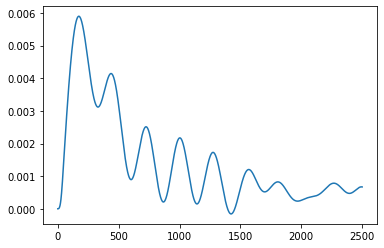

In [52]:
from matplotlib import pyplot as plt
time_list = list(range(total_step+1))
# time_list *= delta_t
plt.plot(time_list, output2400)
plt.show()